In [9]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
import copy
import random
import astroalign as aa
import pickle
import seaborn as sns
import os.path
import jakeGloess as jg
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, join, MaskedColumn, vstack
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from astropy.io.votable import parse, parse_single_table
from astroquery.irsa_dust import IrsaDust
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

#matplotlib.rc('text',usetex=False)
#from matplotlib import rcParams
#rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Computer Modern']

from matplotlib import rcParams
from matplotlib import rc
plt.rcParams.update({'font.size': 12})
rc('text', usetex=False)
rc('font', **{'family': 'serif', 'serif': ['Garamond']})

#from matplotlib import rc
#import matplotlib.pylab as plt
#rc('font', **{'family': 'serif', 'serif': ['Garamond']})
#rc('text', usetex=False)

### Functions:

In [2]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/PAL5/'+savename, dpi=500)
    
    #plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, std, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

def make_catalog(x, y, header):
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return cat, ra, dec

### Initial conditions:

In [3]:
run_all = True  # set to False to run only the first epoch
cluster = 'PAL5'
#cluster = 'PAL13'
base_dir = 'data/'+cluster+'/'
channel = '3p6um'
#channel = '4p5um'
#method = 'aperture'
method = 'PSF'
model_epoch = 'master'  # ePSF model epoch to use (loads from file now for ease)

sigma_level = 6.
#sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
#sharphi = 0.9
sharphi = 1.
sharphi_PSF = 0.85
sharphi_model = 0.7
#sharplo = 0.65
star_r = 20   # defines the bounds of the region around the known RRL location

if cluster == 'PAL5':
    ch1_list = [0, 2, 4, 5]
    ch2_list = [0, 1, 2, 3, 4, 5, 6]
    
if cluster == 'PAL13':
    ch1_list = [0, 1, 2, 4]
    ch2_list = [0, 1, 2, 3]
    

if channel == '3p6um':
    zmag       = 18.80           # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02           # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233         # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  apcorr * 0.02  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
    starlist = ch1_list
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  apcorr * 0.02
    starlist = ch2_list
else:
    print('Please select a valid channel')



### Generate master source list:

Current star: RRL1
Star's pixel coordinates: (1095.3459151059274, 511.6819543849341)


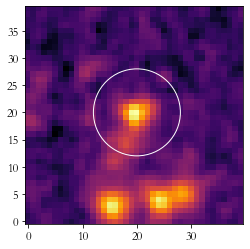

Number of PSF stars: 3


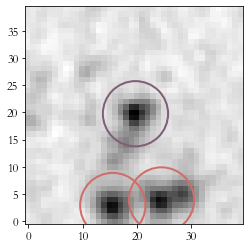

Time taken to fit PSF model: 0.13171230000000378s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA        dec    
--------- --------- --------- --- ... --------- --------- --------- -----------
15.566226 2.8689026 43110.132   1 ... 1090.9121 494.55086 228.99119  -0.1145369
24.524568 3.8885721 52957.257   2 ... 1099.8705 495.57053 228.99078 -0.11598301
19.739028 19.748408 43802.147   3 ... 1095.0849 511.43036  228.9883 -0.11476939
28.979814 5.1603898 18580.561   1 ... 1104.3257 496.84234 228.99045 -0.11668164
   x_0       y_0      flux_0   flux_fit
--------- --------- --------- ---------
15.566226 2.8689026 43110.132 32567.001
24.524568 3.8885721 52957.257 31933.471
19.739028 19.748408 43802.147 37330.825
28.979814 5.1603898 18580.561 15612.696



Current star: RRL3
Star's pixel coordinates: (1345.0222064015043, 76.20564300800925)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


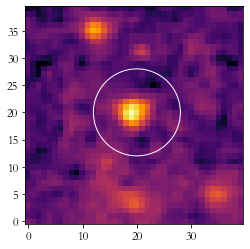

Number of PSF stars: 3


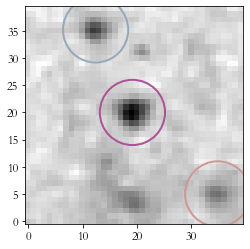

Time taken to fit PSF model: 0.04373359999999593s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA        dec    
--------- --------- --------- --- ... --------- --------- --------- -----------
34.866262 4.9944477 16125.119   1 ... 1359.8885 61.200091 229.05524  -0.1704321
19.182594 19.984488  38792.76   2 ... 1344.2048 76.190131 229.05319  -0.1674493
12.404876 35.168968 16686.909   3 ... 1337.4271 91.374611 229.05088 -0.16592617
   x_0       y_0      flux_0   flux_fit
--------- --------- --------- ---------
34.866262 4.9944477 16125.119 10510.688
19.182594 19.984488  38792.76 35802.153
12.404876 35.168968 16686.909 16178.786



Current star: RRL5
Star's pixel coordinates: (982.7185622342834, 503.49549659307434)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


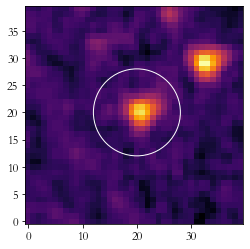

Number of PSF stars: 2


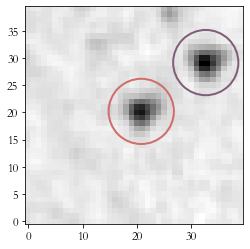

Time taken to fit PSF model: 0.045247500000002105s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA        dec     
--------- --------- --------- --- ... --------- --------- --------- ------------
20.802746 20.180118 40071.655   1 ... 983.52131 503.67561 228.99257 -0.096627198
32.669292 29.157371 44108.073   2 ... 995.38785 512.65287 228.99078 -0.098337696
26.189917 37.882048 4389.4065   1 ... 988.90848 521.37754 228.98952 -0.097037328
   x_0       y_0      flux_0   flux_fit
--------- --------- --------- ---------
20.802746 20.180118 40071.655 38869.977
32.669292 29.157371 44108.073 45648.442
26.189917 37.882048 4389.4065 5494.1628



Current star: RRL6
Star's pixel coordinates: (939.3218401293859, 487.9434503923358)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


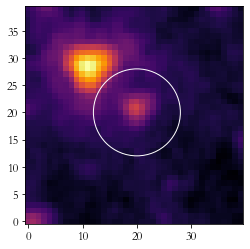

Number of PSF stars: 3


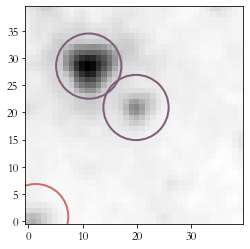

Time taken to fit PSF model: 0.05370150000000251s
   x_0       y_0       flux_0   id ...   y_true      RA        dec     
--------- ---------- --------- --- ... --------- --------- ------------
 1.385058 0.82397972 14289.154   1 ... 468.76743       229 -0.087233715
19.837782  20.897591 70810.586   2 ... 488.84104 228.99621 -0.089729182
  11.1419  28.505942 1244549.8   3 ... 496.44939 228.99519 -0.088094245
9.1066408  27.990092 44507.003   1 ... 495.93354 228.99533 -0.087773343
   x_0       y_0       flux_0   flux_fit
--------- ---------- --------- ---------
 1.385058 0.82397972 14289.154 19906.441
19.837782  20.897591 70810.586 54933.969
  11.1419  28.505942 1244549.8 1290354.8
9.1066408  27.990092 44507.003 110597.49





C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


In [10]:
epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

master_file = base_dir+cluster+'/'+cluster+'_'+channel+'.fits'
with fits.open(master_file) as hdu_list:
    image_m = hdu_list[0].data
    hdr_m = hdu_list[0].header
    exptime = hdr_m['EXPTIME']
    if cluster == 'PAL13' and channel == '4p5um':
        fluxconv = 0.1469
    else:
        fluxconv = hdr_m['FLUXCONV']
    conv = exptime / fluxconv
    data_m = image_m * conv
    w = wcs.WCS(hdr_m)

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        print('Current star: RRL{}'.format(star+1))
    
        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        pix_crd = w.world_to_pixel(star_crd)
        print("Star's pixel coordinates: ({0}, {1})".format(pix_crd[0], pix_crd[1]))

        star_x = int(pix_crd[0])
        star_y = int(pix_crd[1])
        star_ap = CircularAperture((star_r, star_r), r=8.)
        region_m = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
        plt.imshow(region_m, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
        star_ap.plot(color='white')
        plt.show()

        mean, median, std = sigma_clipped_stats(region_m, sigma=sigma_level)
        #print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

        ###   DETECTING MORE STARS   ###

        sources_m = star_find(region_m, sigma_level, FWHM, std, roundness, sharphi_PSF)
        pos_m = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
        ap_m = CircularAperture(pos_m, r_ap)
        print('Number of PSF stars: {}'.format(len(sources_m)))
        #plotting(region_m, ap_m, an=None, cmap='Greys', choice='ap_only', savename=None)

        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

        sources_m['xcentroid'].name = 'x_0'
        sources_m['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        #daogroup = DAOGroup(crit_separation=4*FWHM)
        star_groups = daogroup(sources_m)
        star_groups = star_groups.group_by('group_id')

        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(region_m, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        if ncolors > 1:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color=cmap.colors[i], lw=2.)
        else:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color='blue', lw=2.)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###

        region_m_nonans = np.nan_to_num(region_m, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        daofind_m = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
        fit_rad = 5

        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_m['x_0'], sources_m['y_0']])
        #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_m,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 2,
                              aperture_radius = 6.)
        master_stars = PSF_photometry(image=region_m_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

        master_stars['id_master'] = np.arange(len(master_stars))
        
        true_x = pix_crd[0]+master_stars['x_0']-star_r  # actual pixel coords of star in image,
        true_y = pix_crd[1]+master_stars['y_0']-star_r  # since pix_crd is measured relative to the box
        
        master_stars['x_true'] = true_x
        master_stars['y_true'] = true_y
        
        cat_m, ra_m, dec_m = make_catalog(true_x, true_y, hdr_m)
        master_stars['RA'] = ra_m
        master_stars['dec'] = dec_m
        
        print_table_nicely(master_stars)
        print(master_stars['x_0', 'y_0', 'flux_0', 'flux_fit'])
        master_stars['id_master', 'x_0', 'y_0', 'x_true', 'y_true', 'RA', 'dec'].write('outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt', format='csv', overwrite=True)
        
        print('\n\n')
        
#master_stars

In [5]:
master_file = 'outputs/'+cluster+'/masterlist_RRL0_'+channel+'.txt'
print(master_file)
master_table = Table.read(master_file, format='ascii.csv')
print_table_nicely(master_table)

outputs/PAL5/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0      x_true    y_true      RA        dec    
--------- --------- --------- --------- --------- --------- -----------
        0 15.566226 2.8689026 1090.9121 494.55086 228.99119  -0.1145369
        1 24.524568 3.8885721 1099.8705 495.57053 228.99078 -0.11598301
        2 19.739028 19.748408 1095.0849 511.43036  228.9883 -0.11476939
        3 28.979814 5.1603898 1104.3257 496.84234 228.99045 -0.11668164


### Main photometry cell:

In [15]:
tbl_CC = Table.read('data/reference/CVSGC_'+cluster+'_readable.txt', format='ascii.csv')
tbl_CC

<Table length=5>
  ID       RA          dec     ... gaia_ID_2            comments          
int32    str12        str11    ...   int32               str29            
----- ------------ ----------- ... --------- -----------------------------
    1 23h06m41.53s 12d46m58.9s ... 367752192                            --
    2 23h06m44.47s 12d46m16.1s ... 504602624 only 90% sure on this gaia id
    3 23h06m43.14s 12d46m47.8s ... 504601600                            --
    4 23h06m48.83s 12d41m22.3s ...  52959232                            --
    5 23h06m37.28s 12d49m27.5s ... 118708992                            --

In [5]:
with fits.open(base_dir+'PAL5__e1/PAL5__e1_'+channel+'.fits') as hdu_list:  
    image_data = hdu_list[0].data
    hdr = hdu_list[0].header
    exptime = hdr['EXPTIME']
    fluxconv = hdr['FLUXCONV']
    conv = exptime / fluxconv
    data = image_data * conv


Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd

56422.909763090276

Photometry method selected: PSF
Current star: RRL1
Epoch:  1


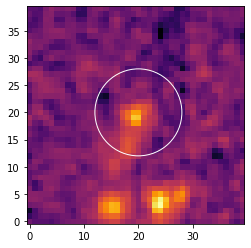

Mean: 48.51197052001953
Median: 45.25404357910156
Std dev: 16.4495906829834
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.195186248325726 ...  2.496511918302513 -0.9933341092750975
  2 23.948920598419324 ... 3.6808705173540632 -1.4148763511501559
  3 19.413976460586404 ... 2.3782300505837037 -0.9406346560543276
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


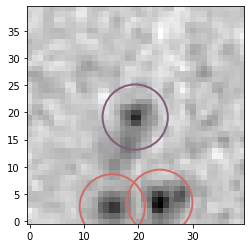

Time taken to fit PSF model: 0.03887810000014724s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


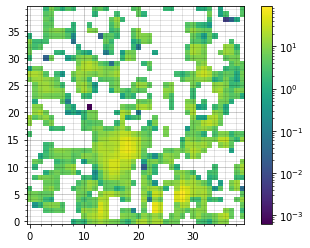

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 15.195186 ...    16.541699 0.056561537 115.95936
  2        1             1 23.948921 ...    16.026293 0.042881646 120.16798
  3        2             1 19.413976 ...    16.507441 0.046630741 89.537018
Median mag error:  0.04663074146714851
Median flux error: 115.9593601101803
id_master    x_0       y_0      x_true  ...     dec       mag_e1     err_e1  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... -0.11464486 16.541699 0.056561537
        1 25.039755 3.6411789 420.03396 ... -0.11608117 16.026293 0.042881646
        2 20.289235 19.423976 415.28344 ... -0.11486885 16.507441 0.046630741
        3 29.606008 5.3802133 424.60021 ... -0.11678441        --          --




Epoch:  2


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


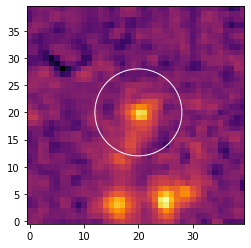

Mean: 48.66366958618164
Median: 44.974945068359375
Std dev: 15.628585815429688
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  16.19492385032434 ... 2.5277930921099183 -1.0068538067073907
  2 24.994022342509115 ...  3.680272953885836 -1.4147000751962757
  3 20.358741556995962 ... 2.7881299543267777 -1.1132825307490264
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


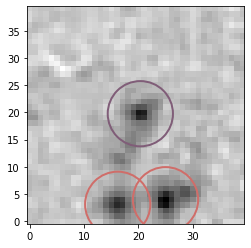

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05477280000013707s


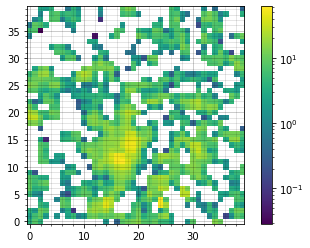

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 16.194924 ...    16.497745 0.052426736 108.40544
  2        1             1 24.994022 ...    16.139893 0.042486605 106.29976
  3        2             1 20.358742 ...    16.420718 0.041103802 76.824689
  4        1             2 29.681743 ...    17.588783  0.10045091 87.950562
Median mag error:  0.04745667053544966
Median flux error: 97.12515964432554
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.056561537 16.497745 0.052426736
        1 25.039755 3.6411789 420.03396 ... 0.042881646 16.139893 0.042486605
        2 20.289235 19.423976 415.28344 ... 0.046630741 16.420718 0.041103802
        3 29.606008 5.3802133 424.60021 ...          -- 17.588783  0.10045091


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


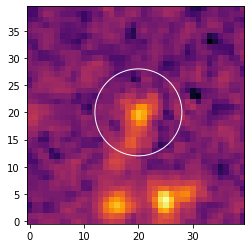

Mean: 47.76674270629883
Median: 44.14507293701172
Std dev: 16.642208099365234


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.941841032333658 ... 2.2471027207826437 -0.8790573139465991
  2   24.9050757778115 ...  3.756185792449965 -1.4368676641503941
  3  20.21692426266887 ...  2.349889220790544 -0.9276184727714837
Number of PSF stars: 3


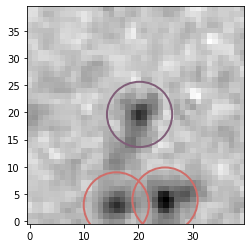

Time taken to fit PSF model: 0.050368999999591324s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


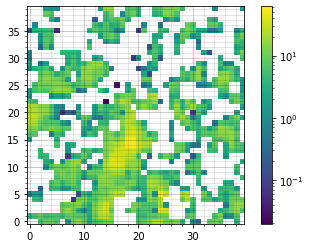

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 15.941841 ...     16.54049  0.05206899 103.20432
  2        1             1 24.905076 ...    16.041737 0.040296159 104.47511
  3        2             1 20.216924 ...    16.501761 0.046680321 90.166795
  4        1             2   29.7552 ...    17.697625  0.10132709 80.341428
Median mag error:  0.04937465554559341
Median flux error: 96.68555550304117
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.052426736  16.54049  0.05206899
        1 25.039755 3.6411789 420.03396 ... 0.042486605 16.041737 0.040296159
        2 20.289235 19.423976 415.28344 ... 0.041103802 16.501761 0.046680321
        3 29.606008 5.3802133 424.60021 ...  0.10045091 17.697625  0.10132709


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


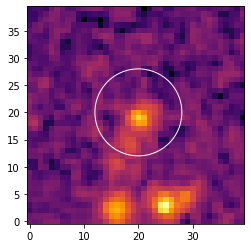

Mean: 45.8329963684082
Median: 41.79338073730469
Std dev: 18.104814529418945
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  15.96339145054674 ... 2.4230444447804427 -0.9609034506820545
  2  24.92601973016054 ... 3.5487117969647093  -1.375176825594753
  3 20.197024822952358 ...  2.512141164637831 -1.0001101001038857
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


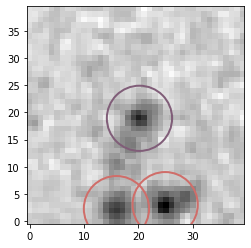

Time taken to fit PSF model: 0.041606700000556884s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


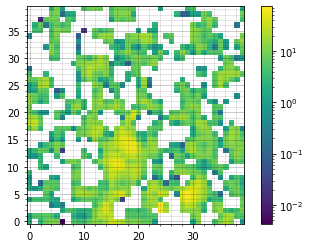

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 15.963391 ...    16.409844 0.055743782  128.3281
  2        1             1  24.92602 ...    16.041735 0.043641544 122.43535
  3        2             1 20.197025 ...     16.41618 0.046349052 96.407865
Median mag error:  0.04634905243475012
Median flux error: 122.43535352164106
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ...  0.05206899 16.409844 0.055743782
        1 25.039755 3.6411789 420.03396 ... 0.040296159 16.041735 0.043641544
        2 20.289235 19.423976 415.28344 ... 0.046680321  16.41618 0.046349052
        3 29.606008 5.3802133 424.60021 ...  0.10132709        --          --




Epoch:  5


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


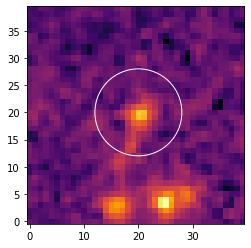

Mean: 46.28141784667969
Median: 42.55772018432617
Std dev: 16.485158920288086
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.997627167076812 ...  2.289333898384748 -0.8992728474035461
  2 24.869623694776106 ... 3.6838019857458844 -1.4157406941424227
  3  20.25490267472083 ... 2.6207430977275528 -1.0460611266629505
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


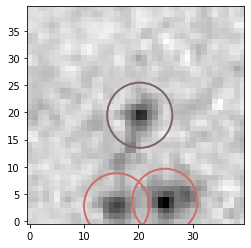

Time taken to fit PSF model: 0.04036149999956251s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


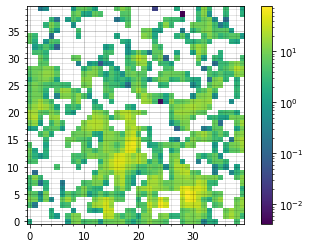

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 15.997627 ...    16.633622 0.058822451 112.33869
  2        1             1 24.869624 ...    15.986692 0.041660628 117.77405
  3        2             1 20.254903 ...    16.432541 0.042728137 82.081496
Median mag error:  0.04272813720804689
Median flux error: 112.33869212423026
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.055743782 16.633622 0.058822451
        1 25.039755 3.6411789 420.03396 ... 0.043641544 15.986692 0.041660628
        2 20.289235 19.423976 415.28344 ... 0.046349052 16.432541 0.042728137
        3 29.606008 5.3802133 424.60021 ...          --        --          --




Epoch:  6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


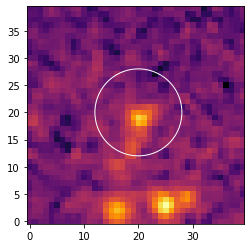

Mean: 45.56367874145508
Median: 42.353912353515625
Std dev: 16.663209915161133
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1  16.0719012313086 ... 2.7694304029481156 -1.1059761390024965
  2 24.90565937756239 ...  4.085765659652696 -1.5281836347925477
  3  20.2194493606256 ...  2.716764232335971 -1.0851298772019642
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


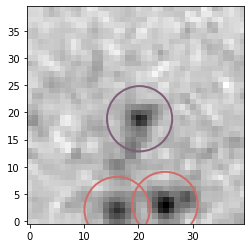

Time taken to fit PSF model: 0.05016389999946114s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


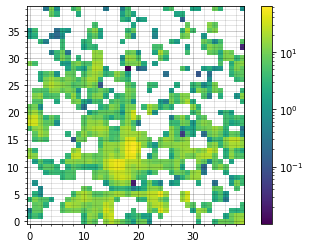

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 16.071901 ...    16.520546 0.053797176  110.2432
  2        1             1 24.905659 ...    16.023169 0.040960433 110.04643
  3        2             1 20.219449 ...     16.45775 0.042223897 78.406489
  4        1             2 29.706705 ...    17.656499  0.10182976 83.912313
Median mag error:  0.04801053683780308
Median flux error: 96.97937244988094
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.058822451 16.520546 0.053797176
        1 25.039755 3.6411789 420.03396 ... 0.041660628 16.023169 0.040960433
        2 20.289235 19.423976 415.28344 ... 0.042728137  16.45775 0.042223897
        3 29.606008 5.3802133 424.60021 ...          -- 17.656499  0.10182976


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


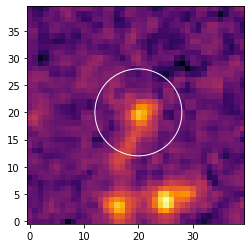

Mean: 48.343177795410156
Median: 44.49708557128906
Std dev: 16.78449821472168
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  16.30982446311545 ... 2.3319762016915333 -0.9193102851072532
  2 25.023343052397852 ... 3.6921932401166084 -1.4182110570765363
  3  20.40889631752404 ...  2.291542034276569 -0.9003195700407475
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


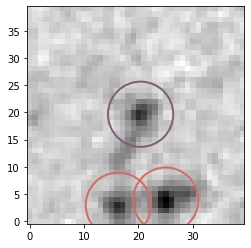

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.09941150000031485s


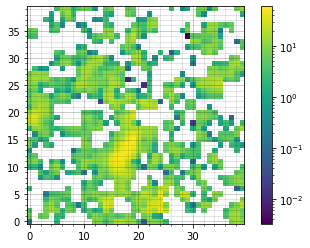

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 16.309824 ...    16.492274 0.052751649 109.97944
  2        1             1 25.023343 ...    16.044007 0.040703196  106.5271
  3        2             1 20.408896 ...     16.46116 0.044761478 87.103959
  4        1             2  29.69283 ...    17.540434 0.090297035 81.756031
Median mag error:  0.048756563719631746
Median flux error: 96.81552955610562
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.053797176 16.492274 0.052751649
        1 25.039755 3.6411789 420.03396 ... 0.040960433 16.044007 0.040703196
        2 20.289235 19.423976 415.28344 ... 0.042223897  16.46116 0.044761478
        3 29.606008 5.3802133 424.60021 ...  0.10182976 17.540434 0.090297035

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


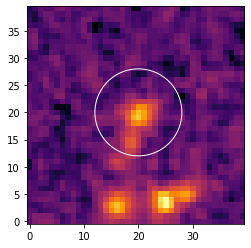

Mean: 46.057003021240234
Median: 42.313934326171875
Std dev: 16.521528244018555
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 16.118641614439415 ... 2.3121677903471074  -0.910048367383508
  2 24.923287980721003 ...  3.600728691075495 -1.3909759980909717
  3  20.11429137892751 ... 2.4545537792367766 -0.9749313798144161
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


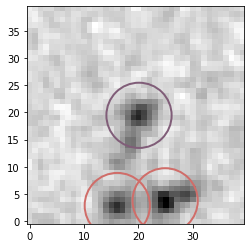

Time taken to fit PSF model: 0.061513799999374896s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


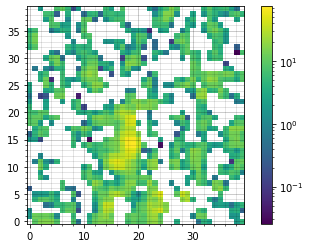

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 16.118642 ...    16.556369 0.058269698  119.1541
  2        1             1 24.923288 ...    16.039376 0.043704002 123.05001
  3        2             1 20.114291 ...     16.36783 0.052798393 123.51175
  4        1             2 29.529758 ...    17.372051 0.082263343 85.916227
Median mag error:  0.05553404546455052
Median flux error: 121.10205548474228
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.052751649 16.556369 0.058269698
        1 25.039755 3.6411789 420.03396 ... 0.040703196 16.039376 0.043704002
        2 20.289235 19.423976 415.28344 ... 0.044761478  16.36783 0.052798393
        3 29.606008 5.3802133 424.60021 ... 0.090297035 17.372051 0.082263343

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


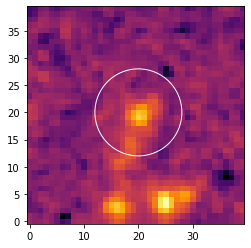

Mean: 44.01976013183594
Median: 40.52923583984375
Std dev: 16.004215240478516
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  16.01552224654609 ... 2.4885651320529822 -0.9898725295385993
  2 24.886441153575312 ...  3.625249147845331 -1.3983446478303847
  3 20.184086537176757 ...  2.524448071520652 -1.0054161039642002
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


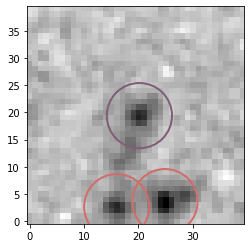

Time taken to fit PSF model: 0.05380860000059329s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


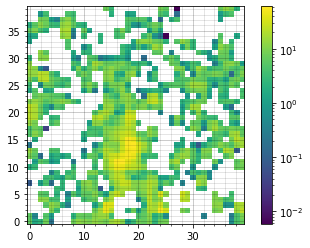

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 16.015522 ...    16.593017 0.055674662 108.24819
  2        1             1 24.886441 ...    16.027186 0.041106735 110.46403
  3        2             1 20.184087 ...    16.454565 0.046826003 94.690358
  4        1             2  29.37042 ...    17.692397  0.10824112 86.756982
Median mag error:  0.05125033270722709
Median flux error: 101.46927494155344
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.058269698 16.593017 0.055674662
        1 25.039755 3.6411789 420.03396 ... 0.043704002 16.027186 0.041106735
        2 20.289235 19.423976 415.28344 ... 0.052798393 16.454565 0.046826003
        3 29.606008 5.3802133 424.60021 ... 0.082263343 17.692397  0.10824112

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


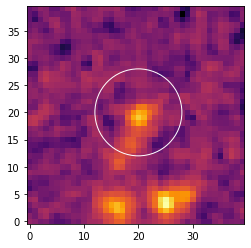

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Mean: 45.20113754272461
Median: 41.81450653076172
Std dev: 15.861642837524414
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 16.033731534126474 ... 2.3148857055472516 -0.9113238829038146
  2  25.09113601227766 ... 3.8176174162184036  -1.454481008185945
  3   20.1896866306913 ... 2.6611732010941664 -1.0626828532626944
Number of PSF stars: 3


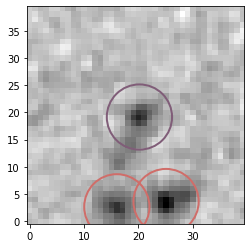

Time taken to fit PSF model: 0.06929709999985789s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


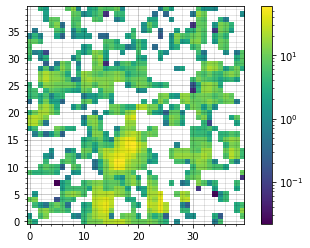

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 16.033732 ...    16.535275  0.05709222 118.18247
  2        1             1 25.091136 ...    16.018788 0.042283061 117.80315
  3        2             1 20.189687 ...    16.517554 0.046533567 88.423165
  4        1             2 29.309718 ...    17.706137   0.1138013 90.408902
Median mag error:  0.05181289352688439
Median flux error: 104.10602749227981
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.055674662 16.535275  0.05709222
        1 25.039755 3.6411789 420.03396 ... 0.041106735 16.018788 0.042283061
        2 20.289235 19.423976 415.28344 ... 0.046826003 16.517554 0.046533567
        3 29.606008 5.3802133 424.60021 ...  0.10824112 17.706137   0.1138013

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


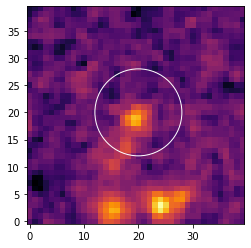

Mean: 45.33045196533203
Median: 41.48736572265625
Std dev: 17.26478385925293
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.211078136982273 ...  2.295487822601779 -0.9021874830177008
  2 24.139115979864304 ... 3.5009914876598613 -1.3604776370476541
  3 19.440412979359323 ... 2.2967276298125294  -0.902773737570557
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


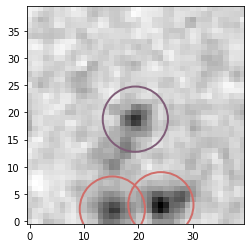

Time taken to fit PSF model: 0.041854899999634654s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


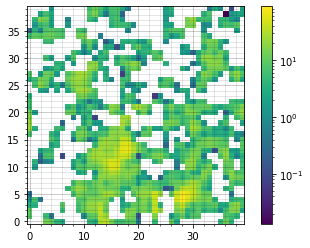

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 15.211078 ...     16.53634 0.057555065 119.38373
  2        1             1 24.139116 ...    16.096201 0.043396901 115.27921
  3        2             1 19.440413 ...    16.522648 0.045472763 84.633602
Median mag error:  0.04547276313009842
Median flux error: 115.27921035587195
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ...  0.05709222  16.53634 0.057555065
        1 25.039755 3.6411789 420.03396 ... 0.042283061 16.096201 0.043396901
        2 20.289235 19.423976 415.28344 ... 0.046533567 16.522648 0.045472763
        3 29.606008 5.3802133 424.60021 ...   0.1138013        --          --




Epoch:  12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


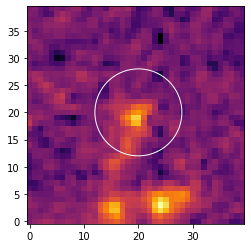

Mean: 44.15941619873047
Median: 40.4007453918457
Std dev: 17.24353790283203
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.392036779151708 ...  2.582175510415876 -1.0299643948014374
  2 24.214170038887524 ...  3.535723640420815  -1.371195780748868
  3 19.422325387373352 ... 2.5074258314251483 -0.9980702390973628
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


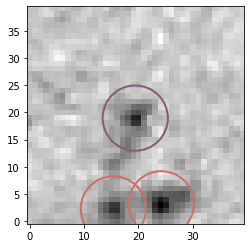

Time taken to fit PSF model: 0.05317230000036943s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


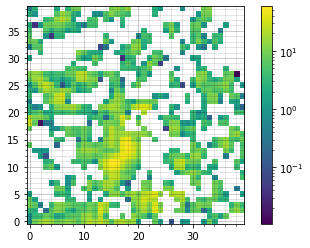

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 15.392037 ...    16.517536 0.054390844 112.33704
  2        1             1  24.21417 ...      16.0461 0.041251713 109.38002
  3        2             1 19.422325 ...    16.412977 0.046461276 97.143134
  4        1             2 28.798874 ...    17.543459 0.083627439 74.792351
Median mag error:  0.05042606024174041
Median flux error: 103.26157560669063
id_master    x_0       y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 16.157575 2.7609621 411.15178 ... 0.057555065 16.517536 0.054390844
        1 25.039755 3.6411789 420.03396 ... 0.043396901   16.0461 0.041251713
        2 20.289235 19.423976 415.28344 ... 0.045472763 16.412977 0.046461276
        3 29.606008 5.3802133 424.60021 ...          -- 17.543459 0.083627439

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


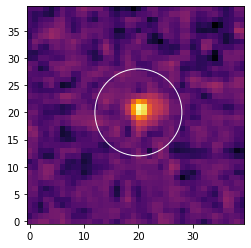

Mean: 41.1786994934082
Median: 40.89468765258789
Std dev: 7.847987174987793
sources_PSF:   id     xcentroid          ycentroid     ...        flux              mag       
--- ------------------ ----------------- ... ----------------- -----------------
  1 20.369809881249914 20.56084304064586 ... 7.222399609133856 -2.14670378473565
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


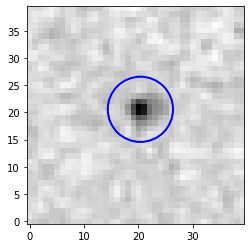

Time taken to fit PSF model: 0.04943809999986115s


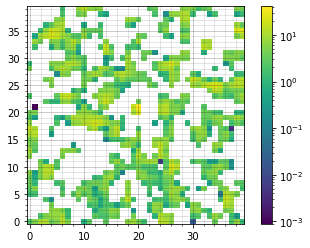

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1  20.36981 ...    16.264627 0.035048002 56.772852
  2        1             2 19.098478 ...     20.12875  0.67065826 57.324335
Median mag error:  0.352853133289634
Median flux error: 57.04859350007566
id_master    x_0       y_0      x_true  ...     dec       mag_e1     err_e1  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.990682 1.8997851 872.89563 ... -0.19312144        --          --
        1 20.331909 20.728731 856.23686 ... -0.18986799 16.264627 0.035048002
        1 20.331909 20.728731 856.23686 ... -0.18986799  20.12875  0.67065826
        2 37.285987 37.003913 873.19094 ... -0.19221077        --          --




Epoch:  2


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


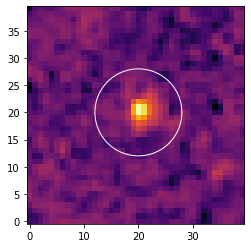

Mean: 40.44280242919922
Median: 40.02161407470703
Std dev: 8.628872871398926
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.361848789485613 ... 6.467721564329581 -2.0268782881052108
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


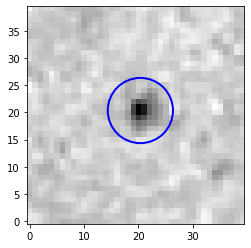

Time taken to fit PSF model: 0.027336000000104832s


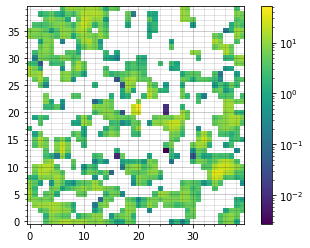

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.361849 ...    16.242205 0.035518138 60.599777
Median mag error:  0.03551813761882633
Median flux error: 60.59977716839162
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.990682 1.8997851 872.89563 ...          --        --          --
        1 20.331909 20.728731 856.23686 ... 0.035048002 16.242205 0.035518138
        1 20.331909 20.728731 856.23686 ...  0.67065826 16.242205 0.035518138
        2 37.285987 37.003913 873.19094 ...          --        --          --




Epoch:  3


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


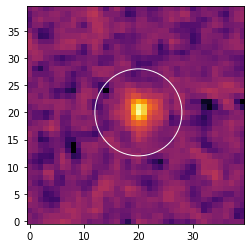

Mean: 39.81893539428711
Median: 39.430484771728516
Std dev: 8.543445587158203
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 20.162250170015085 ...  5.821387380640931  -1.9125662502638272
  2  37.40898404524813 ... 1.1486807049519205 -0.15049831508831032
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


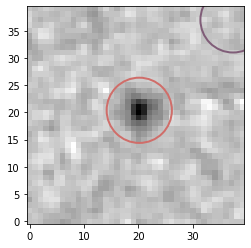

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.033097100000304636s


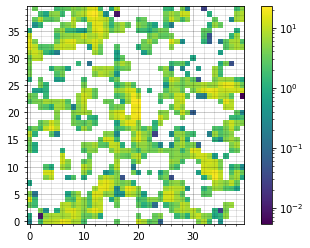

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1  20.16225 ...    16.295735 0.035565443 57.943026
  2        2             1 37.408984 ...          nan         nan 29.582356
Median mag error:  nan
Median flux error: 43.76269115605419
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.990682 1.8997851 872.89563 ...          --        --          --
        1 20.331909 20.728731 856.23686 ... 0.035518138 16.295735 0.035565443
        1 20.331909 20.728731 856.23686 ... 0.035518138 16.295735 0.035565443
        2 37.285987 37.003913 873.19094 ...          --       nan         nan




Epoch:  4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


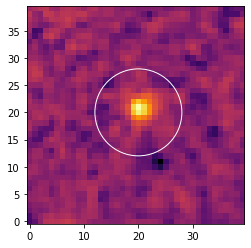

Mean: 38.53853225708008
Median: 38.044715881347656
Std dev: 8.583159446716309
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.230887508087513 ... 6.546391034626902 -2.0400048584903647
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


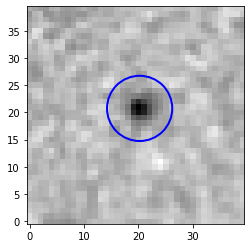

Time taken to fit PSF model: 0.02857979999953386s


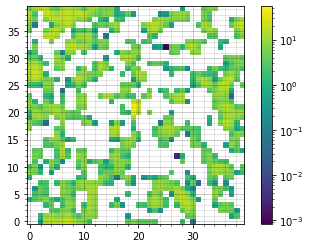

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.230888 ...    16.286946 0.036565224 63.533388
Median mag error:  0.036565224070597833
Median flux error: 63.533388355236475
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.990682 1.8997851 872.89563 ...          --        --          --
        1 20.331909 20.728731 856.23686 ... 0.035565443 16.286946 0.036565224
        1 20.331909 20.728731 856.23686 ... 0.035565443 16.286946 0.036565224
        2 37.285987 37.003913 873.19094 ...         nan        --          --




Epoch:  5


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


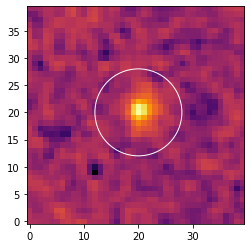

Mean: 37.648406982421875
Median: 37.00720977783203
Std dev: 9.122385025024414
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.263178720157875 ... 5.541778426817749 -1.8591228942262894
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


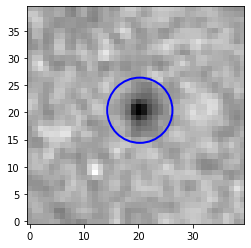

Time taken to fit PSF model: 0.04677630000060162s


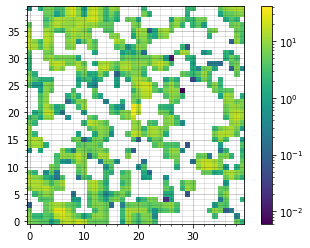

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.263179 ...     16.27945 0.035640288 59.208606
Median mag error:  0.03564028772696322
Median flux error: 59.208605895173605
id_master    x_0       y_0      x_true  ...    err_e4    mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- -------- -----------
        0 36.990682 1.8997851 872.89563 ...          --       --          --
        1 20.331909 20.728731 856.23686 ... 0.036565224 16.27945 0.035640288
        1 20.331909 20.728731 856.23686 ... 0.036565224 16.27945 0.035640288
        2 37.285987 37.003913 873.19094 ...          --       --          --




Epoch:  6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


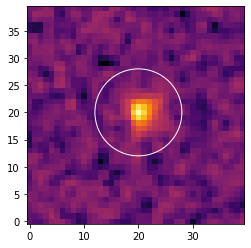

Mean: 37.286521911621094
Median: 37.00897979736328
Std dev: 7.7676615715026855
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  36.74975912431839 ... 1.0033248935673473 -0.003603969230604382
  2 20.319314972480456 ...  6.601888376677424    -2.049170442744416
  3 36.854101843225024 ... 1.0962536367268296   -0.0997776177773735
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


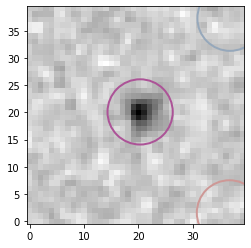

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04310220000024856s


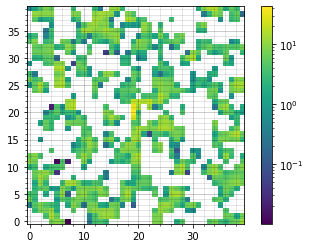

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 36.749759 ...          nan         nan 39.447922
  2        2             1 20.319315 ...    16.269574 0.036352491 63.488008
  3        3             1 36.854102 ...          nan         nan 40.257934
Median mag error:  nan
Median flux error: 40.25793389982753
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.990682 1.8997851 872.89563 ...          --       nan         nan
        1 20.331909 20.728731 856.23686 ... 0.035640288 16.269574 0.036352491
        1 20.331909 20.728731 856.23686 ... 0.035640288 16.269574 0.036352491
        2 37.285987 37.003913 873.19094 ...          --       nan         nan




Epoch:  7


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


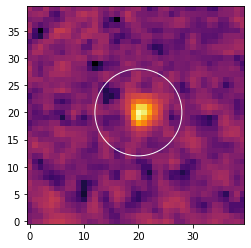

Mean: 39.13587188720703
Median: 38.830135345458984
Std dev: 8.209239959716797
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 20.481526025533462 ...  6.023079408627323    -1.94954647242974
  2  37.32145148635267 ... 1.3258237174697698 -0.30621445945629466
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


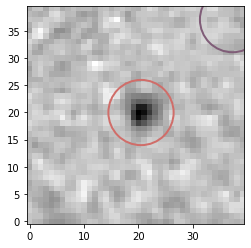

Time taken to fit PSF model: 0.036929699999745935s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


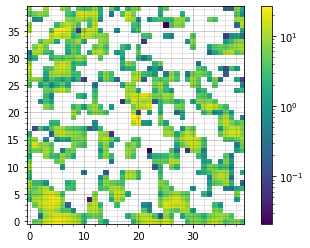

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- --------- ------------ ---------- ---------
  1        1             1 20.481526 19.970097    16.271033 0.03546569 58.651875
  2        2             1 37.321451 37.061939    20.488252  0.6139437 37.632747
Median mag error:  0.32470469584539885
Median flux error: 48.14231113943109
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7    err_e7  
--------- --------- --------- --------- ... ----------- --------- ----------
        0 36.990682 1.8997851 872.89563 ...         nan        --         --
        1 20.331909 20.728731 856.23686 ... 0.036352491 16.271033 0.03546569
        1 20.331909 20.728731 856.23686 ... 0.036352491 16.271033 0.03546569
        2 37.285987 37.003913 873.19094 ...         nan 20.488252  0.6139437




Epoch:  8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


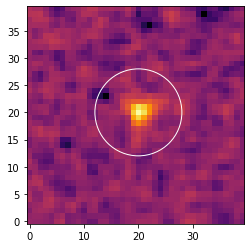

Mean: 39.03803253173828
Median: 38.93473815917969
Std dev: 8.648823738098145
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  20.21473213215437 ...  6.643703221985392 -2.0560255600757156
  2 1.8152161621084355 ... 1.4852106599883481 -0.4294701442036147
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


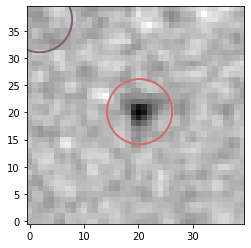

Time taken to fit PSF model: 0.03601669999989099s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


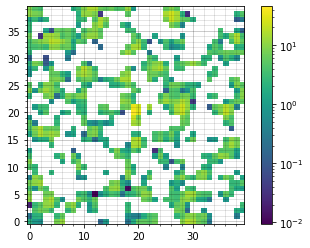

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.214732 ...    16.311673 0.037863049 68.273688
  2        2             1 1.8152162 ...    19.336744  0.26742885 47.192335
Median mag error:  0.15264595180242074
Median flux error: 57.733011199272
id_master    x_0       y_0      x_true  ...   err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ---------- --------- -----------
        0 36.990682 1.8997851 872.89563 ...         --        --          --
        1 20.331909 20.728731 856.23686 ... 0.03546569 16.311673 0.037863049
        1 20.331909 20.728731 856.23686 ... 0.03546569 16.311673 0.037863049
        2 37.285987 37.003913 873.19094 ...  0.6139437        --          --




Epoch:  9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


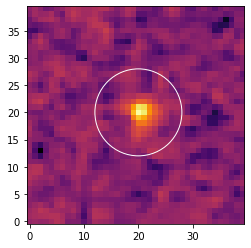

Mean: 37.61014938354492
Median: 37.02077865600586
Std dev: 8.918722152709961
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.439105089414976 ... 6.361233098761714 -2.0088532750013632
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


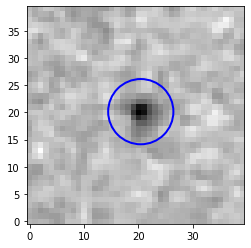

Time taken to fit PSF model: 0.02775130000009085s


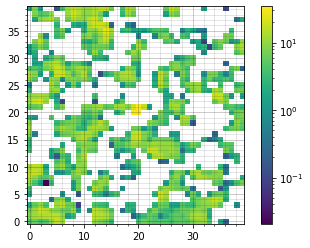

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.439105 ...    16.193343 0.035685879 64.385802
Median mag error:  0.035685878927730334
Median flux error: 64.38580206650074
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.990682 1.8997851 872.89563 ...          --        --          --
        1 20.331909 20.728731 856.23686 ... 0.037863049 16.193343 0.035685879
        1 20.331909 20.728731 856.23686 ... 0.037863049 16.193343 0.035685879
        2 37.285987 37.003913 873.19094 ...          --        --          --




Epoch:  10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


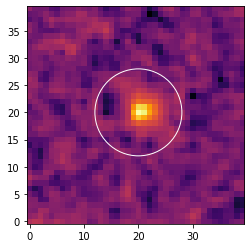

Mean: 36.82773971557617
Median: 36.08749008178711
Std dev: 8.89554500579834


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 2.0414916531062897 ... 1.3230222914645595 -0.30391790407890684
  2 20.561281475476708 ...  5.579467055588093  -1.8664817939967013
  3  37.27074417236408 ... 1.1286793813036788 -0.13142647858172796
Number of PSF stars: 3


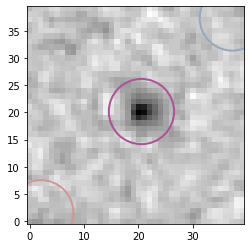

Time taken to fit PSF model: 0.03848550000020623s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


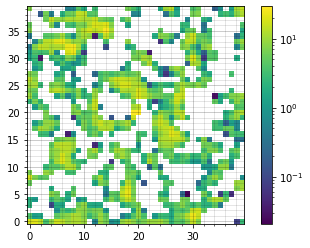

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 2.0414917 ...    19.070658  0.20130401 45.172772
  2        2             1 20.561281 ...    16.228134 0.035600786 61.878622
  3        3             1 37.270744 ...    20.442046  0.54501771 34.911056
Median mag error:  0.2013040055953262
Median flux error: 45.17277205635452
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.990682 1.8997851 872.89563 ...          --        --          --
        1 20.331909 20.728731 856.23686 ... 0.035685879 16.228134 0.035600786
        1 20.331909 20.728731 856.23686 ... 0.035685879 16.228134 0.035600786
        2 37.285987 37.003913 873.19094 ...          -- 20.442046  0.54501771




Epoch:  11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


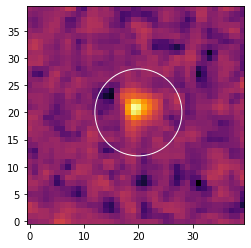

Mean: 37.02983856201172
Median: 36.50552749633789
Std dev: 8.634394645690918
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 19.548789671835117 ... 6.026684357042491 -1.9501961155602645
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


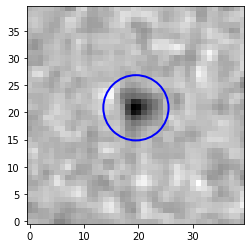

Time taken to fit PSF model: 0.034650800000235904s


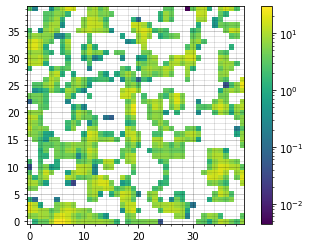

 id group_id iter_detected  x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- -------- --------- ------------ ---------- ---------
  1        1             1 19.54879 20.842837    16.211465 0.03398546 53.158951
Median mag error:  0.03398546029713512
Median flux error: 53.15895124719592
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11   err_e11  
--------- --------- --------- --------- ... ----------- --------- ----------
        0 36.990682 1.8997851 872.89563 ...          --        --         --
        1 20.331909 20.728731 856.23686 ... 0.035600786 16.211465 0.03398546
        1 20.331909 20.728731 856.23686 ... 0.035600786 16.211465 0.03398546
        2 37.285987 37.003913 873.19094 ...  0.54501771        --         --




Epoch:  12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


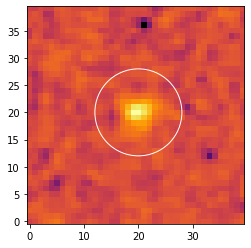

Mean: 36.71232604980469
Median: 36.22527313232422
Std dev: 8.407902717590332
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  2.371503676093126 ... 1.2017391214285835 -0.19952549857458196
  2  19.83871691066316 ...  6.464015894140386  -2.0262560390980147
  3 25.504392983090153 ... 1.1966800282154475  -0.1949451075181791
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


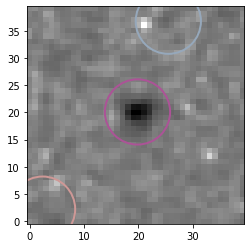

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05961569999999483s


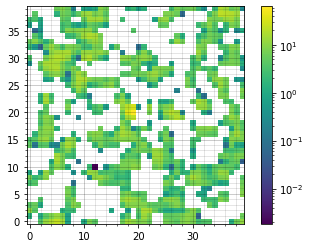

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- --------- ------------ ---------- ---------
  1        1             1 2.3715037 2.1967183    19.370948  0.2940469  50.33986
  2        2             1 19.838717 20.076436    16.236744 0.03741255 70.919184
  3        3             1 25.504393 36.762976    19.666697 0.41125707 53.751092
Median mag error:  0.2940469034841591
Median flux error: 53.751092012705904
id_master    x_0       y_0      x_true  ...  err_e11    mag_e12   err_e12  
--------- --------- --------- --------- ... ---------- --------- ----------
        0 36.990682 1.8997851 872.89563 ...         --        --         --
        1 20.331909 20.728731 856.23686 ... 0.03398546 16.236744 0.03741255
        1 20.331909 20.728731 856.23686 ... 0.03398546 16.236744 0.03741255
        2 37.285987 37.003913 873.19094 ...         --        --         --




Star ID:  1
star_name id_master     RA        dec        x_

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


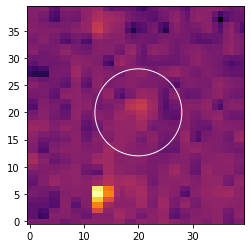

Mean: 54.00506591796875
Median: 52.447784423828125
Std dev: 19.8986873626709
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.278681985622153 ... 1.7344649294611476 -0.5979138072951775
  2 12.858073271260647 ... 1.6773394261322143 -0.5615523881493912
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


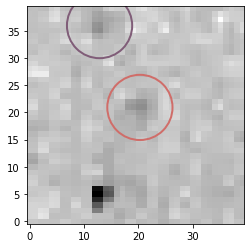

Time taken to fit PSF model: 0.03752359999998589s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


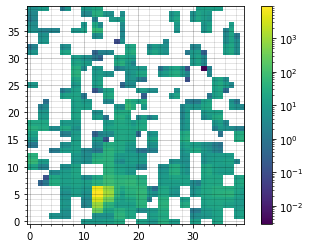

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.278682 ...    16.745108 0.061129918 106.27014
  2        2             1 12.858073 ...    16.909062 0.066809582 102.30789
Median mag error:  0.0639697499188408
Median flux error: 104.28901233153461
id_master    x_0       y_0      x_true  ...     dec       mag_e1     err_e1  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ... -0.16805136        --          --
        1 19.655275 20.208865 663.16947 ... -0.16752095 16.745108 0.061129918
        2 12.940712  35.81612 656.45491 ... -0.16599051 16.909062 0.066809582




Epoch:  2


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


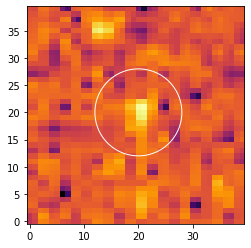

Mean: 52.74126052856445
Median: 50.851531982421875
Std dev: 18.96440887451172
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.384359544213545 ... 2.1609089905428354 -0.8365911909964456
  2 13.238471159964412 ... 1.8243591969751232 -0.6527758759707152
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


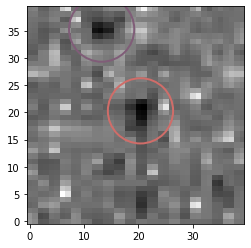

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04587349999928847s


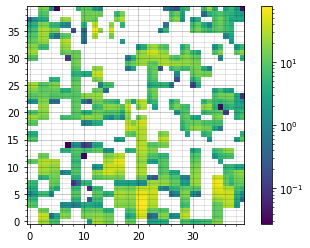

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1  20.38436 ...    16.467847  0.05392101 115.65611
  2        2             1 13.238471 ...    16.866945 0.064649968 102.07862
Median mag error:  0.05928548897146198
Median flux error: 108.86736206585569
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...          --        --          --
        1 19.655275 20.208865 663.16947 ... 0.061129918 16.467847  0.05392101
        2 12.940712  35.81612 656.45491 ... 0.066809582 16.866945 0.064649968




Epoch:  3


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


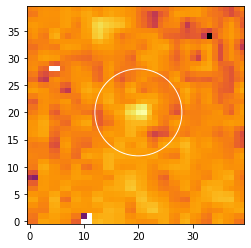

Mean: 52.093231201171875
Median: 50.87788391113281
Std dev: 20.078420639038086
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.213093940324352 ...  2.710548391965301  -1.082642913081279
  2 13.136046038549834 ... 1.2973093478801172 -0.2826088686183908
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


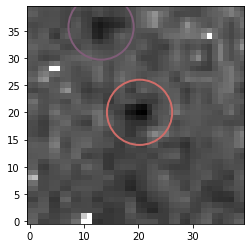

Time taken to fit PSF model: 0.03430800000023737s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


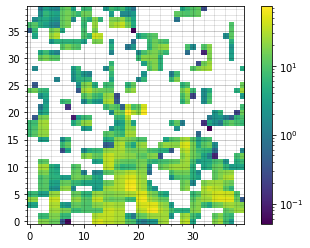

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.213094 ...    16.452048 0.053669277 116.55034
  2        2             1 13.136046 ...    16.972434 0.053853921 72.526131
Median mag error:  0.05376159879307846
Median flux error: 94.53823375803236
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...          --        --          --
        1 19.655275 20.208865 663.16947 ...  0.05392101 16.452048 0.053669277
        2 12.940712  35.81612 656.45491 ... 0.064649968 16.972434 0.053853921




Epoch:  4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


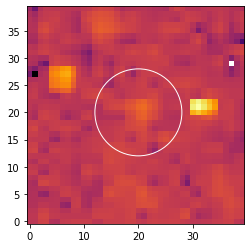

Mean: 53.71439743041992
Median: 50.7508659362793
Std dev: 21.77948570251465
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.661621555299067 ... 1.7925656627552635 -0.6336876827463506
  2  6.195301613610583 ... 10.314265403544914  -2.533595755870472
  3 13.480538729158562 ... 1.2285205892262256 -0.2234560984431933
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


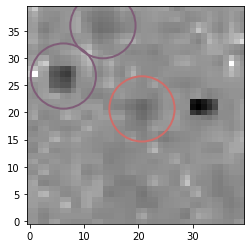

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.1563479999995252s


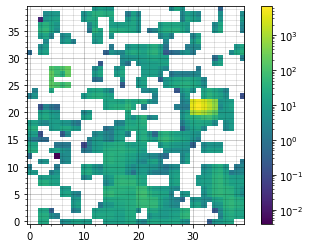

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.661622 ...    16.460649 0.048661253 99.810602
  2        2             1 6.1953016 ...     14.95814 0.042879679 320.18605
  3        2             1 13.480539 ...    16.828161  0.18370916 333.50271
Median mag error:  0.04866125335891454
Median flux error: 320.18604769413076
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...          --        --          --
        1 19.655275 20.208865 663.16947 ... 0.053669277 16.460649 0.048661253
        2 12.940712  35.81612 656.45491 ... 0.053853921 16.828161  0.18370916




Epoch:  5


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


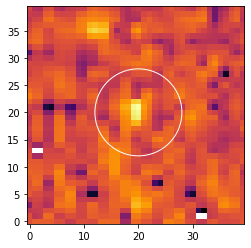

Mean: 52.14115524291992
Median: 50.247947692871094
Std dev: 18.81793212890625
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 20.155954648751326 ...  1.103156162496799 -0.10659248851227758
  2  19.41585494655014 ...  2.661841222638859   -1.062955366212201
  3 12.351200251191063 ... 1.5264606076495086   -0.459214003078363
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


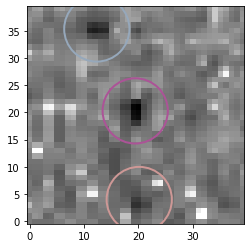

Time taken to fit PSF model: 0.03880540000045585s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


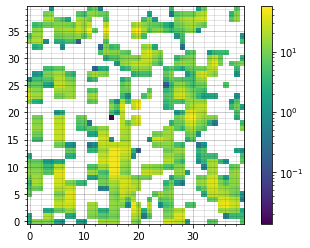

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.155955 ...    17.317096 0.097691522 109.19371
  2        2             1 19.415855 ...    16.392446 0.050685274 113.21299
  3        3             1   12.3512 ...    16.973651 0.063545131 90.531542
Median mag error:  0.06354513058770125
Median flux error: 109.19370784588702
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...          -- 17.317096 0.097691522
        1 19.655275 20.208865 663.16947 ... 0.048661253 16.392446 0.050685274
        2 12.940712  35.81612 656.45491 ...  0.18370916 16.973651 0.063545131




Epoch:  6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


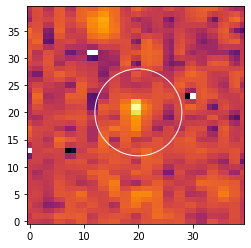

Mean: 52.97257614135742
Median: 51.252296447753906
Std dev: 19.382888793945312
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 13.254597567318706 ... 1.3827330976311347 -0.3518458960207996
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


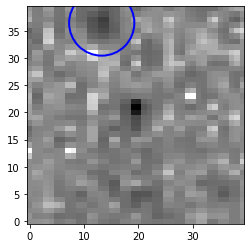

Time taken to fit PSF model: 0.03137509999942267s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


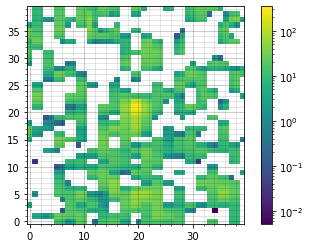

 id group_id iter_detected   x_fit    y_fit   apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- -------- ------------ ----------- ---------
  1        1             1 13.254598 36.43285    16.850569 0.067122223 108.62908
Median mag error:  0.06712222335294055
Median flux error: 108.62908260390445
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ... 0.097691522        --          --
        1 19.655275 20.208865 663.16947 ... 0.050685274        --          --
        2 12.940712  35.81612 656.45491 ... 0.063545131 16.850569 0.067122223




Epoch:  7


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


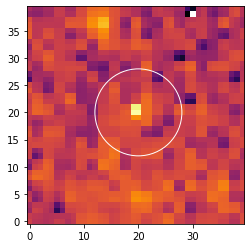

Mean: 52.517417907714844
Median: 51.56068420410156
Std dev: 20.030000686645508
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 13.061705060022526 ... 1.8077404294110588 -0.6428401773956225
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


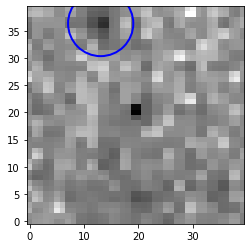

Time taken to fit PSF model: 0.03316069999982574s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


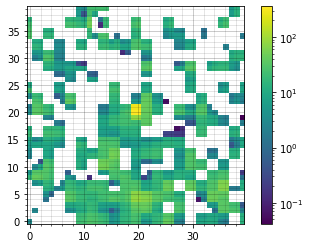

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 13.061705 ...    16.725011 0.060249087 106.24034
Median mag error:  0.060249087168168125
Median flux error: 106.2403439734973
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...          --        --          --
        1 19.655275 20.208865 663.16947 ...          --        --          --
        2 12.940712  35.81612 656.45491 ... 0.067122223 16.725011 0.060249087




Epoch:  8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


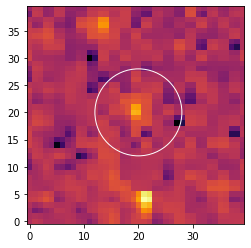

Mean: 51.8036003112793
Median: 49.6117057800293
Std dev: 19.660873413085938
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 13.269080711494867 ... 2.320369795444357 -0.9138930089113894
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


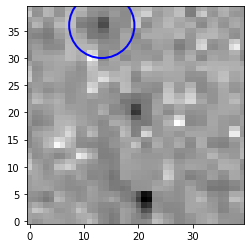

Time taken to fit PSF model: 0.030067000000599364s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


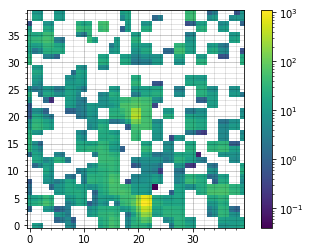

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- --------- ------------ ---------- ---------
  1        1             1 13.269081 35.992996    16.541126 0.05761429 118.56012
Median mag error:  0.057614289533656445
Median flux error: 118.56012430610888
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8    err_e8  
--------- --------- --------- --------- ... ----------- --------- ----------
        0 20.187335 3.9986989 663.70153 ...          --        --         --
        1 19.655275 20.208865 663.16947 ...          --        --         --
        2 12.940712  35.81612 656.45491 ... 0.060249087 16.541126 0.05761429




Epoch:  9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


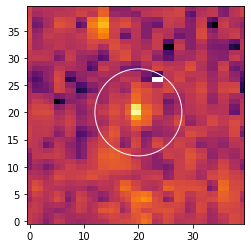

Mean: 49.13193130493164
Median: 47.70532989501953
Std dev: 18.257658004760742
sources_PSF:   id     xcentroid      ...        flux              mag        
--- ------------------ ... ----------------- ------------------
  1 13.127379663363852 ... 2.167839373683814 -0.840067749892915
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


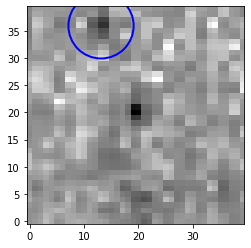

Time taken to fit PSF model: 0.02966779999951541s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


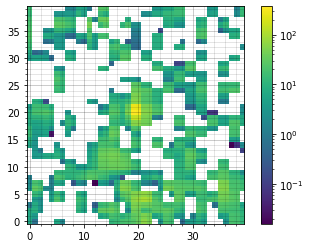

 id group_id iter_detected  x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- -------- --------- ------------ ---------- ---------
  1        1             1 13.12738 35.912639    16.845439 0.06571019 106.29846
Median mag error:  0.06571018959064247
Median flux error: 106.29845994634555
id_master    x_0       y_0      x_true  ...   err_e8     mag_e9    err_e9  
--------- --------- --------- --------- ... ---------- --------- ----------
        0 20.187335 3.9986989 663.70153 ...         --        --         --
        1 19.655275 20.208865 663.16947 ...         --        --         --
        2 12.940712  35.81612 656.45491 ... 0.05761429 16.845439 0.06571019




Epoch:  10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


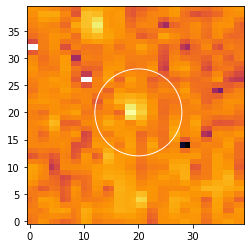

Mean: 50.765289306640625
Median: 48.901153564453125
Std dev: 19.777984619140625
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  18.86417034285683 ...  2.830971599050575 -1.1298387811154362
  2 12.078618933750208 ... 1.9527443882604345 -0.7266134960418714
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


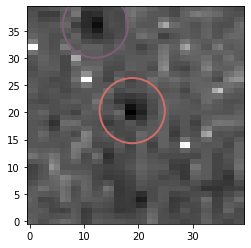

Time taken to fit PSF model: 0.034825699999601056s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


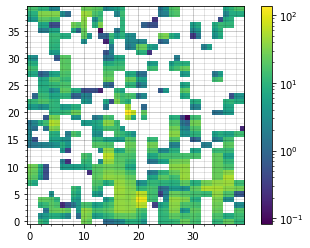

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1  18.86417 ...    16.384485 0.059709307 143.73874
  2        2             1 12.078619 ...    16.691365 0.054765483 96.295839
Median mag error:  0.0572373947365908
Median flux error: 120.0172894276256
id_master    x_0       y_0      x_true  ...   err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ---------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...         --        --          --
        1 19.655275 20.208865 663.16947 ...         -- 16.384485 0.059709307
        2 12.940712  35.81612 656.45491 ... 0.06571019 16.691365 0.054765483




Epoch:  11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


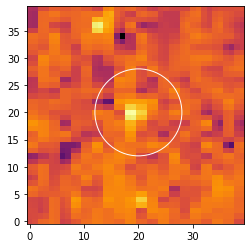

Mean: 48.25233840942383
Median: 47.778076171875
Std dev: 17.670995712280273
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 18.972821572594547 ... 3.1649697299393718 -1.2509239018525005
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


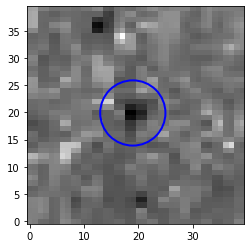

Time taken to fit PSF model: 0.030292499999632128s


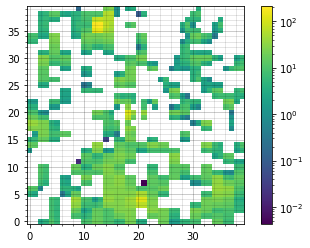

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 18.972822 ...    16.424964 0.059681594 138.37814
Median mag error:  0.05968159373642149
Median flux error: 138.37813931867765
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...          --        --          --
        1 19.655275 20.208865 663.16947 ... 0.059709307 16.424964 0.059681594
        2 12.940712  35.81612 656.45491 ... 0.054765483        --          --




Epoch:  12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


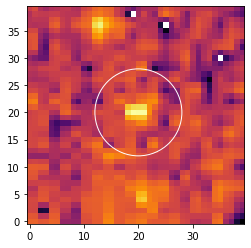

Mean: 49.28289031982422
Median: 47.419891357421875
Std dev: 19.30417823791504
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  19.83531749604216 ... 2.9083961154714904  -1.159133889793392
  2 12.919027796117616 ... 1.7909750339666064 -0.6327238296615095


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Number of PSF stars: 2


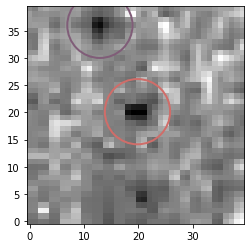

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.036123699999734527s


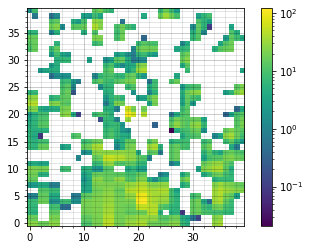

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 19.835317 ...    16.373045 0.051168755  116.9827
  2        2             1 12.919028 ...    16.780266 0.051233802 80.548936
Median mag error:  0.051201278748198964
Median flux error: 98.76581937183829
id_master    x_0       y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.187335 3.9986989 663.70153 ...          --        --          --
        1 19.655275 20.208865 663.16947 ... 0.059681594 16.373045 0.051168755
        2 12.940712  35.81612 656.45491 ...          -- 16.780266 0.051233802




Star ID:  1
star_name id_master     RA        dec        x_0       y_0      x_true    y_true    mag_e1     err_e1     mag_e2    err_e2     mag_e3     err_e3     mag_e4     err_e4     mag_e5     err_e5   mag_e6 err_e6 mag_e7 e

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
<ipython-input-58-9ebe035da547>:322: RuntimeWarning: invalid value encountered in double_scalars
  var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)


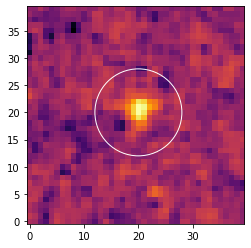

Mean: 41.1910400390625
Median: 40.50767135620117
Std dev: 9.343607902526855
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.184248533870043 ... 4.347160831203271 -1.5955142700262086
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


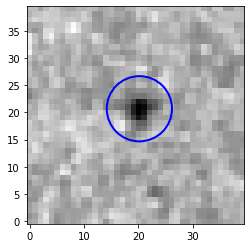

Time taken to fit PSF model: 0.02839750000021013s


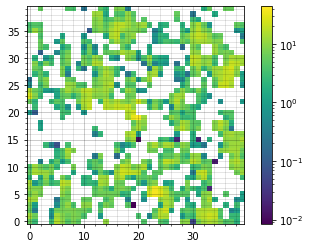

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.184249 ...    16.488126 0.041134214 69.321981
Median mag error:  0.041134214243343
Median flux error: 69.32198111369196
id_master    x_0       y_0      x_true  ...     dec       mag_e1     err_e1  
--------- --------- --------- --------- ... ----------- --------- -----------
        0  19.67092 20.501484 805.85132 ...  -0.1867933 16.488126 0.041134214
        1 18.429433 20.516267 804.60983 ... -0.18658878        --          --




Epoch:  2


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


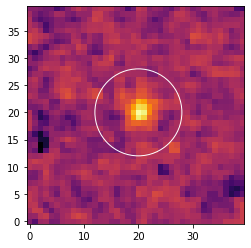

Mean: 41.06662368774414
Median: 40.62044143676758
Std dev: 9.673086166381836
sources_PSF:   id     xcentroid      ...       flux               mag        
--- ------------------ ... ---------------- -------------------
  1 20.302545816537748 ... 4.96309999361522 -1.7393825629871857
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


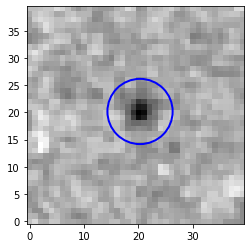

Time taken to fit PSF model: 0.029737500000010186s


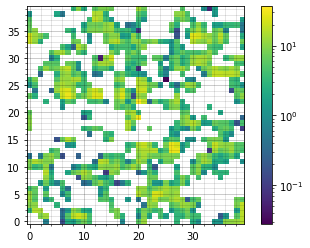

 id group_id iter_detected   x_fit    y_fit   apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- -------- ------------ ----------- ---------
  1        1             1 20.302546 20.16302    16.404194 0.038225285 63.497147
Median mag error:  0.03822528492663178
Median flux error: 63.497146517759916
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0  19.67092 20.501484 805.85132 ... 0.041134214 16.404194 0.038225285
        1 18.429433 20.516267 804.60983 ...          --        --          --




Epoch:  3


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


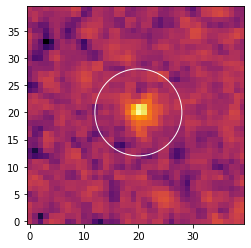

Mean: 40.812843322753906
Median: 40.469905853271484
Std dev: 9.863019943237305
sources_PSF:   id     xcentroid     ...        flux               mag        
--- ----------------- ... ----------------- -------------------
  1 20.28845305845713 ... 4.584357920943294 -1.6531962938983393
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


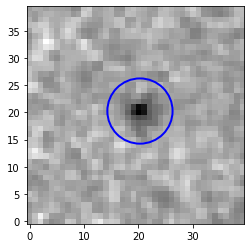

Time taken to fit PSF model: 0.03478050000012445s


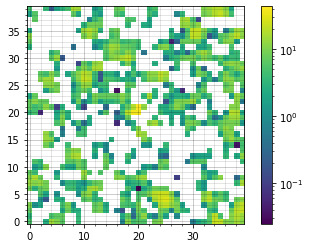

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.288453 ...    16.470037 0.041322784 71.161122
Median mag error:  0.04132278395396762
Median flux error: 71.16112243196092
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0  19.67092 20.501484 805.85132 ... 0.038225285 16.470037 0.041322784
        1 18.429433 20.516267 804.60983 ...          --        --          --




Epoch:  4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


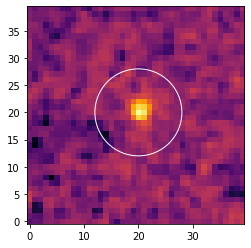

Mean: 39.424312591552734
Median: 39.08432388305664
Std dev: 9.061393737792969
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.189696216191784 ... 1.6460778665281655 -0.5411259383747863
  2  20.35603050280295 ...   5.24023062956456 -1.7983760032146157
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


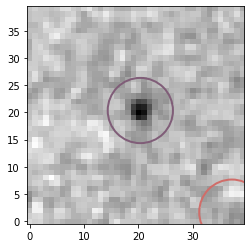

Time taken to fit PSF model: 0.03473699999995006s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


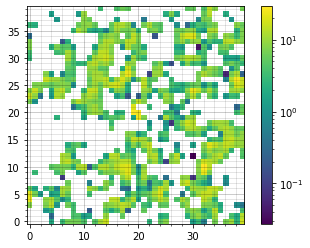

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 37.189696 ...    18.915939  0.22577725 57.906461
  2        2             1 20.356031 ...    16.477123 0.038109998 58.931487
Median mag error:  0.13194362454596517
Median flux error: 58.4189737266863
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0  19.67092 20.501484 805.85132 ... 0.041322784 16.477123 0.038109998
        1 18.429433 20.516267 804.60983 ...          --        --          --




Epoch:  5


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


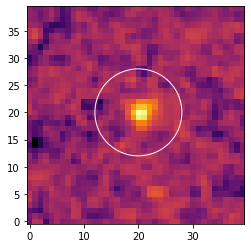

Mean: 39.289188385009766
Median: 39.28658676147461
Std dev: 9.431209564208984
sources_PSF:   id     xcentroid      ...        flux               mag         
--- ------------------ ... ----------------- --------------------
  1 36.922728061564754 ... 1.230882892517495 -0.22554183916671428
  2    20.529154949855 ... 4.945169728274697   -1.735453005145501
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


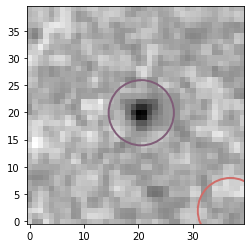

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.03442200000063167s


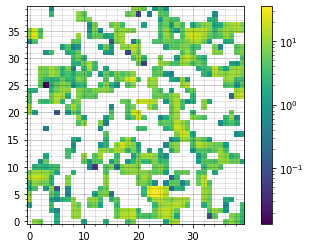

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 36.922728 ...    19.953468  0.57746406 57.376976
  2        2             1 20.529155 ...      16.4017 0.036279156 55.270899
Median mag error:  0.3068716091856902
Median flux error: 56.32393734951113
id_master    x_0       y_0      x_true  ...    err_e4    mag_e5    err_e5  
--------- --------- --------- --------- ... ----------- ------- -----------
        0  19.67092 20.501484 805.85132 ... 0.038109998 16.4017 0.036279156
        1 18.429433 20.516267 804.60983 ...          --      --          --




Epoch:  6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


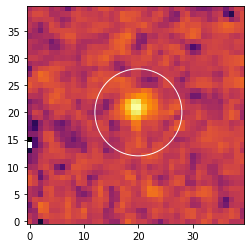

Mean: 38.47073745727539
Median: 38.32726287841797
Std dev: 9.754280090332031
sources_PSF:   id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
  1   3.16911169096195 ... 1.0029873968432728 -0.0032386896901033806
  2 19.587246752708765 ...  4.052158621527431    -1.5192160936367838
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


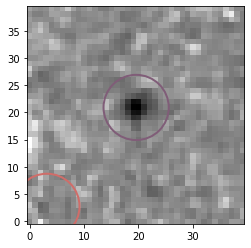

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.035179100000277685s


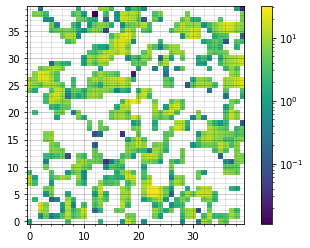

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 3.1691117 ...    19.621072  0.38466671 51.823319
  2        2             1 19.587247 ...     16.50151 0.038502668 59.093917
Median mag error:  0.21158469052680995
Median flux error: 55.45861816211031
id_master    x_0       y_0      x_true  ...    err_e5    mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- -------- -----------
        0  19.67092 20.501484 805.85132 ... 0.036279156 16.50151 0.038502668
        1 18.429433 20.516267 804.60983 ...          --       --          --




Epoch:  7


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


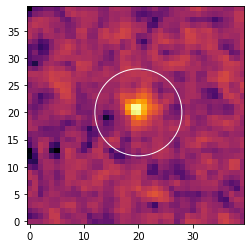

Mean: 40.33479309082031
Median: 39.90473937988281
Std dev: 9.760663032531738
sources_PSF:   id     xcentroid      ...       flux               mag        
--- ------------------ ... ---------------- -------------------
  1 19.783610264140115 ... 4.94201519188584 -1.7347601902521856
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


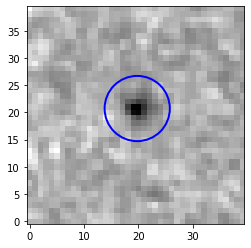

Time taken to fit PSF model: 0.03534399999989546s


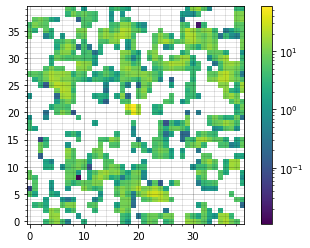

 id group_id iter_detected  x_fit     y_fit   apparent_mag   mag_err    flux_unc
--- -------- ------------- -------- --------- ------------ ----------- ---------
  1        1             1 19.78361 20.704409    16.375077 0.039467386 70.361091
Median mag error:  0.03946738564954715
Median flux error: 70.36109110482154
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ----------- --------- -----------
        0  19.67092 20.501484 805.85132 ... 0.038502668 16.375077 0.039467386
        1 18.429433 20.516267 804.60983 ...          --        --          --




Epoch:  8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


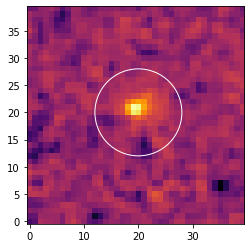

Mean: 39.11551284790039
Median: 38.919883728027344
Std dev: 9.143774032592773
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 37.226554336999016 ... 1.1636593459551872 -0.1645646547695194
  2 19.613780875528114 ... 5.0290554776926815 -1.7537160663454703
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


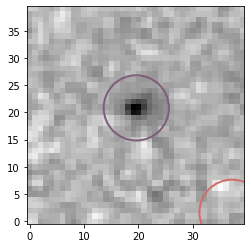

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04226139999991574s


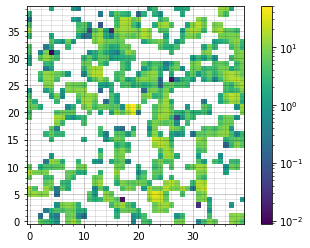

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 37.226554 ...    23.942024   25.255344 63.783562
  2        2             1 19.613781 ...    16.422928 0.039788151 68.564955
Median mag error:  12.647566161662915
Median flux error: 66.1742582663273
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0  19.67092 20.501484 805.85132 ... 0.039467386 16.422928 0.039788151
        1 18.429433 20.516267 804.60983 ...          --        --          --




Epoch:  9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


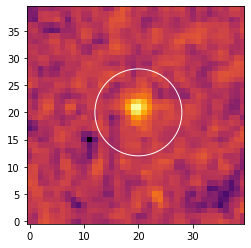

Mean: 36.97871398925781
Median: 36.53264236450195
Std dev: 8.8604736328125
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 19.792206443541197 ... 5.277498982675057 -1.8060703956557003
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


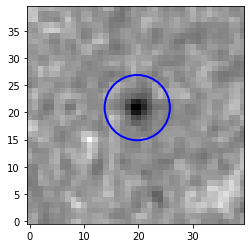

Time taken to fit PSF model: 0.029065300000183925s


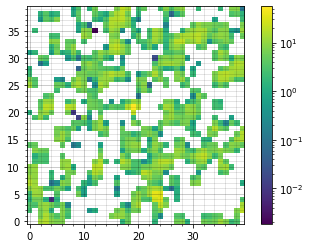

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- --------- ------------ ---------- ---------
  1        1             1 19.792206 20.870567    16.478821 0.03924129 63.120942
Median mag error:  0.03924128951184269
Median flux error: 63.1209420141933
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9    err_e9  
--------- --------- --------- --------- ... ----------- --------- ----------
        0  19.67092 20.501484 805.85132 ... 0.039788151 16.478821 0.03924129
        1 18.429433 20.516267 804.60983 ...          --        --         --




Epoch:  10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


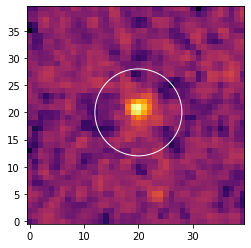

Mean: 38.34428024291992
Median: 38.0528564453125
Std dev: 8.979500770568848
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 19.964553696514795 ... 5.650993208708119 -1.8803119634215457
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


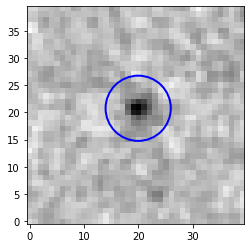

Time taken to fit PSF model: 0.03213229999983014s


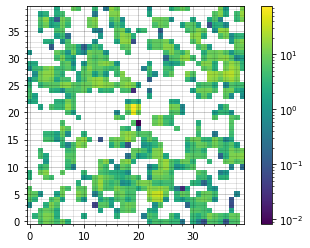

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- --------- ------------ ---------- ---------
  1        1             1 19.964554 20.750523    16.468134 0.04363377 79.217777
Median mag error:  0.043633770288091386
Median flux error: 79.21777720804971
id_master    x_0       y_0      x_true  ...   err_e9    mag_e10   err_e10  
--------- --------- --------- --------- ... ---------- --------- ----------
        0  19.67092 20.501484 805.85132 ... 0.03924129 16.468134 0.04363377
        1 18.429433 20.516267 804.60983 ...         --        --         --




Epoch:  11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


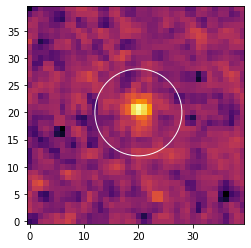

Mean: 37.05172348022461
Median: 36.484657287597656
Std dev: 9.482189178466797
sources_PSF:   id     xcentroid      ...        flux              mag        
--- ------------------ ... ----------------- ------------------
  1 20.129329291383527 ... 5.180028636314901 -1.785830401563453
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


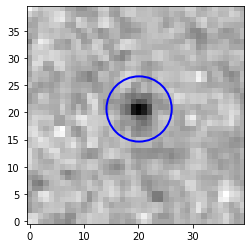

Time taken to fit PSF model: 0.029201800000009825s


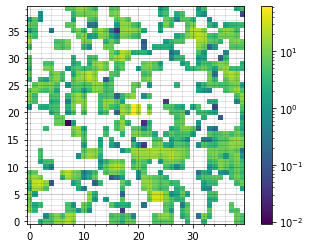

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.129329 ...    16.440117 0.043580997 81.101211
Median mag error:  0.04358099698404997
Median flux error: 81.10121119647687
id_master    x_0       y_0      x_true  ...  err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ---------- --------- -----------
        0  19.67092 20.501484 805.85132 ... 0.04363377 16.440117 0.043580997
        1 18.429433 20.516267 804.60983 ...         --        --          --




Epoch:  12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


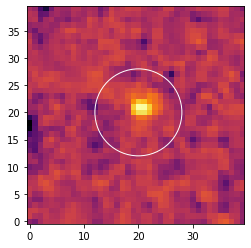

Mean: 38.045448303222656
Median: 37.903038024902344
Std dev: 9.053349494934082
sources_PSF:   id     xcentroid      ...        flux              mag        
--- ------------------ ... ----------------- ------------------
  1 20.597129726840482 ... 5.194408542124661 -1.788840260139645
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


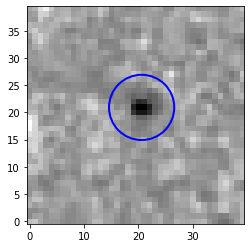

Time taken to fit PSF model: 0.030234500000005937s


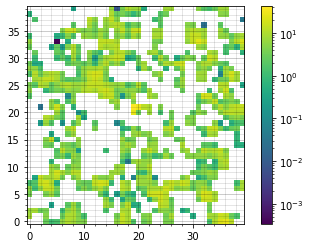

 id group_id iter_detected  x_fit     y_fit   apparent_mag   mag_err   flux_unc
--- -------- ------------- -------- --------- ------------ ----------- --------
  1        1             1 20.59713 20.911056     16.42368 0.038930374 65.19774
Median mag error:  0.038930373639117784
Median flux error: 65.19774042802375
id_master    x_0       y_0      x_true  ...   err_e11   mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- -------- -----------
        0  19.67092 20.501484 805.85132 ... 0.043580997 16.42368 0.038930374
        1 18.429433 20.516267 804.60983 ...          --       --          --




Star ID:  0
star_name id_master     RA       dec       x_0       y_0      x_true    y_true    mag_e1     err_e1     mag_e2     err_e2     mag_e3     err_e3     mag_e4     err_e4    mag_e5    err_e5    mag_e6     err_e6     mag_e7     err_e7     mag_e8     err_e8     mag_e9    err_e9    mag_e10   err_e10    mag_e11    err_e11   mag_e12    err_e12        eta_inv         

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


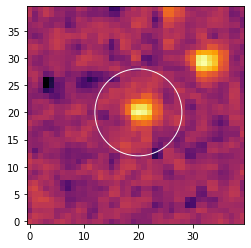

Mean: 44.90550994873047
Median: 43.761962890625
Std dev: 10.696414947509766
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.444834782069083 ...  4.72908145627392 -1.6869419865111868
  2  32.27852515492204 ... 5.072304903895771 -1.7630133793862013
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


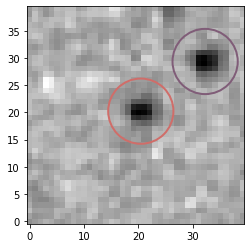

Time taken to fit PSF model: 0.047840700000051584s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


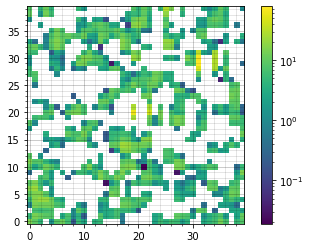

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.444835 ...    16.303062 0.041055907 84.277434
  2        2             1 32.278525 ...    16.280916 0.041640114 88.529662
  3        1             2 18.303832 ...    18.700728  0.23545875 75.821333
  5        2             2 26.064273 ...    18.012546 0.091912043 53.249843
Median mag error:  0.06677607847668711
Median flux error: 80.04938377914834
id_master    x_0       y_0      x_true  ...     dec        mag_e1     err_e1  
--------- --------- --------- --------- ... ------------ --------- -----------
        0 20.231591 20.286052 302.57711 ...  -0.09653026 16.303062 0.041055907
        0 20.231591 20.286052 302.57711 ...  -0.09653026 18.700728  0.23545875
        1 32.115161 29.274202 314.46068 ...  -0.09823849 16.280916 0.041640114
        2  25.77957 38.061387 308.12509 ... -0.096956716 18.012546 0.0919

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


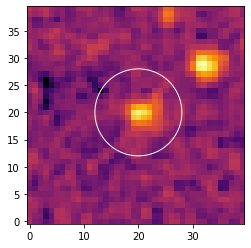

Mean: 43.960906982421875
Median: 42.729984283447266
Std dev: 11.130718231201172
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 20.422581398521828 ... 4.0375378088547675  -1.5152915055925487
  2  32.15570227246131 ...  4.922940281962182    -1.73056141892021
  3 37.084874776773276 ... 1.0164387375959556 -0.01770302033283288
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


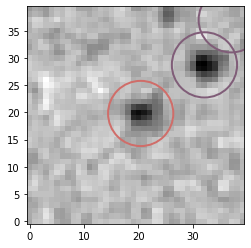

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.06569080000008398s


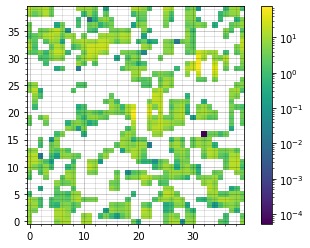

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.422581 ...    16.439086  0.04245055 79.507534
  2        2             1 32.155702 ...    16.268189 0.039409399 79.645215
  3        2             1 37.084875 ...    20.552711   1.3484809 79.494302
  4        1             2 25.511843 ...    17.741819 0.062395827 43.159728
Median mag error:  0.05242318836341814
Median flux error: 79.50091798260148
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.041055907 16.439086  0.04245055
        0 20.231591 20.286052 302.57711 ...  0.23545875 16.439086  0.04245055
        1 32.115161 29.274202 314.46068 ... 0.041640114 16.268189 0.039409399
        2  25.77957 38.061387 308.12509 ... 0.091912043 17.741819 0.062395827


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


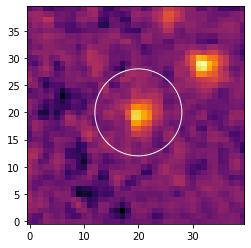

Mean: 43.27780532836914
Median: 42.302711486816406
Std dev: 10.88162612915039
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 20.024558137377337 ...   4.29798086430705   -1.583161193928373
  2  31.91421793387323 ...  5.367815441260516  -1.8244939382543999
  3  2.557326343390584 ... 1.0546418255819865 -0.05776247708292158
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


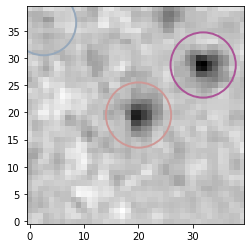

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.059328000000277825s


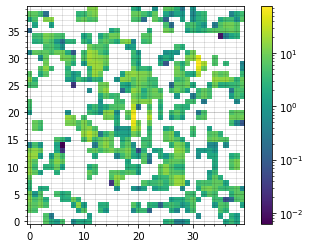

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.024558 ...     16.37231 0.042546348 84.940711
  2        2             1 31.914218 ...    16.234371 0.039789437 83.980008
  3        3             1 2.5573263 ...    19.390556  0.22102966  37.67946
  4        1             2 25.598566 ...    17.812153 0.052179254 31.669721
Median mag error:  0.047362800697426675
Median flux error: 60.82973405720654
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ...  0.04245055  16.37231 0.042546348
        0 20.231591 20.286052 302.57711 ...  0.04245055  16.37231 0.042546348
        1 32.115161 29.274202 314.46068 ... 0.039409399 16.234371 0.039789437
        2  25.77957 38.061387 308.12509 ... 0.062395827 17.812153 0.052179254

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


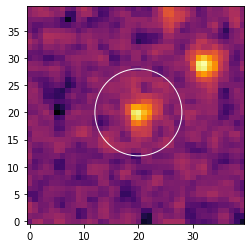

Mean: 41.797607421875
Median: 40.40817642211914
Std dev: 10.522560119628906
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1  20.07336729532498 ... 5.102704993454192 -1.7695011521560542
  2 32.032590262736825 ... 5.939076071238465 -1.9342972200403041
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


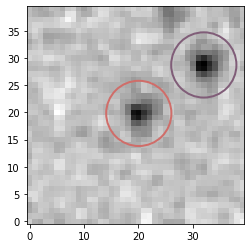

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04330400000071677s


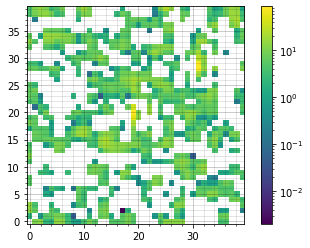

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.073367 ...    16.359377 0.041539966 81.979876
  2        2             1  32.03259 ...    16.198474 0.039997658  87.79705
  3        1             2 25.860616 ...    17.731084 0.066835545 47.551344
Median mag error:  0.04153996588298395
Median flux error: 81.97987576620255
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.042546348 16.359377 0.041539966
        0 20.231591 20.286052 302.57711 ... 0.042546348 16.359377 0.041539966
        1 32.115161 29.274202 314.46068 ... 0.039789437 16.198474 0.039997658
        2  25.77957 38.061387 308.12509 ... 0.052179254 17.731084 0.066835545




Epoch:  5


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


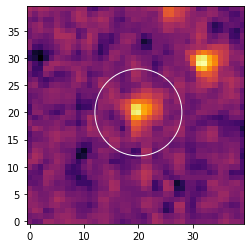

Mean: 42.724552154541016
Median: 41.254329681396484
Std dev: 11.176939964294434
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.972348117673704 ...  4.371402281951943 -1.6015519366043582
  2  32.00666773088337 ... 5.4402168087204625 -1.8390405199047544
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


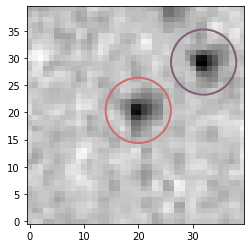

Time taken to fit PSF model: 0.04964509999990696s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


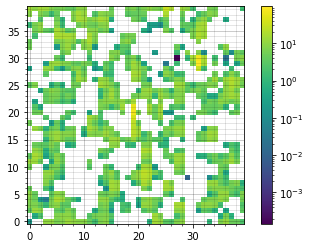

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 19.972348 ...    16.301271 0.042516197 90.526732
  2        2             1 32.006668 ...    16.255447  0.04269748  95.20522
  3        1             2 26.067923 ...    17.760294 0.069955741  48.94894
Median mag error:  0.04269748001889385
Median flux error: 90.52673156870742
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.041539966 16.301271 0.042516197
        0 20.231591 20.286052 302.57711 ... 0.041539966 16.301271 0.042516197
        1 32.115161 29.274202 314.46068 ... 0.039997658 16.255447  0.04269748
        2  25.77957 38.061387 308.12509 ... 0.066835545 17.760294 0.069955741




Epoch:  6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


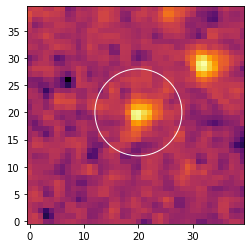

Mean: 41.9035758972168
Median: 40.82913589477539
Std dev: 11.156750679016113
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 20.141966962817715 ...  4.755150449605161   -1.6929106556544904
  2 31.998939542311245 ...  4.985420456704148   -1.7442544784979208
  3 1.9845386163883871 ... 1.0468715841477423 -0.049733529133943945
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


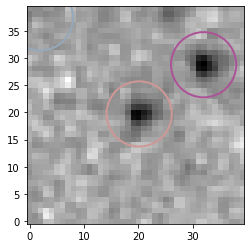

Time taken to fit PSF model: 0.05141249999996944s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

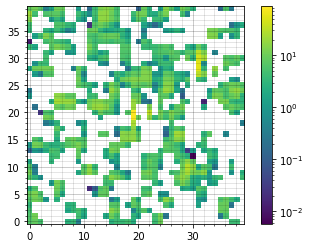

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.141967 ...    16.335848 0.043527233  91.70046
  2        2             1  31.99894 ...    16.295995 0.039514604 78.116127
  3        3             1 1.9845386 ...    19.386382  0.24986113 42.839702
  4        1             2 25.790639 ...    17.912252 0.068508243 41.494412
Median mag error:  0.05601773786705878
Median flux error: 60.47791462255471
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.042516197 16.335848 0.043527233
        0 20.231591 20.286052 302.57711 ... 0.042516197 16.335848 0.043527233
        1 32.115161 29.274202 314.46068 ...  0.04269748 16.295995 0.039514604
        2  25.77957 38.061387 308.12509 ... 0.069955741 17.912252 0.068508243


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


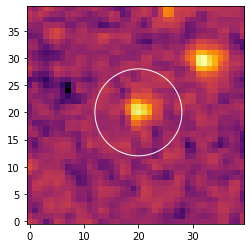

Mean: 42.57255935668945
Median: 41.776432037353516
Std dev: 10.334551811218262
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 20.083064616714918 ...  4.877855619170439   -1.7205723534510682
  2  32.12444798007859 ...  5.189751964498098    -1.787866504917912
  3 2.2147915211828564 ... 1.0583978152633897 -0.061622336782621384
Number of PSF stars: 3

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


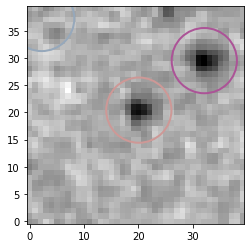

Time taken to fit PSF model: 0.04959390000021813s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

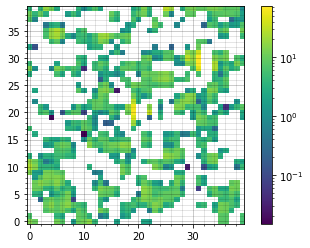

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.083065 ...    16.407708  0.04223893 81.057253
  2        2             1 32.124448 ...    16.222114 0.040908346 90.150236
  3        3             1 2.2147915 ...    20.626115  0.97080509 53.483585
  4        1             2 25.529061 ...    17.677187 0.081025885 62.886352
Median mag error:  0.06163240747946136
Median flux error: 71.97180256900639
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.043527233 16.407708  0.04223893
        0 20.231591 20.286052 302.57711 ... 0.043527233 16.407708  0.04223893
        1 32.115161 29.274202 314.46068 ... 0.039514604 16.222114 0.040908346
        2  25.77957 38.061387 308.12509 ... 0.068508243 17.677187 0.081025885


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


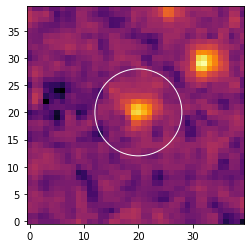

Mean: 41.62046813964844
Median: 40.464881896972656
Std dev: 10.862074851989746
sources_PSF: 

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


  id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 20.022265213361717 ...   4.34867721642056  -1.5958929326320304
  2  31.95663192279602 ...  5.818383563473817   -1.912005869284018
  3 36.967620622232076 ... 1.1510914357977868 -0.15277455687035466
  4 1.6872110682679584 ...  1.114299349566671 -0.11750469253585796
Number of PSF stars: 4


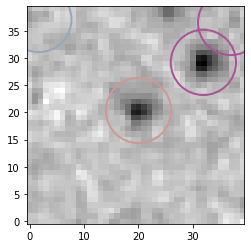

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
WARNING

Time taken to fit PSF model: 0.05785649999961606s


: NoDetectionsWarning: Sources were found, but none pass the sharpness and roundness criteria. [photutils.detection.findstars]


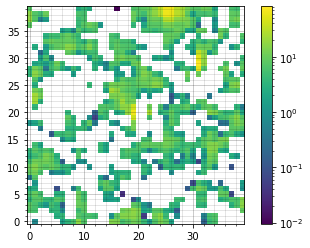

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.022265 ...    16.418339  0.04103205 75.726467
  2        2             1 31.956632 ...    16.165789 0.038499182 82.863238
  3        2             1 36.967621 ...    19.378878  0.50530328 87.707501
  4        3             1 1.6872111 ...    20.308971   0.6293065 46.405967
Median mag error:  0.27316766384883284
Median flux error: 79.29485254276257
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ...  0.04223893 16.418339  0.04103205
        0 20.231591 20.286052 302.57711 ...  0.04223893 16.418339  0.04103205
        1 32.115161 29.274202 314.46068 ... 0.040908346 16.165789 0.038499182
        2  25.77957 38.061387 308.12509 ... 0.081025885        --          --


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


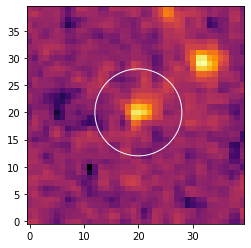

Mean: 39.96250534057617
Median: 38.920448303222656
Std dev: 10.669486999511719


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


sources_PSF:   id     xcentroid     ...        flux               mag        
--- ----------------- ... ----------------- -------------------
  1  20.0527123438937 ... 4.840386298332431 -1.7122000572822282
  2 31.94680213444372 ...  5.57973449241853 -1.8665338346105567
Number of PSF stars: 2


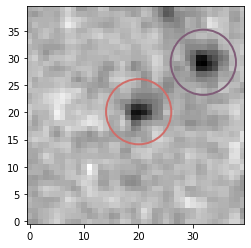

Time taken to fit PSF model: 0.03351440000005823s


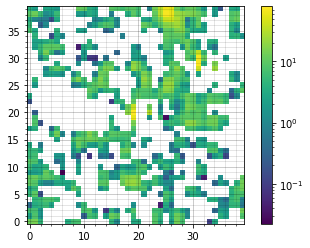

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.052712 ...    16.468705 0.044117984 83.175023
  2        2             1 31.946802 ...    16.230919 0.040705263 88.505882
Median mag error:  0.04241162350546974
Median flux error: 85.84045230548574
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ...  0.04103205 16.468705 0.044117984
        0 20.231591 20.286052 302.57711 ...  0.04103205 16.468705 0.044117984
        1 32.115161 29.274202 314.46068 ... 0.038499182 16.230919 0.040705263
        2  25.77957 38.061387 308.12509 ...          --        --          --




Epoch:  10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


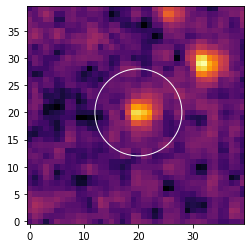

Mean: 41.20863342285156
Median: 39.83292770385742
Std dev: 10.938182830810547


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.191750143351324 ... 4.754825773404679 -1.6928365203049256
  2   32.0101662853822 ... 5.451926398292612 -1.8413749604271599
Number of PSF stars: 2


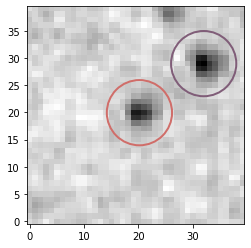

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.049134500000036496s


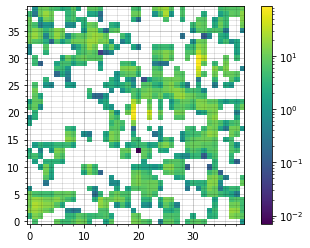

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1  20.19175 ...    16.410049 0.042586567 82.186013
  2        2             1 32.010166 ...    16.243326 0.042620235 95.972594
  3        1             2 25.883383 ...    17.592046  0.06537659 52.584419
Median mag error:  0.04262023455593618
Median flux error: 82.1860126607938
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.044117984 16.410049 0.042586567
        0 20.231591 20.286052 302.57711 ... 0.044117984 16.410049 0.042586567
        1 32.115161 29.274202 314.46068 ... 0.040705263 16.243326 0.042620235
        2  25.77957 38.061387 308.12509 ...          -- 17.592046  0.06537659




Epoch:  11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


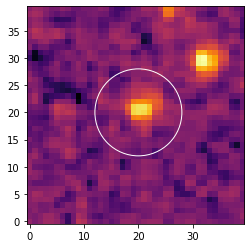

Mean: 40.00929260253906
Median: 39.08040237426758
Std dev: 10.006063461303711
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 20.447644646272202 ...  4.583380624424266   -1.6529648112459359
  2  32.08298892445045 ...  5.498526487580283   -1.8506158037121636
  3 1.7930920311213092 ... 1.0093369199500117 -0.010090398374625532
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


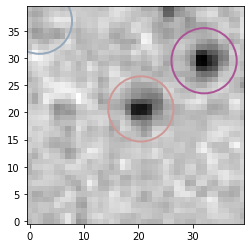

Time taken to fit PSF model: 0.04965749999973923s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


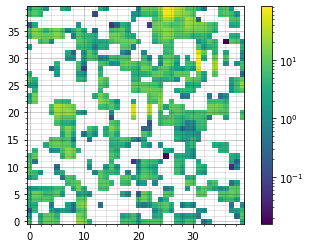

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.447645 ...    16.390902 0.042139707 81.929358
  2        2             1 32.082989 ...    16.237206 0.042772791 97.153531
  3        3             1  1.793092 ...     19.59117  0.35163036 50.089248
  4        1             2 18.251429 ...    18.780096   0.2524875 75.661379
Median mag error:  0.14763014329273433
Median flux error: 78.79536877764593
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.042586567 16.390902 0.042139707
        0 20.231591 20.286052 302.57711 ... 0.042586567 18.780096   0.2524875
        0 20.231591 20.286052 302.57711 ... 0.042586567 16.390902 0.042139707
        0 20.231591 20.286052 302.57711 ... 0.042586567 18.780096   0.2524875


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


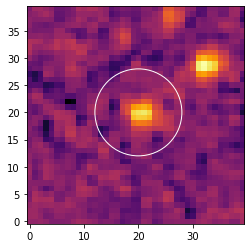

Mean: 39.46736145019531
Median: 38.0761604309082
Std dev: 10.827217102050781


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.600752869675308 ...  4.172872794265759 -1.5510878647324962
  2  32.33979029521615 ...  5.221828291502511 -1.7945564672241066
  3 25.924547345848435 ... 1.8475666433874678 -0.6665002818531245
Number of PSF stars: 3


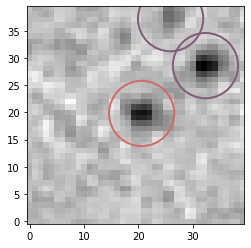

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05740020000030199s


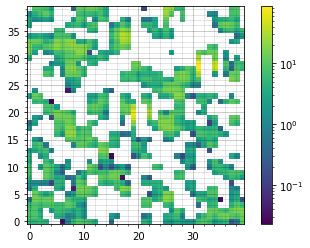

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.600753 ...     16.37287  0.04144216 80.608598
  2        2             1  32.33979 ...    16.243752 0.039470612 81.780858
  3        2             1 25.924547 ...    17.812076  0.11720839 83.514133
Median mag error:  0.04144215977850052
Median flux error: 81.78085787879185
id_master    x_0       y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 20.231591 20.286052 302.57711 ... 0.042139707  16.37287  0.04144216
        0 20.231591 20.286052 302.57711 ...   0.2524875  16.37287  0.04144216
        0 20.231591 20.286052 302.57711 ... 0.042139707  16.37287  0.04144216
        0 20.231591 20.286052 302.57711 ...   0.2524875  16.37287  0.04144216
        1 32.115161 29.274202 314.46068 ... 0.042772791 16.243752 0.03947061

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


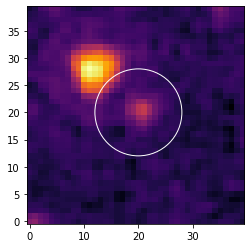

Mean: 57.89399719238281
Median: 51.57039260864258
Std dev: 25.343494415283203
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.4949419001289497 ... 1.2357488462521535 -0.22982553414286516
  2  20.56865465899896 ...  2.843669423334152  -1.1346977706098889
  3 11.496773133055456 ... 49.390394250470266    -4.23410623214412
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


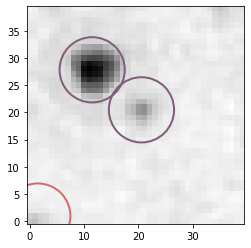

Time taken to fit PSF model: 0.04424459999972896s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


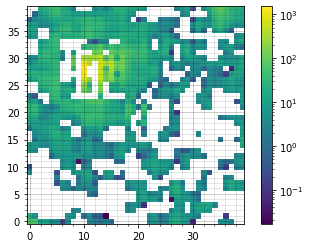

 id group_id iter_detected   x_fit   ... apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ---------- ---------
  1        1             1 1.4949419 ...    17.492983 0.12810715 122.47334
  2        2             1 20.568655 ...    15.891554 0.31408755 1342.8046
  3        2             1 11.496773 ...    12.728925 0.03416179 1358.9963
Median mag error:  0.12810715024768843
Median flux error: 1342.8045549660626
id_master    x_0       y_0       x_true  ...     dec        mag_e1    err_e1  
--------- --------- ---------- --------- ... ------------ --------- ----------
        0 1.6913981 0.86866289 240.59906 ... -0.087292566 17.492983 0.12810715
        1 20.479184  20.254612 259.38685 ... -0.089851827 15.891554 0.31408755
        2 11.394109  27.633949 250.30177 ... -0.088156468 12.728925 0.03416179




Epoch:  2


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


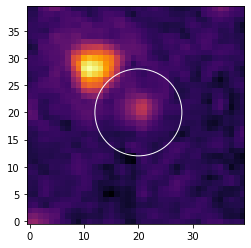

Mean: 56.47039794921875
Median: 50.0404052734375
Std dev: 23.999080657958984
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  1.563007195444044 ... 1.5059382201466132 -0.4445178891574487
  2  20.41947661309858 ... 2.7854023088613253 -1.1122198281280768
  3 11.413817812633479 ...  57.23594204525976  -4.394172088146316
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


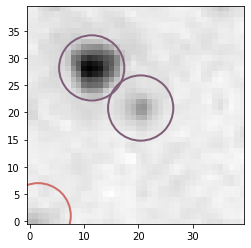

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.040064300000267394s


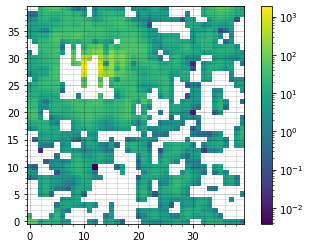

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.5630072 ...    17.080712 0.091790055 124.81388
  2        2             1 20.419477 ...    15.936556  0.32205522 1321.1076
  3        2             1 11.413818 ...    12.697462 0.033775582 1335.2545
Median mag error:  0.09179005467830097
Median flux error: 1321.1075518792754
id_master    x_0       y_0       x_true  ...   err_e1     mag_e2     err_e2  
--------- --------- ---------- --------- ... ---------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ... 0.12810715 17.080712 0.091790055
        1 20.479184  20.254612 259.38685 ... 0.31408755 15.936556  0.32205522
        2 11.394109  27.633949 250.30177 ... 0.03416179 12.697462 0.033775582




Epoch:  3


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


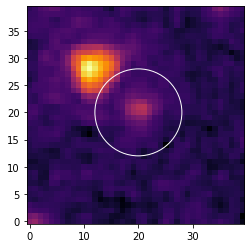

Mean: 56.743717193603516
Median: 50.717018127441406
Std dev: 25.24764633178711


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.4200147879032297 ... 1.4591224070389008 -0.4102293169022887
  2 20.177232248235054 ...  2.639482904189811 -1.0537971336014191
  3 11.194286242225168 ...   59.7801047180793  -4.441391678666994
Number of PSF stars: 3


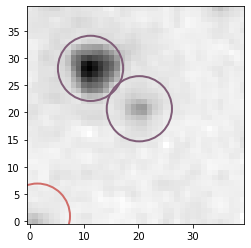

Time taken to fit PSF model: 0.04139810000015132s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


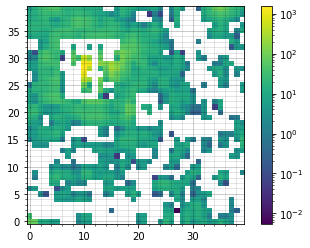

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.4200148 ...    17.190577   0.1075081 134.44761
  2        2             1 20.177232 ...    15.938442  0.31177829 1279.0293
  3        2             1 11.194286 ...    12.709194 0.033391311 1258.6206
Median mag error:  0.1075080951590396
Median flux error: 1258.6205642027746
id_master    x_0       y_0       x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ... 0.091790055 17.190577   0.1075081
        1 20.479184  20.254612 259.38685 ...  0.32205522 15.938442  0.31177829
        2 11.394109  27.633949 250.30177 ... 0.033775582 12.709194 0.033391311




Epoch:  4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


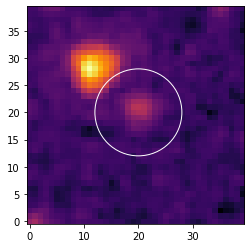

Mean: 54.0064582824707
Median: 48.10822296142578
Std dev: 24.215898513793945
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.5429740587691008 ... 1.5556507636867531 -0.4797802662948284
  2 20.079577289810793 ...  2.719036272733954  -1.086037503101818
  3 11.234829091643173 ...  66.35733975240701  -4.554722417385921
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


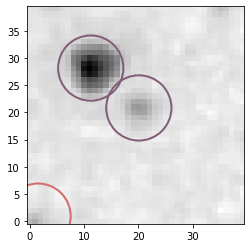

Time taken to fit PSF model: 0.04004220000024361s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


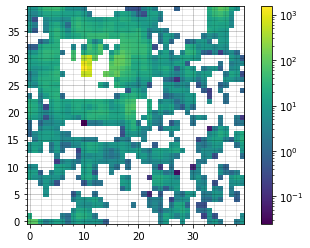

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.5429741 ...    17.084164 0.099321467 135.76561
  2        2             1 20.079577 ...    15.994236  0.30376816 1181.0946
  3        2             1 11.234829 ...    12.656535  0.03277599 1203.2315
Median mag error:  0.09932146745542841
Median flux error: 1181.0945519887564
id_master    x_0       y_0       x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ...   0.1075081 17.084164 0.099321467
        1 20.479184  20.254612 259.38685 ...  0.31177829 15.994236  0.30376816
        2 11.394109  27.633949 250.30177 ... 0.033391311 12.656535  0.03277599




Epoch:  5


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


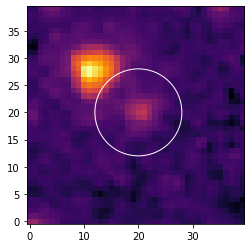

Mean: 55.29530334472656
Median: 49.19749069213867
Std dev: 26.96257781982422
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 1.5748743287899476 ... 1.0239380759059216 -0.025684232162167687
  2 20.429579150377258 ...  2.318251393257309   -0.9129013236596513
  3  11.23317720230305 ...  57.73296477125367    -4.403559651183536
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


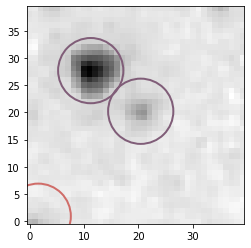

Time taken to fit PSF model: 0.042753600000651204s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


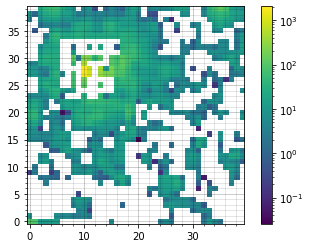

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.5748743 ...    17.527758  0.14438663 134.48267
  2        2             1 20.429579 ...    15.959414  0.37351317 1502.0876
  3        2             1 11.233177 ...    12.660592 0.034232256 1459.0482
Median mag error:  0.14438662943025024
Median flux error: 1459.048169393004
id_master    x_0       y_0       x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ... 0.099321467 17.527758  0.14438663
        1 20.479184  20.254612 259.38685 ...  0.30376816 15.959414  0.37351317
        2 11.394109  27.633949 250.30177 ...  0.03277599 12.660592 0.034232256




Epoch:  6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


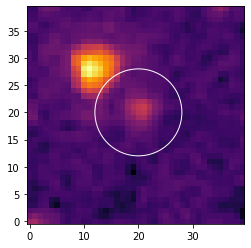

Mean: 53.85821533203125
Median: 48.10194396972656
Std dev: 24.80415153503418
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.5706237866315422 ... 1.2615154931889465 -0.25223147158730896
  2 20.411687840220665 ... 2.5798312129776364   -1.028978232281784
  3 11.279558715992353 ... 60.985316697454046   -4.463063208638242
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


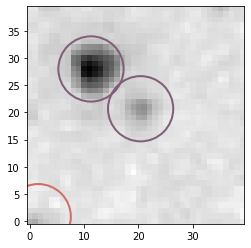

Time taken to fit PSF model: 0.04092149999996764s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


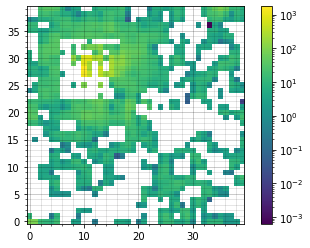

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.5706238 ...    17.398087  0.13433115 140.51727
  2        2             1 20.411688 ...    15.938731  0.33871793 1387.4809
  3        2             1 11.279559 ...    12.690462 0.033957369 1374.5119
Median mag error:  0.13433115206409812
Median flux error: 1374.511880452569
id_master    x_0       y_0       x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ...  0.14438663 17.398087  0.13433115
        1 20.479184  20.254612 259.38685 ...  0.37351317 15.938731  0.33871793
        2 11.394109  27.633949 250.30177 ... 0.034232256 12.690462 0.033957369




Epoch:  7


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


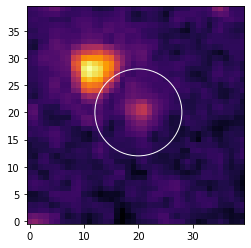

Mean: 55.796817779541016
Median: 49.45829772949219
Std dev: 25.801448822021484
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  20.45958973348053 ...  2.581333979990904 -1.0296104959426924
  2 11.404867770448579 ... 51.725728132862386  -4.284266532146194
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


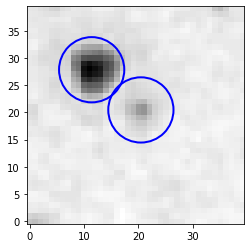

Time taken to fit PSF model: 0.13975140000002284s


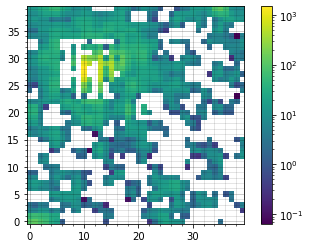

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1  20.45959 ...    15.936029  0.32811386 1347.3166
  2        1             1 11.404868 ...    12.720965 0.034104356 1360.2315
Median mag error:  0.18110910977758515
Median flux error: 1353.7740581291096
id_master    x_0       y_0       x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ...  0.13433115        --          --
        1 20.479184  20.254612 259.38685 ...  0.33871793 15.936029  0.32811386
        2 11.394109  27.633949 250.30177 ... 0.033957369 12.720965 0.034104356




Epoch:  8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


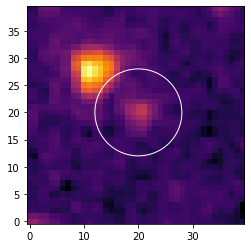

Mean: 54.06906509399414
Median: 48.253684997558594
Std dev: 24.30376625061035
sources_PSF:   id     xcentroid     ...        flux                mag         
--- ----------------- ... ------------------ --------------------
  1  1.60169794973137 ... 1.1186059147923844 -0.12169277848473671
  2 20.29062914761524 ... 2.8094344058027843  -1.1215472417887664
  3  11.2137442390644 ...  59.16124043905984   -4.430093178279646
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


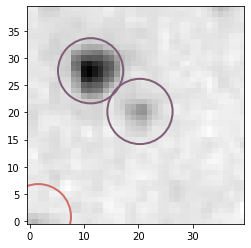

Time taken to fit PSF model: 0.0445028000003731s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


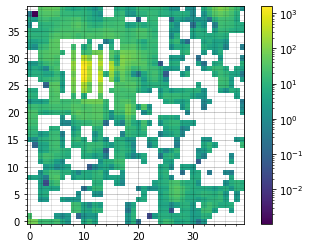

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.6016979 ...    17.546624   0.1372356  125.3693
  2        2             1 20.290629 ...    15.945856  0.36220882 1475.1361
  3        2             1 11.213744 ...    12.698918 0.034601083 1467.2637
Median mag error:  0.13723560072526067
Median flux error: 1467.2637103495674
id_master    x_0       y_0       x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ...          -- 17.546624   0.1372356
        1 20.479184  20.254612 259.38685 ...  0.32811386 15.945856  0.36220882
        2 11.394109  27.633949 250.30177 ... 0.034104356 12.698918 0.034601083




Epoch:  9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


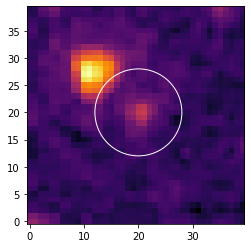

Mean: 52.478736877441406
Median: 45.80104064941406
Std dev: 24.350156784057617
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  1.475883519951304 ...  1.171244115832229 -0.17161855516538682
  2  20.44922505929035 ... 2.8630747982132023  -1.1420817354285302
  3 11.207036587142442 ... 57.257473966381504   -4.394580460739429
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


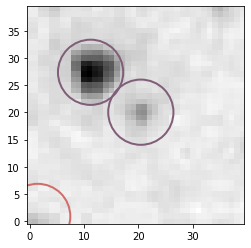

Time taken to fit PSF model: 0.03819409999960044s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


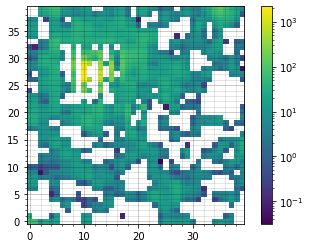

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.4758835 ...    17.472232  0.12833357 125.12266
  2        2             1 20.449225 ...    15.907345  0.43654492 1844.1236
  3        2             1 11.207037 ...    12.717135 0.037120465 1799.2324
Median mag error:  0.1283335732176986
Median flux error: 1799.2323784175037
id_master    x_0       y_0       x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ...   0.1372356 17.472232  0.12833357
        1 20.479184  20.254612 259.38685 ...  0.36220882 15.907345  0.43654492
        2 11.394109  27.633949 250.30177 ... 0.034601083 12.717135 0.037120465




Epoch:  10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


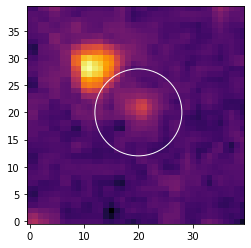

Mean: 52.91129684448242
Median: 46.790061950683594
Std dev: 24.845218658447266
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.5055984910871771 ... 1.4554266699071483 -0.4074758221750436
  2  20.45573736091337 ... 2.5091855094802287 -0.9988319270662506
  3 11.281239256344733 ...  57.49268687228416  -4.399031513767453
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


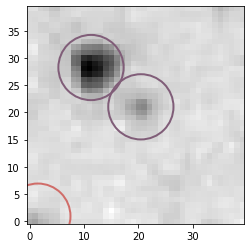

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.03890529999989667s


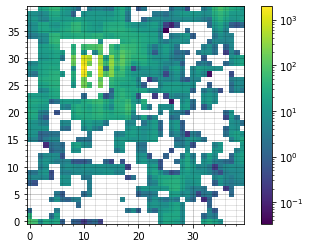

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.5055985 ...      17.1131 0.097886756 130.11713
  2        2             1 20.455737 ...    15.949551  0.39826893 1617.0301
  3        2             1 11.281239 ...    12.703611 0.035315386 1568.5709
Median mag error:  0.09788675587312538
Median flux error: 1568.5709482837979
id_master    x_0       y_0       x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ...  0.12833357   17.1131 0.097886756
        1 20.479184  20.254612 259.38685 ...  0.43654492 15.949551  0.39826893
        2 11.394109  27.633949 250.30177 ... 0.037120465 12.703611 0.035315386




Epoch:  11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


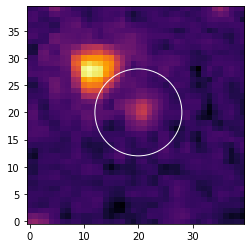

Mean: 53.458160400390625
Median: 47.201446533203125
Std dev: 26.061279296875
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  1.669068578793114 ...  1.052189110278082 -0.05523450679053431
  2 20.547900631769053 ... 2.5021143298387223  -0.9957678753875641
  3  11.47860193429362 ...  52.26982323405254   -4.295627578510811
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


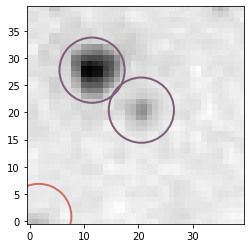

Time taken to fit PSF model: 0.04216519999954471s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


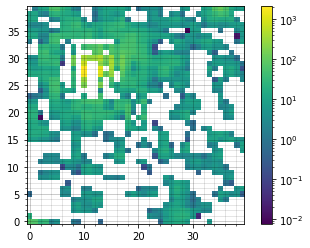

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.6690686 ...    17.543082  0.12557906 114.51977
  2        2             1 20.547901 ...    15.949902  0.37775135  1532.696
  3        2             1 11.478602 ...    12.694068 0.034989135 1533.2853
Median mag error:  0.1255790632056496
Median flux error: 1532.695999166182
id_master    x_0       y_0       x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ... 0.097886756 17.543082  0.12557906
        1 20.479184  20.254612 259.38685 ...  0.39826893 15.949902  0.37775135
        2 11.394109  27.633949 250.30177 ... 0.035315386 12.694068 0.034989135




Epoch:  12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


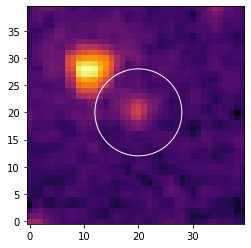

Mean: 52.474029541015625
Median: 46.477294921875
Std dev: 25.982410430908203
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.6237849441657835 ... 1.1252027561678246 -0.12807696823124512
  2 19.719048514004353 ... 2.8485042362003434  -1.1365421741535613
  3 10.762997892454564 ... 54.412591268290996   -4.339248521561439

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



Number of PSF stars: 3


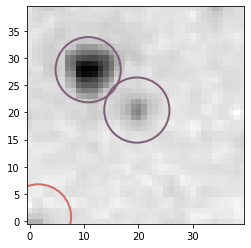

Time taken to fit PSF model: 0.04272239999954763s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


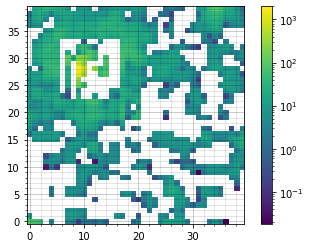

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 1.6237849 ...    17.533347   0.1448482 134.28048
  2        2             1 19.719049 ...      15.8424  0.28915031 1292.8255
  3        2             1 10.762998 ...    12.682008 0.033265504 1266.0236
Median mag error:  0.1448482026948881
Median flux error: 1266.0236241843497
id_master    x_0       y_0       x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- ---------- --------- ... ----------- --------- -----------
        0 1.6913981 0.86866289 240.59906 ...  0.12557906 17.533347   0.1448482
        1 20.479184  20.254612 259.38685 ...  0.37775135   15.8424  0.28915031
        2 11.394109  27.633949 250.30177 ... 0.034989135 12.682008 0.033265504




Star ID:  1
star_name id_master    RA        dec         x_0       y_0      x_true    y_true    mag_e1    err_e1     mag_e2    err_e2     mag_e3 

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


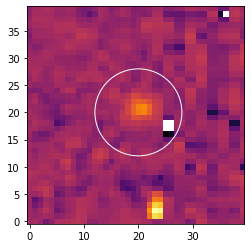

Mean: 41.62937927246094
Median: 40.80889892578125
Std dev: 13.432206153869629
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.429990168453322 ... 4.051742113570158 -1.5191044886741956
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


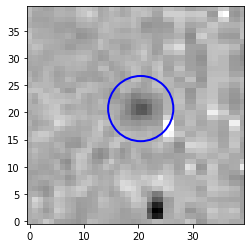

Time taken to fit PSF model: 0.029982699999891338s


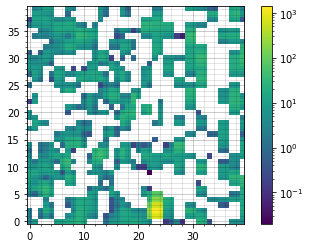

 id group_id iter_detected  x_fit     y_fit   apparent_mag   mag_err    flux_unc
--- -------- ------------- -------- --------- ------------ ----------- ---------
  1        1             1 20.42999 20.695309    16.264084 0.040828429 87.651549
Median mag error:  0.04082842911269111
Median flux error: 87.65154910544864
id_master    x_0       y_0      x_true  ...     dec       mag_e1     err_e1  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ... -0.27636541        --          --
        1 20.254074 20.788959 1301.5036 ... -0.27310464 16.264084 0.040828429




Epoch:  2


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


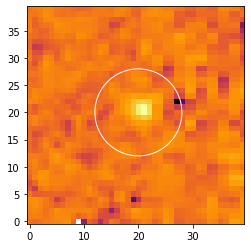

Mean: 42.366851806640625
Median: 41.74395751953125
Std dev: 12.987741470336914
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 37.391731777784564 ... 1.2552222051374586 -0.24680153351254747
  2 20.760564068086985 ... 3.9859719163206466  -1.5013355862436226
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


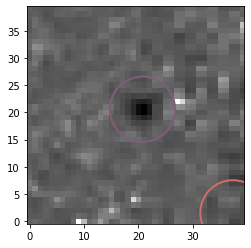

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.03495810000003985s


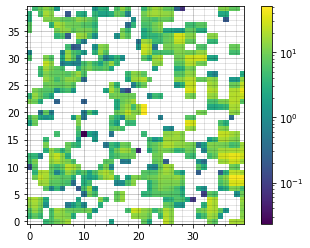

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 37.391732 ...    18.771528  0.25463819 78.077239
  2        2             1 20.760564 ...    16.327979 0.041763448 86.572622
Median mag error:  0.14820082006131408
Median flux error: 82.32493025302871
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...          -- 18.771528  0.25463819
        1 20.254074 20.788959 1301.5036 ... 0.040828429 16.327979 0.041763448




Epoch:  3


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


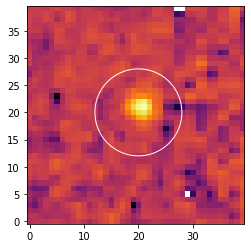

Mean: 40.69607162475586
Median: 40.75160598754883
Std dev: 12.479780197143555
sources_PSF:   id     xcentroid     ...        flux               mag         
--- ----------------- ... ----------------- --------------------
  1 20.60864894100017 ... 5.668778726794385  -1.8837237630420351
  2 36.82445718796845 ... 1.301856509828038 -0.28640779770784686
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


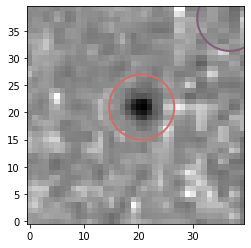

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.1263687000000573s


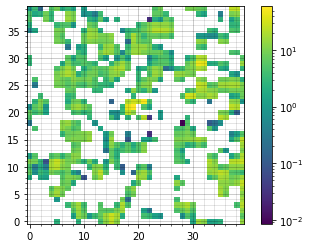

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- --------- ------------ ---------- ---------
  1        1             1 20.608649 20.993556    15.987809  0.0385965 99.672878
  2        2             1 36.824457 37.302263    18.983082 0.24148245 60.888153
Median mag error:  0.14003947395305313
Median flux error: 80.28051532798673
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3    err_e3 
--------- --------- --------- --------- ... ----------- --------- ---------
        0 36.973308 2.0552884 1318.2228 ...  0.25463819        --        --
        1 20.254074 20.788959 1301.5036 ... 0.041763448 15.987809 0.0385965




Epoch:  4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


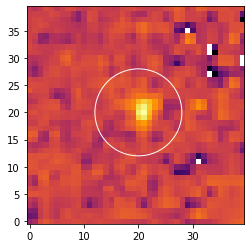

Mean: 40.492919921875
Median: 40.44440841674805
Std dev: 13.591110229492188
sources_PSF:   id     xcentroid     ...        flux               mag        
--- ----------------- ... ----------------- -------------------
  1 20.84159169900474 ... 5.438804036947446 -1.8387585280796799
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


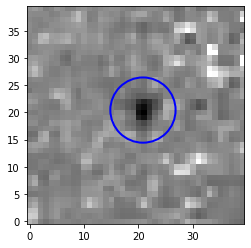

Time taken to fit PSF model: 0.03033140000025014s


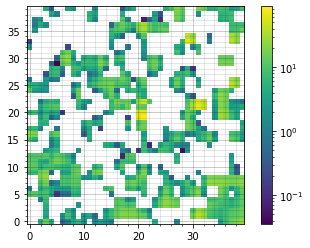

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.841592 ...    16.009818 0.047004829 143.71452
Median mag error:  0.04700482917114363
Median flux error: 143.71451805339896
id_master    x_0       y_0      x_true  ...   err_e3    mag_e4     err_e4  
--------- --------- --------- --------- ... --------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...        --        --          --
        1 20.254074 20.788959 1301.5036 ... 0.0385965 16.009818 0.047004829




Epoch:  5


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


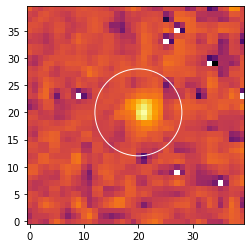

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Mean: 39.58396911621094
Median: 39.061885833740234
Std dev: 13.985730171203613
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 21.007780526329764 ... 5.344319237654936 -1.8197309809904931
Number of PSF stars: 1


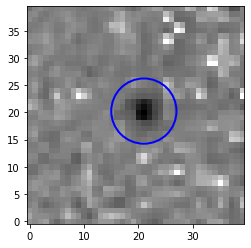

Time taken to fit PSF model: 0.03158669999993435s


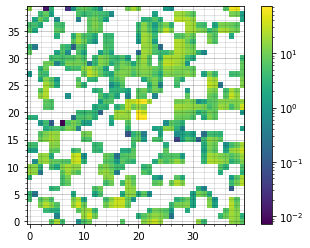

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 21.007781 ...    15.981321 0.042906474 125.58144
Median mag error:  0.042906474167016
Median flux error: 125.58144424881199
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...          --        --          --
        1 20.254074 20.788959 1301.5036 ... 0.047004829 15.981321 0.042906474




Epoch:  6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


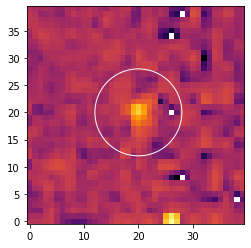

Mean: 38.72988510131836
Median: 37.843528747558594
Std dev: 13.502044677734375
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.022634945826756 ... 5.780760072662297 -1.9049623614756903
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


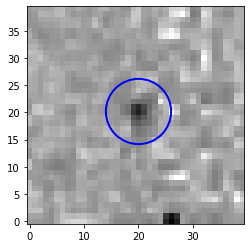

Time taken to fit PSF model: 0.02856049999991228s


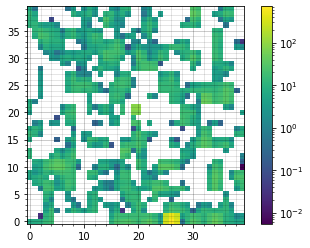

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.022635 ...    16.081061 0.047141728 135.24325
Median mag error:  0.047141728384836754
Median flux error: 135.2432464387105
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...          --        --          --
        1 20.254074 20.788959 1301.5036 ... 0.042906474 16.081061 0.047141728




Epoch:  7


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


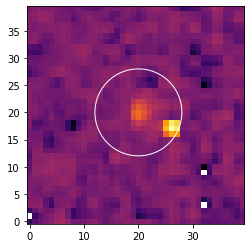

Mean: 41.355064392089844
Median: 40.242706298828125
Std dev: 12.977071762084961
No sources found initially :(
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 17.205088561776304 ... 1.0861360204092412 -0.08971054198579277
  2  16.78066099991968 ...   1.04497789857904 -0.04776776289598483
  3  35.33679406856813 ... 1.1909271474376288 -0.18971298801938963
  4  2.581344972298965 ...  1.487544200076027  -0.4311746974534476
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


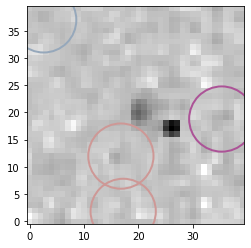

Time taken to fit PSF model: 0.04364770000029239s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


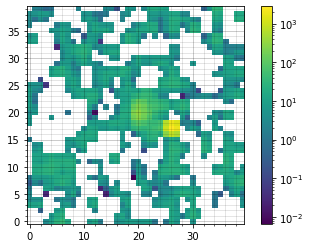

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err    flux_unc
--- -------- ------------- --------- --------- ------------ ---------- ---------
  1        1             1 17.205089 1.7883852    20.851754  1.2639949  57.43162
  2        1             1 16.780661 11.954762    18.763503 0.18956289 58.243374
  3        2             1 35.336794 18.771904    18.715755 0.17082792 54.688886
  4        3             1  2.581345 37.015528     18.90486 0.16789255 45.132944
Median mag error:  0.18019540620286686
Median flux error: 56.06025290862807
RRL7 not detected in this epoch :(
Epoch:  8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


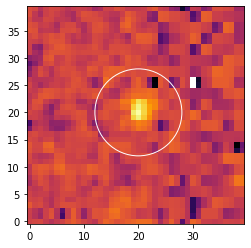

Mean: 39.65286636352539
Median: 39.631500244140625
Std dev: 13.29642391204834
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.098117711690044 ... 5.047768460441953 -1.7577485643527684
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


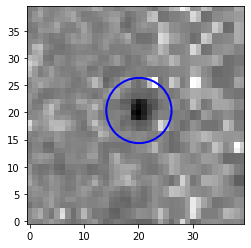

Time taken to fit PSF model: 0.045216500000606175s


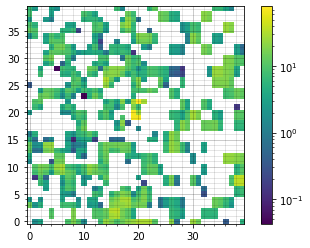

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.098118 ...    16.141962 0.045649878 121.13945
Median mag error:  0.04564987807014441
Median flux error: 121.13945263509444
id_master    x_0       y_0      x_true  ... mag_e7 err_e7   mag_e8     err_e8  
--------- --------- --------- --------- ... ------ ------ --------- -----------
        0 36.973308 2.0552884 1318.2228 ...    nan    nan        --          --
        1 20.254074 20.788959 1301.5036 ...    nan    nan 16.141962 0.045649878




Epoch:  9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


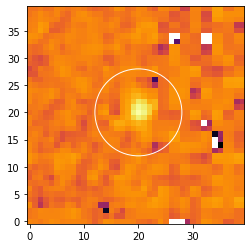

Mean: 39.66819381713867
Median: 39.77244186401367
Std dev: 13.54161548614502
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 20.179143535716648 ... 4.780102625122379 -1.6985930517007541
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


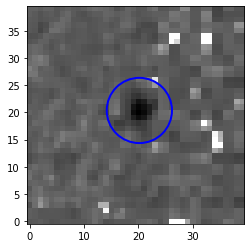

Time taken to fit PSF model: 0.032368099999985134s


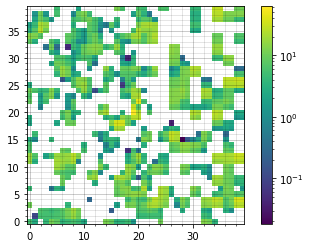

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.179144 ...    16.171013 0.042614497 104.10426
Median mag error:  0.04261449697634226
Median flux error: 104.10426356191023
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...          --        --          --
        1 20.254074 20.788959 1301.5036 ... 0.045649878 16.171013 0.042614497




Epoch:  10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


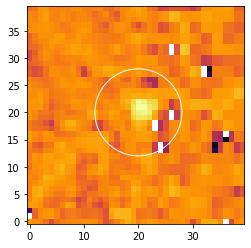

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Mean: 39.42386245727539
Median: 39.992340087890625
Std dev: 14.853588104248047
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ------------------ ------------------
  1 20.619787724798492 ... 3.4089635955028603 -1.331555908501501
Number of PSF stars: 1


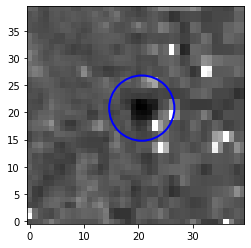

Time taken to fit PSF model: 0.027232999999796448s


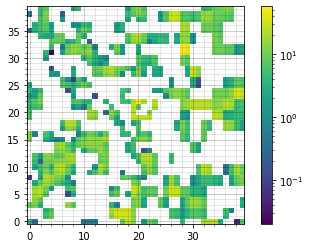

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.619788 ...    16.427533 0.053937418 120.72495
Median mag error:  0.05393741808605935
Median flux error: 120.72494973698736
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...          --        --          --
        1 20.254074 20.788959 1301.5036 ... 0.042614497 16.427533 0.053937418




Epoch:  11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


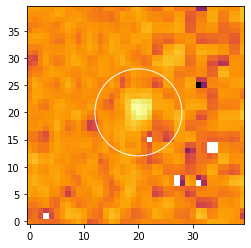

Mean: 38.520076751708984
Median: 38.92738342285156
Std dev: 13.728598594665527
sources_PSF:   id     xcentroid     ...        flux                mag         
--- ----------------- ... ------------------ --------------------
  1 20.10406667876354 ... 3.3815110644599304  -1.3227770319880787
  2 37.80071043773076 ... 1.1286823905477474 -0.13142937332839635
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


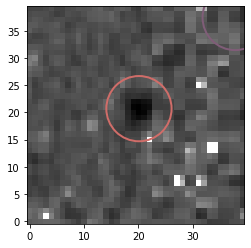

Time taken to fit PSF model: 0.04035959999964689s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


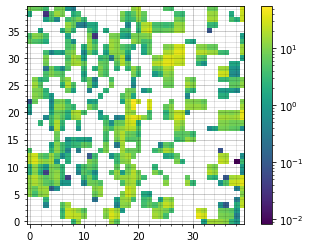

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.104067 ...    16.506283 0.049895081 100.06898
  2        2             1  37.80071 ...    19.497912  0.59475029 93.963472
Median mag error:  0.3223226871187808
Median flux error: 97.01622706063642
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...          --        --          --
        1 20.254074 20.788959 1301.5036 ... 0.053937418 16.506283 0.049895081




Epoch:  12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


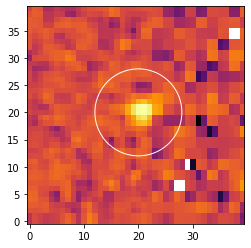

Mean: 37.88215637207031
Median: 37.52880096435547
Std dev: 15.085783004760742
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 20.66468283934606 ... 4.5937923287919515 -1.6554283954658184
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


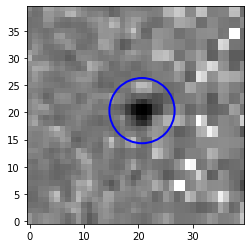

Time taken to fit PSF model: 0.02844660000027943s


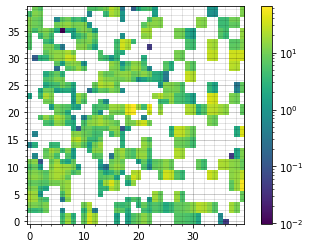

 id group_id iter_detected   x_fit   ... apparent_mag   mag_err    flux_unc
--- -------- ------------- --------- ... ------------ ----------- ---------
  1        1             1 20.664683 ...    16.016763 0.042583225 119.85551
Median mag error:  0.04258322536889955
Median flux error: 119.85550943569643
id_master    x_0       y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 36.973308 2.0552884 1318.2228 ...          --        --          --
        1 20.254074 20.788959 1301.5036 ... 0.049895081 16.016763 0.042583225




Star ID:  1
star_name id_master    RA        dec        x_0       y_0      x_true    y_true    mag_e1     err_e1     mag_e2     err_e2     mag_e3    err_e3    mag_e4     err_e4     mag_e5     err_e5     mag_e6     err_e6   mag_e7 err_e7   mag_e8     err_e8     mag_e9     err_e9    mag_e10    err_e10    mag_e11    err_e11    mag_e12    err_e12   eta_inv IQR chi_sq
--------- ---

C:\Users\Jake\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


<Table length=7>
star_name id_master     RA    ...         IQR                 chi_sq      
  str10     int32    float64  ...       float64              float64      
--------- --------- --------- ... -------------------- -------------------
     RRL0         2 228.98834 ...  0.08615170523790638  11.510968513031722
     RRL1         1 228.99133 ...  0.05075884189058044  10.762777395365466
     RRL2         1 229.05314 ...  0.07578262748884157  28.331856877879893
     RRL3         0 229.02405 ...   0.0644107634968698   11.67745128284923
     RRL4         0 228.99257 ...  0.06658124642287078  16.120113188933143
     RRL5         1  228.9963 ... 0.028039050029851964 0.16962776857487394
     RRL6         1  229.0395 ...                  nan                 nan

In [58]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

big_table = Table()  # initialising the table we'll dump each RRL's data into
# Ideal order for column names (also used to initialise blank rows for missing stars):
new_order = ['star_name', 'id_master', 'RA', 'dec', 'x_0', 'y_0', 'x_true', 'y_true', 'mag_e1', 'err_e1', 'mag_e2', 'err_e2', 'mag_e3', 'err_e3', 'mag_e4', 'err_e4', 'mag_e5', 'err_e5', 'mag_e6', 'err_e6', 'mag_e7', 'err_e7', 'mag_e8', 'err_e8', 'mag_e9', 'err_e9', 'mag_e10', 'err_e10', 'mag_e11', 'err_e11', 'mag_e12', 'err_e12', 'eta_inv', 'IQR', 'chi_sq']

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        print('Current star: RRL{}'.format(star+1))
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        master_table = Table.read(master_file, format='ascii.csv')
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
            
            print('Epoch: ', epoch)
            
            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:  
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+cluster+'__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            #if cluster == 'PAL 13' and star == 1:
            plt.savefig('images/'+cluster+'/problem_stars/RRL'+str(star+1)+'_'+channel+'_e'+str(epoch)+'.png')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                if sources_PSF == None:
                    print('No sources found initially :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('No sources found after reducing detection threshold :(')          
                
                try:
                    pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                except TypeError:                    
                    mag_name = 'mag_e'+str(epoch)
                    err_name = 'err_e'+str(epoch)
                    master_table[mag_name] = float('NaN')
                    master_table[err_name] = float('NaN')
                    
                    epoch += 1
                    continue
                
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                #plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_'+channel+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err', 'flux_unc'])
                
                mag_med = np.median(PSF_table['mag_err'])
                flux_med = np.median(PSF_table['flux_unc'])
                
                print('Median mag error:  {0}\nMedian flux error: {1}'.format(mag_med, flux_med))

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d < max_sep)
            match_table = match_table[selection]
            comp_table = comp_table[idx[selection]]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)
            
            mag_name = 'mag_e'+str(epoch)
            err_name = 'err_e'+str(epoch)
            
            try:
                master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            except ValueError:
                print('RRL{} not detected in this epoch :('.format(star+1))

                master_table[mag_name] = float('NaN')
                master_table[err_name] = float('NaN')

                epoch += 1
                continue
            
            #master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###
        
        ###   CALCULATING VARIABILITY INDICES AND AMPLITUDE FOR EACH STAR   ###
        
        masked_array = np.ma.array(np.zeros(len(master_table)), mask=True)
        master_table['eta_inv'] = masked_array
        master_table['IQR'] = masked_array
        master_table['chi_sq'] = masked_array

        master_table_f = copy.copy(master_table.filled(-99))

        for i in range(len(master_table_f)):

            # Putting magnitudes into an array so we can play with them:
            mags = []
            errs = []
            for j in range(1,13):
                mags.append(master_table_f['mag_e'+str(j)][i])
                errs.append(master_table_f['err_e'+str(j)][i])

            mags = np.ma.array(mags)
            mags = np.ma.masked_where(mags == -99, mags)
            errs = np.ma.array(errs)
            errs = np.ma.masked_where(errs == -99, errs)

            if mags.compressed().size:    # doesn't calculate anything extra if the star has no magnitude data

                # Chi squared test:
                mean_sum1 = sum((m / e**2) for m, e in zip(mags.compressed(), errs.compressed()))
                mean_sum2 = sum((1. / e**2) for e in errs.compressed())
                mean_chi = mean_sum1 / mean_sum2

                chi_sq = sum(((m - mean_chi) / e)**2 for m, e in zip(mags.compressed(), errs.compressed()))
                master_table['chi_sq'][i] = chi_sq

                # IQR:
                mags_sorted = sorted(mags.compressed())
                if len(mags_sorted) > 5:  # finding IQR for fewer than 6 values is pointless really, and can cause issues
                    if len(mags_sorted) % 2 == 1:   # if odd number of entries, remove the median
                        mags_sorted.pop(int(len(mags_sorted)/2))

                    mags_split= np.array_split(mags_sorted, 2)
                    mags_lo = mags_split[0]
                    mags_hi = mags_split[1]

                    n = int(len(mags_lo) / 2)
                    q25 = (mags_lo[n-1] + mags_lo[n]) / 2
                    q75 = (mags_hi[n-1] + mags_hi[n]) / 2
                    iqr = q75 - q25
                    master_table['IQR'][i] = iqr

                # von Neumann index:
                # (VERY important this is run LAST out of all the indices, otherwise 'continue' may skip them)
                var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)
                diff = 0
                for k in range(len(mags.compressed()) - 1):
                    diff += (mags.compressed()[k+1] - mags.compressed()[k])**2
                if (len(mags.compressed()) - 1) == 0:
                    continue
                mssd = diff / (len(mags.compressed()) - 1)
                if mssd == 0. or var == 0.:
                    continue
                eta_inv = var / mssd
                master_table['eta_inv'][i] = eta_inv
        
        ###   KEEPING ONLY THE RRL   ###

        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        
        master_table['star_name'] = str('not an RRL')
        master_table['star_name'][star_id] = 'RRL'+str(star)

        master_table = master_table[new_order]
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()
                

        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    
    else:  # i.e. if not in starlist
        
        master_table = Table(data=np.full(shape=len(master_table), fill_value=np.nan, dtype=big_table.dtype), names=new_order, masked=True)
        master_table['star_name'] = 'RRL'+str(star)
        
    
    big_table = vstack([big_table, master_table[star_id]])    
    
    #if star == 1:
    #    break
        
    
    ###   END OF STAR LOOP   ###

save_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table, pickle_out)
pickle_out.close()

big_table

In [23]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
#load_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

big_table

<Table length=5>
star_name   id_master        RA    ...         IQR               chi_sq      
  str10       int32       float64  ...       float64            float64      
--------- -------------- --------- ... ------------------- ------------------
     RRL0              3  346.6731 ... 0.14524234763840127 140.93223838365628
     RRL1              2  346.6853 ... 0.36570248475341316 240.57539244138974
     RRL2              2  346.6796 ...  0.2919240254844411   175.934355110803
     RRL3              1 346.70346 ... 0.13741286593406343  92.56320989777025
     RRL4 -2.1474836e+09       nan ...                 nan                nan

In [14]:
loadname0 = 'phot_tables/'+cluster+'/individual/big_table_RRL0_'+method+'_'+channel+'.pickle'
loadname1 = 'phot_tables/'+cluster+'/individual/big_table_RRL1_'+method+'_'+channel+'.pickle'
loadname2 = 'phot_tables/'+cluster+'/individual/big_table_RRL2_'+method+'_'+channel+'.pickle'
loadname3 = 'phot_tables/'+cluster+'/individual/big_table_RRL3_'+method+'_'+channel+'.pickle'
loadname4 = 'phot_tables/'+cluster+'/individual/big_table_RRL4_'+method+'_'+channel+'.pickle'
loadname5 = 'phot_tables/'+cluster+'/individual/big_table_RRL5_'+method+'_'+channel+'.pickle'
loadname6 = 'phot_tables/'+cluster+'/individual/big_table_RRL6_'+method+'_'+channel+'.pickle'

pickle_in = open(loadname0, 'rb')
RRL0 = pickle.load(pickle_in)
pickle_in = open(loadname1, 'rb')
RRL1 = pickle.load(pickle_in)
pickle_in = open(loadname2, 'rb')
RRL2 = pickle.load(pickle_in)
pickle_in = open(loadname3, 'rb')
RRL3 = pickle.load(pickle_in)
pickle_in = open(loadname4, 'rb')
RRL4 = pickle.load(pickle_in)
pickle_in = open(loadname5, 'rb')
RRL5 = pickle.load(pickle_in)
pickle_in = open(loadname6, 'rb')
RRL6 = pickle.load(pickle_in)

In [15]:
RRL6

<Row index=1>
star_name id_master    x_0       y_0       RA        dec       mag_e1     err_e1     mag_e2     err_e2     mag_e3     err_e3     mag_e4     err_e4     mag_e5     err_e5     mag_e6     err_e6    mag_e7  err_e7   mag_e8     err_e8     mag_e9     err_e9    mag_e10   err_e10    mag_e11    err_e11    mag_e12    err_e12   eta_inv   IQR    chi_sq
  str10     int32    float64   float64  float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64   float64 float64  float64    float64    float64    float64    float64   float64    float64    float64    float64    float64   float64 float64 float64
--------- --------- --------- --------- -------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- ------- ------- --------- ----------- --------- ----------- --------- ---------- --------- ----------- --------- ----------- ------- ------- -------
     RRL6         1 20.254074 20.788959 229.0395 -0.27310464 16.264084 0.040842699 16.327979 0.041777398 15.987809 0.038611594 16.009818 0.047017224 15.981321 0.042920053 16.081061 0.047154087     nan     nan 16.141962 0.045662641 16.171013 0.042628169 16.427533 0.05394822 16.506283 0.049906758 16.016763 0.042596907     nan     nan     nan

### Run this to add Welch-Stetson variability index to huge_table:
Requires data from both channels, hence why this isn't in the main photometry cell

In [17]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'
load_name_normal = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)
pickle_in = open(load_name_normal, 'rb')
big_table = pickle.load(pickle_in)

'''ra1 = np.ma.masked_invalid(big_table_ch1['RA'])
dec1 = np.ma.masked_invalid(big_table_ch1['dec'])
ra2 = np.ma.masked_invalid(big_table_ch2['RA'])
dec2 = np.ma.masked_invalid(big_table_ch2['dec'])
print(ra1.compressed(), dec1.compressed(), ra2.compressed(), dec2.compressed())

cat_ch1 = SkyCoord(ra1.compressed(), dec1.compressed(), frame='icrs', unit='deg')
cat_ch2 = SkyCoord(ra2.compressed(), dec2.compressed(), frame='icrs', unit='deg')

idx, d2d, d3d = match_coordinates_sky(cat_ch1, cat_ch2)  # idx correspond to ch1

#print(len(idx))
#print(len(cat_ch1))

max_sep = 0.4 * u.arcsec  # looking at maximum distance between matching RA/dec coords, around 0.4 seems to work decently
selection = (d2d > max_sep)
match_index = idx
match_index[selection] = -99.
ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

big_table_ch1 = big_table_ch1[ind]
big_table_ch2 = big_table_ch2[match_index][ind]
#print(len(big_table_ch1))

id_list = np.arange(len(big_table_ch1))
big_table_ch1['id_match'] = id_list
big_table_ch2['id_match'] = id_list'''

masked_array = np.ma.array(np.zeros(len(big_table_ch1)), mask=True)
big_table_ch1['I_var'] = masked_array
big_table_ch2['I_var'] = masked_array

big_table_ch1_f = copy.copy(big_table_ch1.filled(-99))
big_table_ch2_f = copy.copy(big_table_ch2.filled(-99))

for i in range(len(big_table_ch1)):
    #print(i)
    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        mags_ch1.append(big_table_ch1_f['mag_e'+str(j)][i])
        mags_ch2.append(big_table_ch2_f['mag_e'+str(j)][i])
        errs_ch1.append(big_table_ch1_f['err_e'+str(j)][i])
        errs_ch2.append(big_table_ch2_f['err_e'+str(j)][i])

    mags_ch1 = np.ma.array(mags_ch1)
    mags_ch1 = np.ma.masked_where(mags_ch1 == -99, mags_ch1)
    mags_ch2 = np.ma.array(mags_ch2)
    mags_ch2 = np.ma.masked_where(mags_ch2 == -99, mags_ch2)
    errs_ch1 = np.ma.array(errs_ch1)
    errs_ch1 = np.ma.masked_where(errs_ch1 == -99, errs_ch1)
    errs_ch2 = np.ma.array(errs_ch2)
    errs_ch2 = np.ma.masked_where(errs_ch2 == -99, errs_ch2)
    
    m1_mean = np.mean(mags_ch1.compressed())
    m2_mean = np.mean(mags_ch2.compressed())
    n = len(mags_ch1)   # could also be len(mags_ch2)
    
    # probably need to do a for loop instead of list comprehension
    # check if number of mags in ch1 and ch2 list match; if not, don't calculate
    # doesn't guarantee that the mags are from the same epochs, even if the length matches; might need to only calculate for stars with 12 observations :/
    # unless we wanna get complicated and check that each list has values in the same places
    
    '''if len(mags_ch1.compressed()) == 12 and len(mags_ch2.compressed()) == 12:
        count += 1
        print('yay they are both big')
        
        I = sum((((m1-m1_mean)/e1) * ((m2-m2_mean)/e2)) for m1, m2, e1, e2 in zip(mags_ch1, mags_ch2, errs_ch1, errs_ch2)) * np.sqrt(1. / (n*(n-1)))

        print(len(mags_ch1.compressed()))
        print(len(mags_ch2.compressed()))
        print('I: ', I, '\n')

        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I'''
    
    I_prod = 0
    count_unmasked = 0
    
    for k in range(len(mags_ch1)):
        if np.ma.is_masked(mags_ch1[k]) == True:
            #print('ch1 is masked')
            continue
        elif np.ma.is_masked(mags_ch2[k]) == True:
            #print('ch2 is masked')
            continue
        else:
            #print('neither masked :)')
            count_unmasked += 1
            I_prod += ((mags_ch1[k] - m1_mean) / errs_ch1[k]) * ((mags_ch2[k] - m2_mean) / errs_ch2[k])
        
    #print('count unmasked: ', count_unmasked)
    if count_unmasked > 5:
        I = I_prod * np.sqrt(1. / n * (n - 1))
        #print('I: ', I)
        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I
    #else:
        #print('too few good values to calculate I :(')
    
    #print(big_table_ch1['I_var'][i])
    #print('\n')


big_table_var = join(big_table, big_table_ch1['star_name', 'I_var'], keys='star_name', join_type='left')

save_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_var, pickle_out)
pickle_out.close()

big_table_var

<Table length=5>
star_name   id_master        RA    ...       chi_sq              I_var       
  str10       int32       float64  ...      float64             float64      
--------- -------------- --------- ... ------------------ -------------------
     RRL0              2  346.6729 ... 111.97863867238496   55.13041941431693
     RRL1              1 346.68512 ...  66.55609315558254 -10.376788119417483
     RRL2              1 346.67961 ...  190.2430713894951    14.7638680268631
     RRL3 -2.1474836e+09       nan ...                nan                 nan
     RRL4              0 346.65532 ... 20.148470438756682                 nan

### Plotting light curves:

RRab
Mags:  [16.007516762933026 16.00483073015654 16.084578461276195
 15.986937166793867 15.824427871248545 15.960545238938462
 15.98322179651318 15.92943892051644 16.0258025348793 15.957221848691798
 15.911574460630828 15.946557676160284]
Errs:  [0.23451565662403248 0.2505279270676774 0.23794140525793678
 0.2540102835050393 0.25262069488666106 0.25883772902184915
 0.2668430607329269 0.31024200633115756 0.2626768568223936
 0.22908171164236035 0.2223544095146261 0.2706169674906498]
Phase:  [0.3765373656497104 0.48631934908917174 0.5690535252506379
 0.6674239707936067 0.7636280783772236 0.8677452556148637
 0.9477804612106411 0.04827366388053633 0.1448888923623599
 0.2294763514364604 0.3240366951795295 0.43251251327455975]


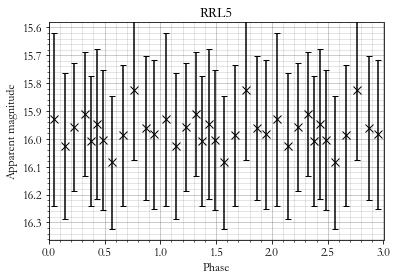

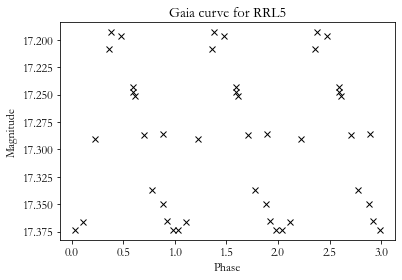

Chi squared:   0.7589534478039934
IQR:           0.06817544820642141
Welch-Stetson: -0.04090589973405752
von Neumann:   0.5684421682310742


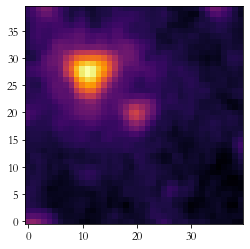

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


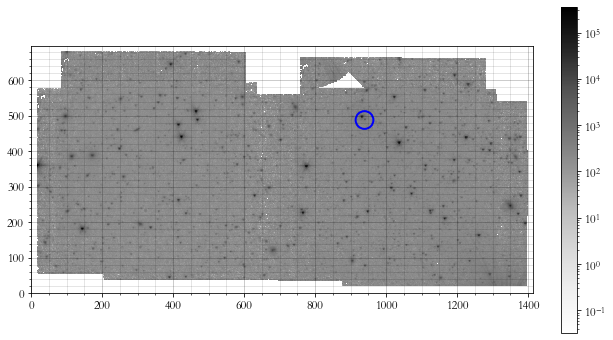

In [11]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

LC_time = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


###   FOR PLOTTING STAR FROM CATALOGUE   ###

###########
star_id = 5
###########

if star_id in starlist:

    file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
    df_CC = pd.read_csv(file_CC, sep=',', header=0)
    
    #c_CC = SkyCoord(df_CC['RA'][star_id], df_CC['dec'][star_id], frame='icrs', unit='deg')
    ra_temp = np.ma.masked_invalid(big_table['RA'])
    dec_temp = np.ma.masked_invalid(big_table['dec'])
    #c_comp = SkyCoord(ra_temp.compressed(), dec_temp.compressed(), frame='icrs', unit='deg')

    if df_CC['type'][star_id] == 'RR0':
        P = df_CC['period_fund'][star_id]
        print('RRab')
    elif df_CC['type'][star_id] == 'RR1':
        P = df_CC['period_FO'][star_id]
        print('RRc')
    elif df_CC['type'][star_id] == 'RR01':
        P = df_CC['period_FO'][star_id]
    
    temp = [i / P for i in LC_time]
    phase = temp - np.floor(temp)  


    #big_table_i = big
    big_table_f = copy.copy(big_table.filled(-99))

    mags = []
    errs = []
    for i in range(1,13):
        mags.append(big_table['mag_e'+str(i)][star_id])
        errs.append(big_table['err_e'+str(i)][star_id])

    ### Masking out a specific data point (only use in emergencies, or the Science Police will get you):

    #remove_pls = 5  # EPOCH number of bad point
    #mags[remove_pls-1] = -99
    #print(mags)

    ###

    mags = np.ma.array(mags)
    #mags = np.ma.masked_where(mags == -99, mags)
    mags = np.ma.masked_invalid(mags)
    errs = np.ma.masked_array(errs, mags.mask)
    phase = np.ma.masked_array(phase, mags.mask)
    print('Mags: ', mags)
    print('Errs: ', errs)
    print('Phase: ', phase)

    ###   PLOTTING LIGHT CURVES   ###

    mags_long = np.ma.concatenate((mags, mags, mags))  # this idea taken from some of vicky's code; credit?
    errs_long = np.ma.concatenate((errs, errs, errs))
    phase_long = np.ma.concatenate((phase, phase + 1., phase + 2.))

    plt.errorbar(phase_long, mags_long, yerr=errs_long, fmt='x', color='black', capsize=3, markersize=8)
    plt.ylim(np.ma.median(mags) - 1.5*(max(mags)-min(mags)), np.ma.median(mags) + 1.5*(max(mags)-min(mags)))
    plt.xlim(0, 3)
    plt.gca().invert_yaxis()
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.xlabel('Phase')
    plt.ylabel('Apparent magnitude')
    plt.title('RRL'+str(star_id))
    #plt.savefig('images/'+cluster+'/curves/'+method+'_'+channel+'_'+str(star_id)+'_'+str(model_epoch)+'.png', dpi=100)
    plt.show()

    ###   GAIA DR2 CURVE COMPARISON   ###
    
    if cluster == 'PAL5':

        vot_name = 'data/curves/proc_RRL'+str(star_id+1)+'.vot'

        if os.path.isfile(vot_name) == True:

            votable = parse_single_table(vot_name)
            data_vot = votable.array

            temp = [i / P for i in data_vot['obs_time']]
            phase_vot = temp - np.floor(temp)

            mags_vot = np.concatenate((data_vot['phot'], data_vot['phot'], data_vot['phot']))
            phases_vot = np.concatenate((phase_vot, phase_vot + 1., phase_vot + 2.))

            plt.plot(phases_vot, mags_vot, 'kx')
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.title('Gaia curve for RRL'+str(star_id))
            #plt.savefig('images/'+cluster+'/curves/gaia/RRL'+str(star_id+1), dpi=200)
            plt.show()

    ###   PRINTING VARIABILITY INFORMATION ETC.   ###

    print('Chi squared:  ', big_table['chi_sq'][star_id])
    print('IQR:          ', big_table['IQR'][star_id])
    print('Welch-Stetson:', big_table['I_var'][star_id])
    print('von Neumann:  ', big_table['eta_inv'][star_id])

    ###   PLOTTING IMAGE OF STAR FROM MASTER FRAME   ###

    star_r = 20
    star_x = int(big_table['x_true'][star_id])
    star_y = int(big_table['y_true'][star_id])
    star_ap = CircularAperture((star_x, star_y), r=25.)

    region = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
    plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
    #star_ap.plot(color='white')
    plt.show()

    plt.imshow(data_m, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
    star_ap.plot(color='blue', lw=2.)
    plt.colorbar(fraction = 0.05)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.gcf().set_size_inches(10, 6)
    plt.show()

    #plotting(data_m, star_ap, an=None, cmap='Greys', choice='ap_only', savename=None)
    
else:
    print("RRL"+str(star_id)+" isn't visible in this channel")

Looking at standard deviation of Pal 13's "bad" epochs from the rest of the data:

In [34]:
goodmags = []
badmags = []
badlist = [1, 3, 6, 7]
for i in range(len(mags)):
    if i+1 not in badlist:
        goodmags.append(mags[i])
    else:
        badmags.append(mags[i])
        
print(badmags)

goodmags = np.ma.masked_array(goodmags)
stdev = np.std(goodmags.compressed())
mean = np.mean(goodmags.compressed())

print(stdev)
print(mean + stdev)
print(mean + 2*stdev)
print(mean + 3*stdev)
print(mean + 4*stdev)
print(mean + 5*stdev)
print(mean + 6*stdev)
print(mean + 7*stdev)
print(mean + 8*stdev)

[16.59081144880047, 16.58462040548151, 16.456019858329125, 16.597143375867212]
0.057042864247868676
16.25159363555226
16.30863649980013
16.365679364048
16.422722228295868
16.479765092543737
16.536807956791606
16.593850821039474
16.650893685287343


### Running GLOESS:

Gaia DR2 ID: 4418914863842345856
RRc
Channel 1 mags:  [16.46457961 16.41590768 16.32487826 16.40188227 16.467235   16.53119619
 16.31903277 16.3605872  16.49983239 16.50150452 16.49631416 16.39022732]
Channel 2 mags:  [16.5074408  16.42071801 16.5017606  16.41617999 16.43254054 16.45774974
 16.46116032 16.36783037 16.45456473 16.51755404 16.52264787 16.41297726] 

RRL1 ---- Period = 0.29322862 days
------------------------------------------------------
12 12
<[3.6]> = 16.431    std dev = 0.056     amplitude = 0.155


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.454    std dev = 0.025     amplitude = 0.074
<[3.6] - [4.5]> = -0.023    std dev = 0.039     amplitude = 0.118


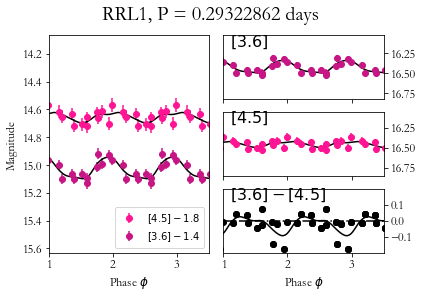

[0.01287954003879547]
new error ch1: 0.01287954003879547
new error ch2: 0.00619588618979261



Gaia DR2 ID: 4418913218870688768
RRd
Channel 1 mags:  []
Channel 2 mags:  [16.26462683 16.2422049  16.29573522 16.28694644 16.27944953 16.26957424
 16.27103321 16.31167318 16.19334307 16.22813418 16.21146509 16.2367441 ] 

RRL2 ---- Period = 0.33245990000000003 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.257    std dev = 0.013     amplitude = 0.040
Channels don't have the same number of measurements, so colour curve couldn't be plotted


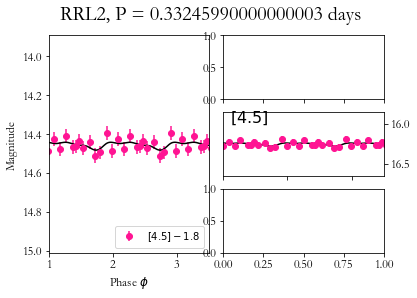

[0.01287954003879547, nan]
new error ch1: nan
new error ch2: 0.0033735349587050343



Gaia DR2 ID: 441872602716125056
RRc
Channel 1 mags:  [16.44881767 16.42010076 16.357244   16.36946057 16.34378917 16.45985185
 16.61076997 99.         16.41116571 16.45797594 16.42244743 16.38107193]
Channel 2 mags:  [16.74510759 16.46784714 16.45204754 16.46064889 16.39244578 99.
 99.         99.         99.         16.384485   16.42496412 16.37304486] 

RRL3 ---- Period = 0.32994609999999996 days
------------------------------------------------------
11 8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.420    std dev = 0.038     amplitude = 0.122
<[4.5]> = 16.458    std dev = 0.040     amplitude = 0.148
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


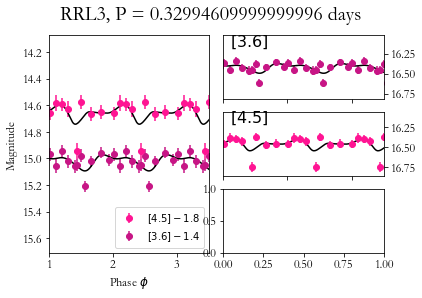

[0.01287954003879547, nan, 0.01064793881494922]
new error ch1: 0.01064793881494922
new error ch2: 0.015081987418232827



Gaia DR2 ID: 4418725889577171328
RRc
Channel 1 mags:  []
Channel 2 mags:  [16.48812639 16.40419414 16.47003671 16.47712258 16.40169962 16.50150981
 16.37507725 16.42292839 16.47882147 16.46813403 16.44011712 16.42368005] 

RRL4 ---- Period = 0.2864 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.447    std dev = 0.021     amplitude = 0.072
Channels don't have the same number of measurements, so colour curve couldn't be plotted


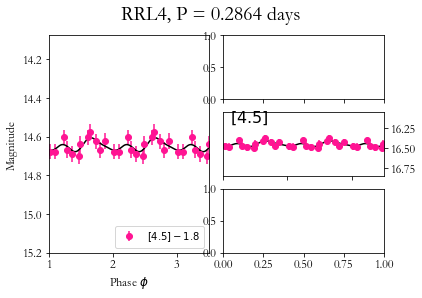

[0.01287954003879547, nan, 0.01064793881494922, nan]
new error ch1: nan
new error ch2: 0.0060347248391459845



Gaia DR2 ID: 4418920808077110784
RRc
Channel 1 mags:  [16.32266747 16.33928474 16.39819875 16.4639766  16.22488658 16.38019195
 16.37570675 16.49374695 16.36872685 16.28341195 16.41037147 16.42353915]
Channel 2 mags:  [16.30306196 16.43908569 16.3723099  16.35937744 16.3012713  16.33584757
 16.40770798 16.4183386  16.46870454 16.4100489  16.39090231 16.37287038] 

RRL5 ---- Period = 0.33793290000000004 days
------------------------------------------------------
12 12
<[3.6]> = 16.369    std dev = 0.036     amplitude = 0.120


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.383    std dev = 0.030     amplitude = 0.082
<[3.6] - [4.5]> = -0.014    std dev = 0.025     amplitude = 0.089


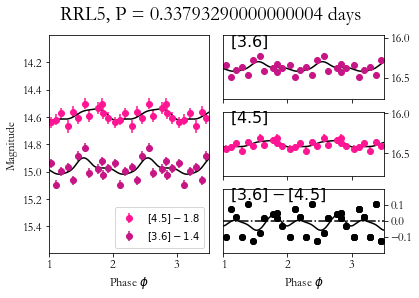

[0.01287954003879547, nan, 0.01064793881494922, nan, 0.009987224055072316]
new error ch1: 0.009987224055072316
new error ch2: 0.006855275424768455



Gaia DR2 ID: 4418920846732620032
RRab
Channel 1 mags:  [16.00751676 16.00483073 16.08457846 15.98693717 15.82442787 15.96054524
 15.9832218  15.92943892 16.02580253 15.95722185 15.91157446 15.94655768]
Channel 2 mags:  [15.89155365 15.93655566 15.93844179 15.99423631 15.9594141  15.93873114
 15.93602901 15.94585563 15.90734548 15.94955062 15.94990196 15.84239954] 

RRL6 ---- Period = 0.64322793 days
------------------------------------------------------
12 12
<[3.6]> = 15.968    std dev = 0.033     amplitude = 0.124
<[4.5]> = 15.936    std dev = 0.024     amplitude = 0.085

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.032    std dev = 0.047     amplitude = 0.169


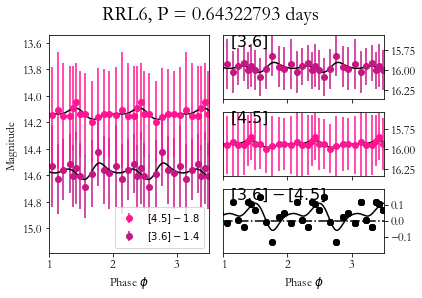

[0.01287954003879547, nan, 0.01064793881494922, nan, 0.009987224055072316, 0.010334773024223884]
new error ch1: 0.010334773024223884
new error ch2: 0.007056176881989895



Gaia DR2 ID: 4418724034151291776
RRab
Channel 1 mags:  []
Channel 2 mags:  [16.26408443 16.3279792  15.98780904 16.00981829 15.98132064 16.08106136
 99.         16.14196171 16.17101296 16.42753348 16.50628336 16.01676306] 

RRL7 ---- Period = 0.551705 days
------------------------------------------------------
0 11


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.133    std dev = 0.125     amplitude = 0.399
Channels don't have the same number of measurements, so colour curve couldn't be plotted


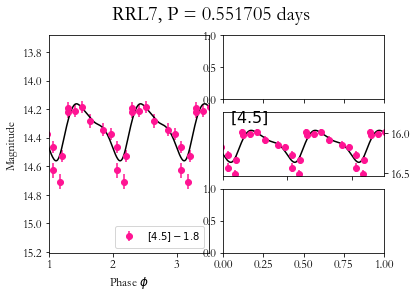

[0.01287954003879547, nan, 0.01064793881494922, nan, 0.009987224055072316, 0.010334773024223884, nan]
new error ch1: nan
new error ch2: 0.034765692804302584





ID            RA           dec units  period_fund  period_FO  mean_mag_CC  \
0   1  15h15m57.18s  -00d06m53.3s    R0          NaN   0.293229      17.7100   
1   2  15h15m57.95s  -00d11m23.4s    R0     0.456049   0.332460      17.8100   
2   3  15h16m12.76s  -00d10m03.3s    R0          NaN   0.329946      17.7000   
3   4  15h16m05.79s  -00d11m12.7s    R0          NaN   0.286400      17.6900   
4   5  15h15m58.23s  -00d05m47.4s    R0          NaN   0.337933      17.7000   
5   6     228.99635      -0.08978    R0     0.643228        NaN      17.2908   
6   7     229.03964   -0.27308442    R0     0.551705        NaN          NaN   

   amplitude colour  type  ...  mean_photerr_mon_ch1  mean_photerr_mon_ch2  \
0       0.42      B   RR1  ...              0.010843              0.013122   
1       0.40      B  RR01  ...                   NaN              0.010349   
2       0.50      B   RR1  ...              0.013729              0.019197   
3       0.48      B   RR1  ...                   NaN              0.011457   
4       0.30      B   RR1  ...              0.009934              0.012193   
5        NaN    NaN   RR0  ...              0.072597              0.097956   
6       1.14    NaN   RR0  ...                   NaN              0.013342   

   mean_photerr_hen_ch1  mean_photerr_hen_ch2  period_used  period_PL  A_ch1  \
0              0.010890              0.013222     0.293229   0.392832   0.01   
1                   NaN              0.010365     0.332460   0.445389   0.01   
2              0.013897              0.019448     0.329946   0.442021   0.01   
3                   NaN              0.011520     0.286400   0.383683   0.01   
4              0.009965              0.012204     0.337933   0.452721   0.01   
5              0.073660              0.100707     0.643228   0.643228   0.01   
6                   NaN              0.013571     0.551705   0.551705   0.01   

   A_ch2   amp_ch1   amp_ch2  
0  0.008  0.154554  0.074351  
1  0.008       NaN  0.040482  
2  0.008  0.122336  0.147773  
3  0.008       NaN  0.072417  
4  0.008  0.119847  0.082263  
5  0.008  0.124017  0.084674  
6  0.008       NaN  0.399427  

[7 rows x 31 columns]

In [12]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
photerr_amps_ch1 = []
photerr_amps_ch2 = []
photerr_mean_ch1_monson = []
photerr_mean_ch2_monson = []
photerr_mean_ch1_hendel = []
photerr_mean_ch2_hendel = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC)):
    
    if df_CC['type'][star] == 'SR?':
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    if df_CC['gaia_ID'][star] != 0:
        id1 = df_CC['gaia_ID_1'][star]
        id2 = df_CC['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)
    
    c_CC = SkyCoord(df_CC['RA'][star], df_CC['dec'][star], frame='icrs', unit='deg')

    if df_CC['type'][star] == 'RR0':
        P = df_CC['period_fund'][star]
        P_PL = P
        print('RRab')
    elif df_CC['type'][star] == 'RR1':
        P = df_CC['period_FO'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC['type'][star] == 'RR01':
        P = df_CC['period_FO'][star]
        P_PL = P * 10**0.127
        print('RRd')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [1, 3, 6, 7]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
        
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [2, 4, 5, 8, 9, 10, 11, 12]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)

    mean_ch1, amp_ch1, std_ch1, N_ch1, mean_ch2, amp_ch2, std_ch2, N_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloesstest(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    # Monson 2017 approach:
    ch1_temp = [(1. / e**2) for e in errs_ch1]
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)
    
    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    # Hendel 2018 approach:
    ch1_temp_h = [e**2 for e in errs_ch1.compressed()]
    ch2_temp_h = [e**2 for e in errs_ch2.compressed()]
    
    if ch1_temp_h:
        photerr_ch1_hendel = np.sqrt(sum(ch1_temp_h) / len(errs_ch1.compressed())**2)
    else:
        photerr_ch1_hendel = float('NaN')
    if ch2_temp_h:
        photerr_ch2_hendel = np.sqrt(sum(ch2_temp_h) / len(errs_ch2.compressed())**2)
    else:
        photerr_ch2_hendel = float('NaN')
        
    photerr_mean_ch1_hendel.append(photerr_ch1_hendel)
    photerr_mean_ch2_hendel.append(photerr_ch2_hendel)
        

    # My initial approach:
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
        
    # Fit error amplitude approach (instead of std:        
    photerr_amp_ch1 = amp_ch1 / np.sqrt(12 * N_ch1)
    photerr_amp_ch2 = amp_ch2 / np.sqrt(12 * N_ch2)
    
    photerr_amps_ch1.append(photerr_amp_ch1)
    photerr_amps_ch2.append(photerr_amp_ch2)
    print(photerr_amps_ch1)
    
    print('new error ch1:', photerr_amp_ch1)
    print('new error ch2:', photerr_amp_ch2)
    
    
    print('\n\n')


df_CC['mean_mag_ch1'] = means_ch1
df_CC['mean_mag_ch2'] = means_ch2
df_CC['mean_std_ch1'] = stds_ch1
df_CC['mean_std_ch2'] = stds_ch2
df_CC['mean_photerr_ch1'] = photerr_mean_ch1
df_CC['mean_photerr_ch2'] = photerr_mean_ch2
df_CC['mean_photerr_amp_ch1'] = photerr_amps_ch1
df_CC['mean_photerr_amp_ch2'] = photerr_amps_ch2
df_CC['mean_photerr_mon_ch1'] = photerr_mean_ch1_monson
df_CC['mean_photerr_mon_ch2'] = photerr_mean_ch2_monson
df_CC['mean_photerr_hen_ch1'] = photerr_mean_ch1_hendel
df_CC['mean_photerr_hen_ch2'] = photerr_mean_ch2_hendel
df_CC['period_used'] = periods
df_CC['period_PL'] = periods_PL
df_CC['A_ch1'] = A_ch1
df_CC['A_ch2'] = A_ch2
df_CC['amp_ch1'] = amps_ch1
df_CC['amp_ch2'] = amps_ch2

df_CC


In [95]:
print(df_CC[['mean_photerr_ch1', 'mean_photerr_mon_ch1', 'mean_photerr_hen_ch1', 'mean_photerr_ch2', 'mean_photerr_mon_ch2', 'mean_photerr_hen_ch2']])

   mean_photerr_ch1  mean_photerr_mon_ch1  mean_photerr_hen_ch1  \
0          0.037683              0.010843              0.010890   
1               NaN                   NaN                   NaN   
2          0.045955              0.013729              0.013897   
3               NaN                   NaN                   NaN   
4          0.034494              0.009934              0.009965   
5          0.254186              0.072597              0.073660   
6               NaN                   NaN                   NaN   

   mean_photerr_ch2  mean_photerr_mon_ch2  mean_photerr_hen_ch2  
0          0.045727              0.013126              0.013226  
1          0.035908              0.010354              0.010370  
2          0.054839              0.019201              0.019452  
3          0.039866              0.011461              0.011524  
4          0.042280              0.012197              0.012208  
5          0.346332              0.097956              0.100708  
6

In [96]:
print(df_CC[['mean_std_ch1', 'mean_photerr_amp_ch1', 'mean_std_ch2', 'mean_photerr_amp_ch2']])

   mean_std_ch1  mean_photerr_amp_ch1  mean_std_ch2  mean_photerr_amp_ch2
0      0.056273              0.012880      0.024742              0.006196
1           NaN                   NaN      0.012662              0.003374
2      0.038163              0.010648      0.039588              0.015083
3           NaN                   NaN      0.021242              0.006035
4      0.036339              0.009987      0.030286              0.006855
5      0.032613              0.010335      0.024077              0.007056
6           NaN                   NaN      0.125448              0.034766


In [97]:
print(df_CC[['mean_std_ch1', 'mean_photerr_hen_ch1', 'mean_std_ch2', 'mean_photerr_hen_ch2']])

print('Median phot err ch1: {:.4f}'.format(np.nanmedian(df_CC['mean_photerr_hen_ch1'])))
print('Median phot err ch2: {:.4f}'.format(np.nanmedian(df_CC['mean_photerr_hen_ch2'])))
print('Median fit err ch1:  {:.4f}'.format(np.nanmedian(df_CC['mean_std_ch1'])))
print('Median fit err ch2:  {:.4f}'.format(np.nanmedian(df_CC['mean_std_ch2'])))

print('Mean phot err ch1: {:.4f}'.format(np.nanmean(df_CC['mean_photerr_hen_ch1'])))
print('Mean phot err ch2: {:.4f}'.format(np.nanmean(df_CC['mean_photerr_hen_ch2'])))
print('Mean fit err ch1:  {:.4f}'.format(np.nanmean(df_CC['mean_std_ch1'])))
print('Mean fit err ch2:  {:.4f}'.format(np.nanmean(df_CC['mean_std_ch2'])))

   mean_std_ch1  mean_photerr_hen_ch1  mean_std_ch2  mean_photerr_hen_ch2
0      0.056273              0.010890      0.024742              0.013226
1           NaN                   NaN      0.012662              0.010370
2      0.038163              0.013897      0.039588              0.019452
3           NaN                   NaN      0.021242              0.011524
4      0.036339              0.009965      0.030286              0.012208
5      0.032613              0.073660      0.024077              0.100708
6           NaN                   NaN      0.125448              0.013575
Median phot err ch1: 0.0124
Median phot err ch2: 0.0132
Median fit err ch1:  0.0373
Median fit err ch2:  0.0247
Mean phot err ch1: 0.0271
Mean phot err ch2: 0.0259
Mean fit err ch1:  0.0408
Mean fit err ch2:  0.0397


In [98]:
print(err_mean_ch1)
print(err_mean_ch2)

print('Median total err ch1: {:.4f}'.format(np.ma.median(err_mean_ch1)))
print('Median total err ch2: {:.4f}'.format(np.ma.median(err_mean_ch2)))
print('Mean total err ch1: {:.4f}'.format(np.ma.mean(err_mean_ch1)))
print('Mean total err ch2: {:.4f}'.format(np.ma.mean(err_mean_ch2)))

[0.08071144299498906 0.07105204165456341 0.10141738329465969 -- --]
[0.0740935580857186 0.08148787470018008 0.06822746495381725
 0.09699115225246874 --]
Median total err ch1: 0.0807
Median total err ch2: 0.0778
Mean total err ch1: 0.0844
Mean total err ch2: 0.0802


In [99]:
means_ch1 = np.ma.masked_invalid(means_ch1)
ext = 0.01
percs = []

for i in range(len(means_ch1.compressed())):
    percs.append(ext / means_ch1.compressed()[i])

print('Median perc: {:.3f}%'.format(np.median(percs)*100))

Median perc: 0.061%


In [100]:
means_ch2 = np.ma.masked_invalid(means_ch2)
ext = 0.008
percs = []

for i in range(len(means_ch2.compressed())):
    percs.append(ext / means_ch2.compressed()[i])

print('Median perc: {:.3f}%'.format(np.median(percs)*100))

Median perc: 0.049%


### Plotting PL relation (unweighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

This uses Hendel's amplitude approach to fit uncertainty:

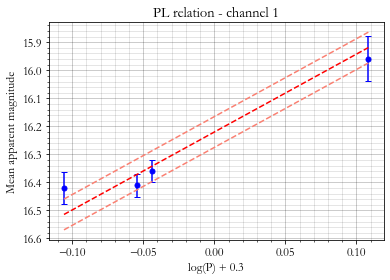

Intercept, a: 16.22
Error in a:    0.03
Std. dev.:     0.05

Distance modulus: 16.62 ± 0.04 (random) ± 0.12 (systematic)
Distance: 21.09 ± 0.42 (random) ± 1.14 (systematic) kpc




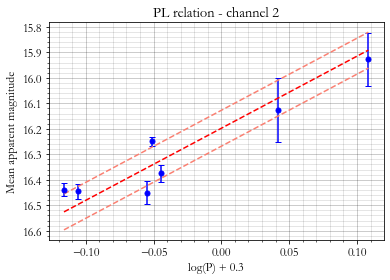

Intercept, a: 16.20
Error in a:    0.03
Std. dev.:     0.07

Distance modulus: 16.61 ± 0.04 (random) ± 0.12 (systematic)
Distance: 20.97 ± 0.40 (random) ± 1.17 (systematic) kpc


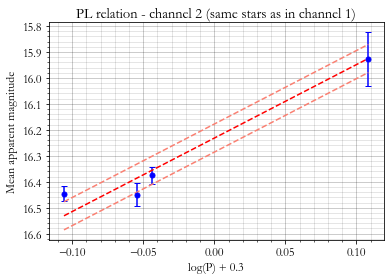

Intercept, a: 16.23
Error in a:    0.03
Std. dev.:     0.05

Distance modulus: 16.64 ± 0.04 (random) ± 0.12 (systematic)
Distance: 21.30 ± 0.42 (random) ± 1.18 (systematic) kpc


In [13]:
which_photerr = 'hendel'  # final decision: using 'hendel'
which_fiterr = 'std'      # final decision: using 'std'

a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(df_CC['mean_mag_ch1'])

# Trying ch2 without RRL2:
if cluster == 'PAL13':
    means_ch2_temp = np.array(df_CC['mean_mag_ch2'])
    means_ch2_temp[1] = float('NaN')
    #means_ch2_temp[1] = 16.4
    means_ch2 = np.ma.masked_invalid(means_ch2_temp)
else:
    means_ch2 = np.ma.masked_invalid(df_CC['mean_mag_ch2'])
# Un-comment this if no stars re being excluded:
#means_ch2 = np.ma.masked_invalid(df_CC['mean_mag_ch2'])

photerr_mean_ch1 = np.ma.masked_array(df_CC['mean_photerr_ch1'], means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(df_CC['mean_photerr_ch2'], means_ch2.mask)
photerr_mean_ch1_monson = np.ma.masked_array(df_CC['mean_photerr_mon_ch1'], means_ch1.mask)
photerr_mean_ch2_monson = np.ma.masked_array(df_CC['mean_photerr_mon_ch2'], means_ch2.mask)
photerr_mean_ch1_hendel = np.ma.masked_array(df_CC['mean_photerr_hen_ch1'], means_ch1.mask)
photerr_mean_ch2_hendel = np.ma.masked_array(df_CC['mean_photerr_hen_ch2'], means_ch2.mask)
photerr_amps_ch1 = np.ma.masked_array(df_CC['mean_photerr_amp_ch1'], means_ch1.mask)
photerr_amps_ch2 = np.ma.masked_array(df_CC['mean_photerr_amp_ch2'], means_ch2.mask)
stds_ch1 = np.ma.masked_array(df_CC['mean_std_ch1'], means_ch1.mask)
stds_ch2 = np.ma.masked_array(df_CC['mean_std_ch2'], means_ch2.mask)
A_ch1 = np.ma.masked_array(df_CC['A_ch1'], means_ch1.mask)
A_ch2 = np.ma.masked_array(df_CC['A_ch2'], means_ch2.mask)
periods_ch1 = np.ma.masked_array(df_CC['period_PL'], means_ch1.mask)
periods_ch2 = np.ma.masked_array(df_CC['period_PL'], means_ch2.mask)

if which_fiterr == 'std':
    fiterr_ch1 = stds_ch1
    fiterr_ch2 = stds_ch2
else:
    fiterr_ch1 = photerr_amps_ch1
    fiterr_ch2 = photerr_amps_ch2

if which_photerr == 'monson':
    photerr_ch1 = photerr_mean_ch1_monson
    photerr_ch2 = photerr_mean_ch2_monson
if which_photerr == 'hendel':
    photerr_ch1 = photerr_mean_ch1_hendel
    photerr_ch2 = photerr_mean_ch2_hendel
else:
    photerr_ch1 = photerr_mean_ch1
    photerr_ch2 = photerr_mean_ch2

err_mean_ch1 = np.sqrt(photerr_ch1**2 + fiterr_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_ch2**2 + fiterr_ch2**2 + A_ch2**2)


###   CHANNEL 1 PL   ###

popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
#plt.savefig('images/'+cluster+'/PL/PL_ch1.png', dpi=150)
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))


###   CHANNEL 2 PL   ###

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
#plt.savefig('images/'+cluster+'/PL/PL_ch2.png', dpi=150)
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))


###   CHANNEL 2 PL (only stars that are also visible in channel 1)   ###

# Plotting only channel 2 stars also visible in channel 1:
means_ch2_1 = np.ma.masked_array(means_ch2, means_ch1.mask)
photerr_amps_ch2_1 = np.ma.masked_array(photerr_amps_ch2, means_ch1.mask)
stds_ch2_1 = np.ma.masked_array(stds_ch2, means_ch1.mask)
err_mean_ch2_1 = np.ma.masked_array(err_mean_ch2, means_ch1.mask)
periods_ch2_1 = np.ma.masked_array(periods_ch2, means_ch1.mask)

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2_1.compressed(), means_ch2_1.compressed())
intercept_ch2_1 = popt[0]
err_int_ch2_1 = np.sqrt(pcov[0][0])

devs_ch2_1 = [(m - PL_fit_ch2(p, intercept_ch2_1))**2 for m, p in zip(means_ch2_1.compressed(), periods_ch2_1.compressed())]
std_ch2_1 = np.sqrt(np.mean(devs_ch2_1))

plt.errorbar(np.log10(periods_ch2_1.compressed()) + 0.3, means_ch2_1.compressed(), yerr=err_mean_ch2_1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1), 'r--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 + std_ch2_1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 - std_ch2_1), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2 (same stars as in channel 1)')
#plt.savefig('images/'+cluster+'/PL/PL_ch2_1.png', dpi=150)
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2_1, err_int_ch2_1, std_ch2_1))

distmod_ch2_1 = intercept_ch2_1 - a_ch2
dist_ch2_1 = 10 ** ((distmod_ch2_1 / 5.) + 1.)

distmod_randerr_ch2_1 = np.sqrt(err_int_ch2_1**2 + aerr_ch2**2)
dist_randerr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_randerr_ch2_1)

distmod_syserr_ch2_1 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_syserr_ch2_1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2_1, distmod_randerr_ch2_1, distmod_syserr_ch2_1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2_1/1000, dist_randerr_ch2_1/1000, dist_syserr_ch2_1/1000))



### Plotting PL relation (weighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

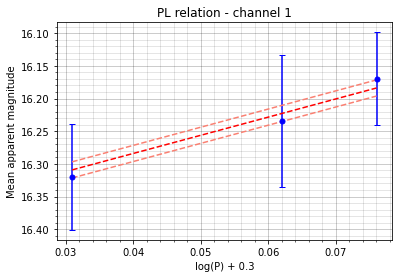

Intercept, a: 16.40
Error in a:    0.01
Std. dev.:     0.01

Distance modulus: 16.80 ± 0.03 (random) ± 0.12 (systematic)
Distance: 22.86 ± 0.33 (random) ± 1.24 (systematic) kpc




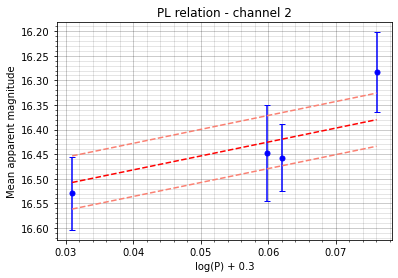

Intercept, a: 16.60
Error in a:    0.03
Std. dev.:     0.05

Distance modulus: 17.01 ± 0.04 (random) ± 0.12 (systematic)
Distance: 25.18 ± 0.50 (random) ± 1.40 (systematic) kpc


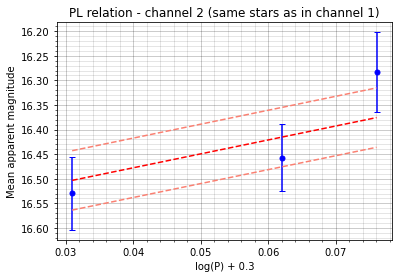

Intercept, a: 16.59
Error in a:    0.04
Std. dev.:     0.06

Distance modulus: 17.00 ± 0.05 (random) ± 0.12 (systematic)
Distance: 25.13 ± 0.58 (random) ± 1.40 (systematic) kpc


In [43]:
which_photerr = 'hendel'
which_fiterr = 'std'

a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(df_CC['mean_mag_ch1'])
#if cluster == 'PAL13':  # trying ch2 without RRL2
#    means_ch2_temp = np.array(df_CC['mean_mag_ch2'])
#    means_ch2_temp[1] = float('NaN')
#    means_ch2 = np.ma.masked_invalid(means_ch2_temp)
#else:
#    means_ch2 = np.ma.masked_invalid(df_CC['mean_mag_ch2'])
means_ch2 = np.ma.masked_invalid(df_CC['mean_mag_ch2']) 
photerr_mean_ch1 = np.ma.masked_array(df_CC['mean_photerr_ch1'], means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(df_CC['mean_photerr_ch2'], means_ch2.mask)
photerr_mean_ch1_monson = np.ma.masked_array(df_CC['mean_photerr_mon_ch1'], means_ch1.mask)
photerr_mean_ch2_monson = np.ma.masked_array(df_CC['mean_photerr_mon_ch2'], means_ch2.mask)
photerr_mean_ch1_hendel = np.ma.masked_array(df_CC['mean_photerr_hen_ch1'], means_ch1.mask)
photerr_mean_ch2_hendel = np.ma.masked_array(df_CC['mean_photerr_hen_ch2'], means_ch2.mask)
photerr_amps_ch1 = np.ma.masked_array(df_CC['mean_photerr_amp_ch1'], means_ch1.mask)
photerr_amps_ch2 = np.ma.masked_array(df_CC['mean_photerr_amp_ch2'], means_ch2.mask)
stds_ch1 = np.ma.masked_array(df_CC['mean_std_ch1'], means_ch1.mask)
stds_ch2 = np.ma.masked_array(df_CC['mean_std_ch2'], means_ch2.mask)
A_ch1 = np.ma.masked_array(df_CC['A_ch1'], means_ch1.mask)
A_ch2 = np.ma.masked_array(df_CC['A_ch2'], means_ch2.mask)
periods_ch1 = np.ma.masked_array(df_CC['period_PL'], means_ch1.mask)
periods_ch2 = np.ma.masked_array(df_CC['period_PL'], means_ch2.mask)

if which_fiterr == 'std':
    fiterr_ch1 = stds_ch1
    fiterr_ch2 = stds_ch2
else:
    fiterr_ch1 = photerr_amps_ch1
    fiterr_ch2 = photerr_amps_ch2

if which_photerr == 'monson':
    photerr_ch1 = photerr_mean_ch1_monson
    photerr_ch2 = photerr_mean_ch2_monson
if which_photerr == 'hendel':
    photerr_ch1 = photerr_mean_ch1_hendel
    photerr_ch2 = photerr_mean_ch2_hendel
else:
    photerr_ch1 = photerr_mean_ch1
    photerr_ch2 = photerr_mean_ch2

err_mean_ch1 = np.sqrt(photerr_ch1**2 + fiterr_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_ch2**2 + fiterr_ch2**2 + A_ch2**2)


###   CHANNEL 1 PL   ###

popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed(), sigma=err_mean_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))


###   CHANNEL 2 PL   ###

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed(), sigma=err_mean_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))


###   CHANNEL 2 PL (only stars that are also visible in channel 1)   ###

# Plotting only channel 2 stars also visible in channel 1:
means_ch2_1 = np.ma.masked_array(means_ch2, means_ch1.mask)
photerr_amps_ch2_1 = np.ma.masked_array(photerr_amps_ch2, means_ch1.mask)
stds_ch2_1 = np.ma.masked_array(stds_ch2, means_ch1.mask)
err_mean_ch2_1 = np.ma.masked_array(err_mean_ch2, means_ch1.mask)
periods_ch2_1 = np.ma.masked_array(periods_ch2, means_ch1.mask)

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2_1.compressed(), means_ch2_1.compressed(), sigma=err_mean_ch2_1.compressed())
intercept_ch2_1 = popt[0]
err_int_ch2_1 = np.sqrt(pcov[0][0])

devs_ch2_1 = [(m - PL_fit_ch2(p, intercept_ch2_1))**2 for m, p in zip(means_ch2_1.compressed(), periods_ch2_1.compressed())]
std_ch2_1 = np.sqrt(np.mean(devs_ch2_1))

plt.errorbar(np.log10(periods_ch2_1.compressed()) + 0.3, means_ch2_1.compressed(), yerr=err_mean_ch2_1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1), 'r--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 + std_ch2_1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 - std_ch2_1), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2 (same stars as in channel 1)')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2_1, err_int_ch2_1, std_ch2_1))

distmod_ch2_1 = intercept_ch2_1 - a_ch2
dist_ch2_1 = 10 ** ((distmod_ch2_1 / 5.) + 1.)

distmod_randerr_ch2_1 = np.sqrt(err_int_ch2_1**2 + aerr_ch2**2)
dist_randerr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_randerr_ch2_1)

distmod_syserr_ch2_1 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_syserr_ch2_1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2_1, distmod_randerr_ch2_1, distmod_syserr_ch2_1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2_1/1000, dist_randerr_ch2_1/1000, dist_syserr_ch2_1/1000))



#### Trying to get matching to master list based on coordinates working (but it won't and i am sad):
These aren't used any more but I'm keeping them around in case I need them

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL2_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
        1 10.402177 34.836456 229.05098 -0.16560569
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1343.18787331), array(75.13551432))


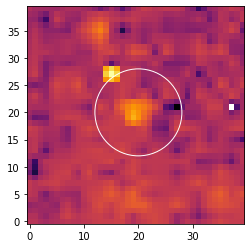

Mean: 55.818267822265625
Median: 53.148773193359375
Std dev: 21.55946159362793
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


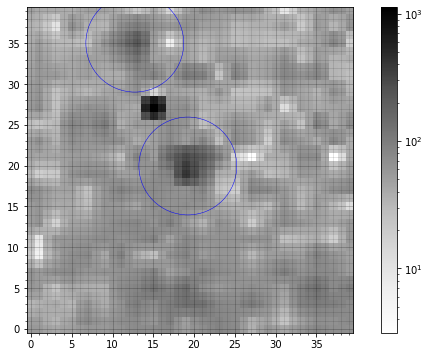

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.227897 19.956908 0.53458902 ... 357.69717 3.6291534  -1.3995133        1
  2 12.724014 35.022011 0.78328236 ... 218.59438 1.6044276 -0.51330033        2


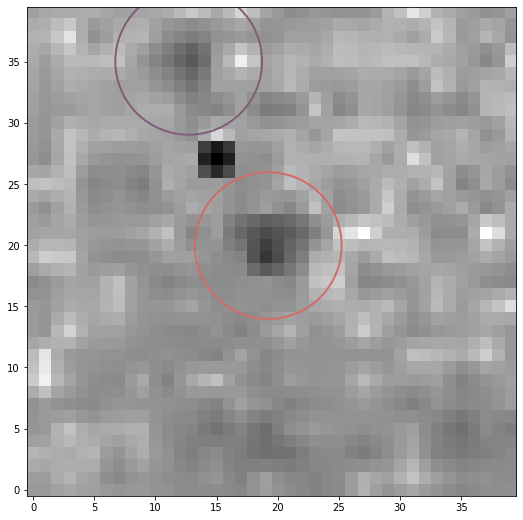

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.10932639999998628s
   x_0       y_0     flux_0   id ...   y_fit    flux_fit  flux_unc iter_detected
--------- --------- -------- --- ... --------- --------- --------- -------------
19.227897 19.956908 4822.526   1 ... 19.956908 4382.3119 123.23011             1
12.724014 35.022011 1350.585   2 ... 35.022011   1767.19 86.806252             1


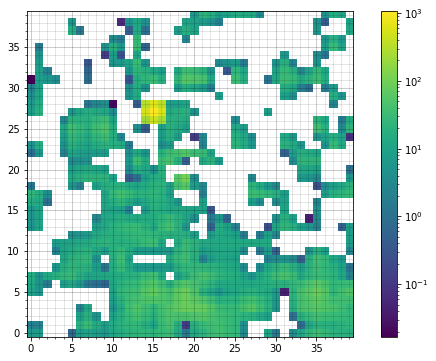

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.227897 19.956908    16.448818 0.042486303
  2        2             1 12.724014 35.022011    17.434868 0.060969787
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 19.227897 19.956908 16.448818 0.042486303
  2 12.724014 35.022011 17.434868 0.060969787
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05319478, -0.16745755), (229.0508948 , -0.16597776)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
       

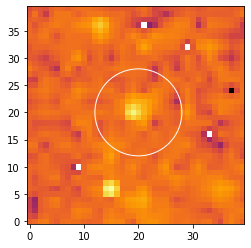

Mean: 48.83451843261719
Median: 46.608665466308594
Std dev: 19.045347213745117
yay all conditions check out
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


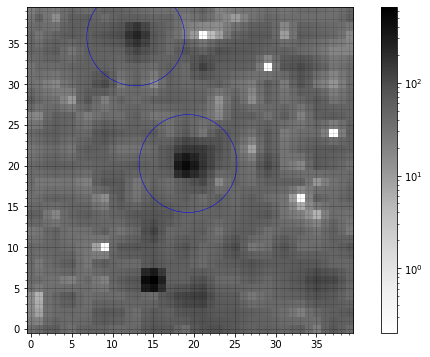

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.255515 20.258677 0.91022835 ... 500.10239 4.4391054  -1.6182387        1
  2 12.842023  35.79453 0.85214092 ... 237.62831 1.9954593 -0.75010718        2


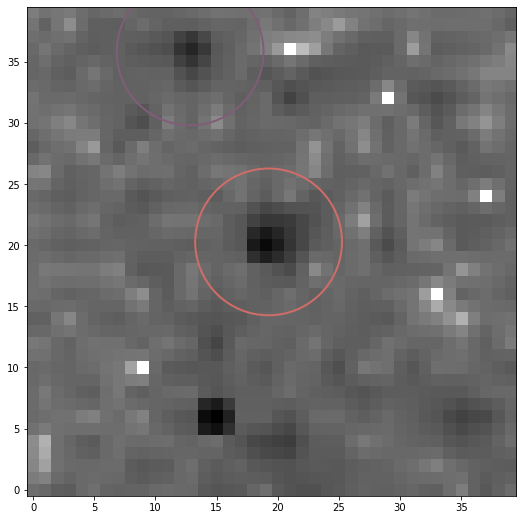

Time taken to fit PSF model: 0.029739500000005137s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.255515 20.258677 4008.3319   1 ... 4498.2229 119.32239             1
12.842023  35.79453  1651.618   2 ...  1964.124 73.524306             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


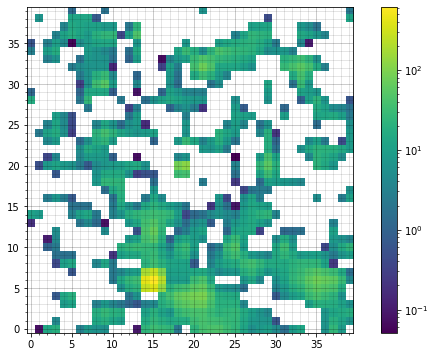

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.255515 20.258677    16.420101 0.041260712
  2        2             1 12.842023  35.79453    17.319781 0.050247543
first match table:
 id  xcenter   ycenter    mag_e2     err_e2  
--- --------- --------- --------- -----------
  1 19.255515 20.258677 16.420101 0.041260712
  2 12.842023  35.79453 17.319781 0.050247543
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05314435, -0.16745388), (229.05076385, -0.16597719)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0  17.5

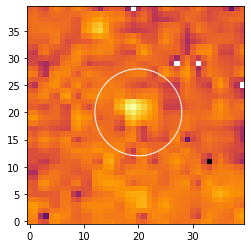

Mean: 47.087528228759766
Median: 44.870487213134766
Std dev: 20.56047248840332
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


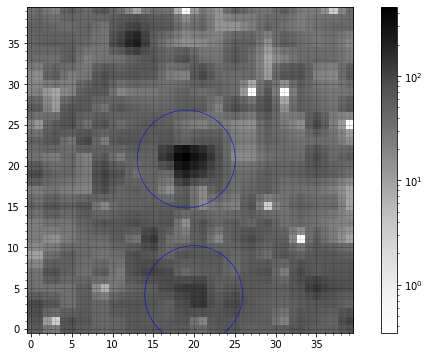

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.938693 4.1834707 0.36345366 ... 118.67358  1.122307 -0.12527918        1
  2 19.050473   20.8107 0.79079518 ... 463.30774 4.1436501  -1.5434577        2


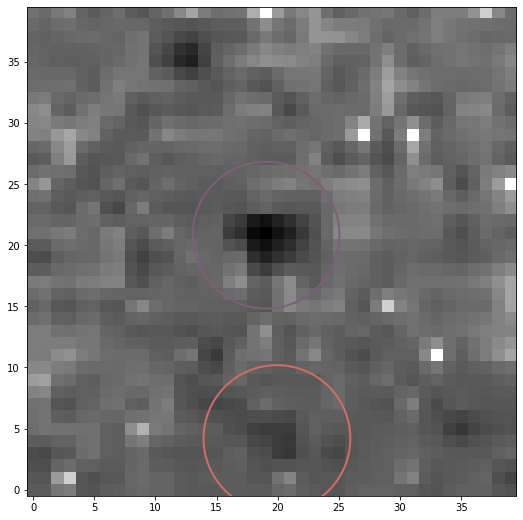

Time taken to fit PSF model: 0.03251090000003387s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.938693 4.1834707 2811.1269   1 ...  1525.146 114.99214             1
19.050473   20.8107 4252.8996   2 ... 4768.3704 126.55147             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


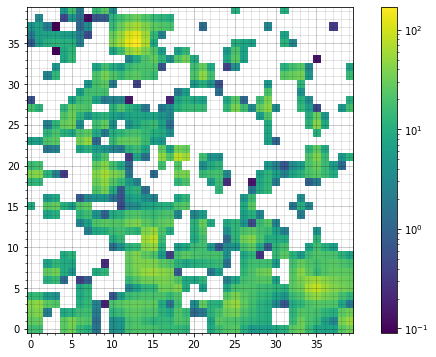

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.938693 4.1834707     17.59489 0.087030485
  2        2             1 19.050473   20.8107    16.357244 0.041270727
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1 19.938693 4.1834707  17.59489 0.087030485
  2 19.050473   20.8107 16.357244 0.041270727
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05576938, -0.16800199), (229.05305908, -0.16740521)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
comp @ idx:
[0 0]
id_master   x_0     y_0       RA    ...    err_e1     mag_e2     err_e2  
--------- -------- ------ --------- ... ----------- --------- -----------
        0 17.55

IndexError: index -99 is out of bounds for axis 0 with size 2

In [9]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        star = 2
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')
        print_table_nicely(master_table)
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                #sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')                
                
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                
                print('first match table:')
                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            print(cat_match)
            print(cat_m)

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)
            idx2, d2d2, d3d2 = match_coordinates_sky(cat_match, cat_m)
            
            print(idx, d2d, d3d)
            print(idx2, d2d2, d3d2)
            
            print('comp @ idx:')
            print(idx)
            print(comp_table[idx])

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d > max_sep)
            match_index = idx
            match_index[selection] = -99
            ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

            print(ind, match_index)

            print('\n\n')
            print_table_nicely(match_table)
            print_table_nicely(comp_table)
            print('\n\n')

            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            
            print(match_table)
            print(comp_table)
            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            match_table = match_table[ind]
            comp_table = comp_table[match_index][ind]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        '''save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()'''


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946
        1  23.78174 2.2946799 228.99106 -0.11590368
        2 19.035947 17.895987 228.98862 -0.11470356
        3 28.339118 3.5178503 228.99074 -0.11662042
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1094.44146707), array(511.14364631))


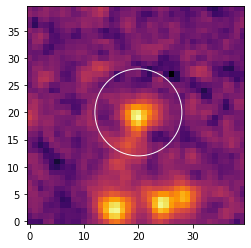

Mean: 51.14960861206055
Median: 45.8643913269043
Std dev: 20.52968978881836
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.575564766899848 ...  3.229357000877366 -1.2727901457891397
  2 24.468016488625913 ... 2.6370181380326754 -1.0527827924589486
  3 19.840980613332604 ... 3.0119700744567304 -1.1971266315018754
Number of PSF stars: 3


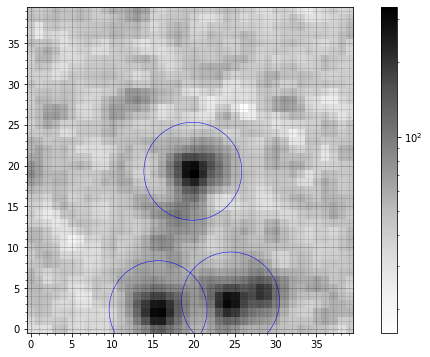

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.575565 2.3412497  0.5500007 ... 313.79651  3.229357 -1.2727901        1
  2 24.468016 3.4122953 0.66038248 ... 308.46622 2.6370181 -1.0527828        1
  3 19.840981 19.312539 0.66081841 ... 335.77524 3.0119701 -1.1971266        2


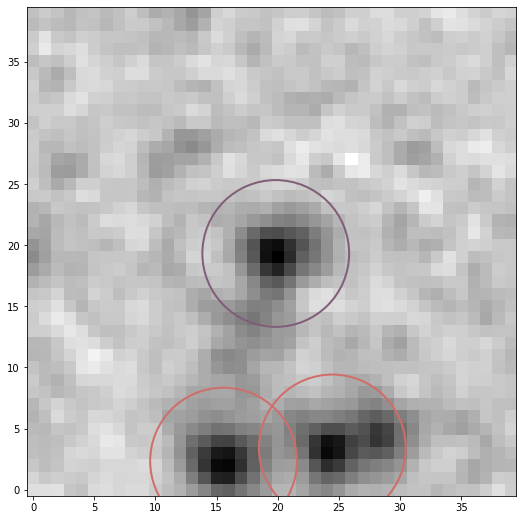

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13006529999984195s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.575565 2.3412497  5234.599   1 ... 4282.3508 158.62785             1
24.468016 3.4122953 6343.6234   2 ... 4203.3857 159.67692             1
19.840981 19.312539 5035.5648   3 ... 4349.1952 97.013214             1
28.818834 4.6227482 1987.8664   4 ... 1950.2446 69.134211             2


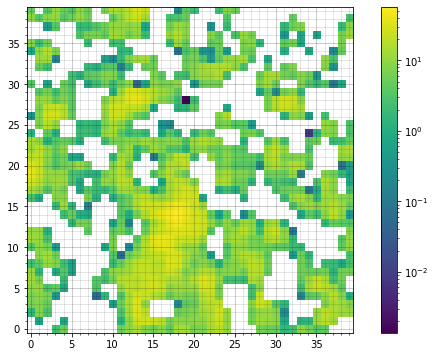

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.575565 2.3412497    16.481396 0.049904437
  2        1             1 24.468016 3.4122953    16.501604 0.050735348
  3        2             1 19.840981 19.312539     16.46458 0.038203282
  4        1             2 28.818834 4.6227482    17.335379 0.048521165
 id  xcenter   ycenter    mag_e1     err_e1   id_master
--- --------- --------- --------- ----------- ---------
  1 15.575565 2.3412497 16.481396 0.049904437         0
  2 24.468016 3.4122953 16.501604 0.050735348         1
  3 19.840981 19.312539  16.46458 0.038203282         2
  4 28.818834 4.6227482 17.335379 0.048521165         3
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946 16.481396 0.049904437
        1 

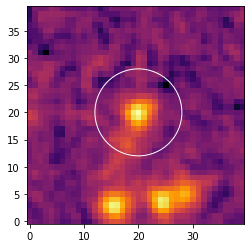

Mean: 45.08599090576172
Median: 39.76604461669922
Std dev: 21.78135871887207
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.529851137079332 ... 2.8684341330745937 -1.1441122044230256
  2 24.588323791199468 ...  2.521756212073415 -1.0042577483475987
  3 19.895611595859556 ... 3.2725228838763614 -1.2872067303461203
Number of PSF stars: 3


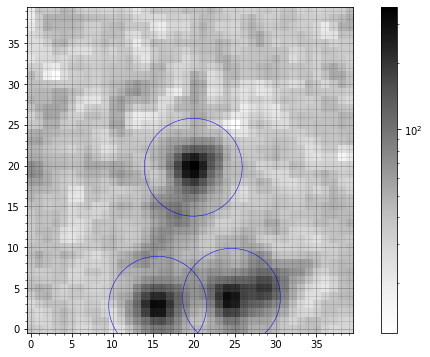

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.529851 2.8852351  0.6115023 ...  317.5033 2.8684341 -1.1441122        1
  2 24.588324 3.8501471 0.64750822 ... 305.72614 2.5217562 -1.0042577        1
  3 19.895612  19.80354 0.63817235 ... 359.59317 3.2725229 -1.2872067        2


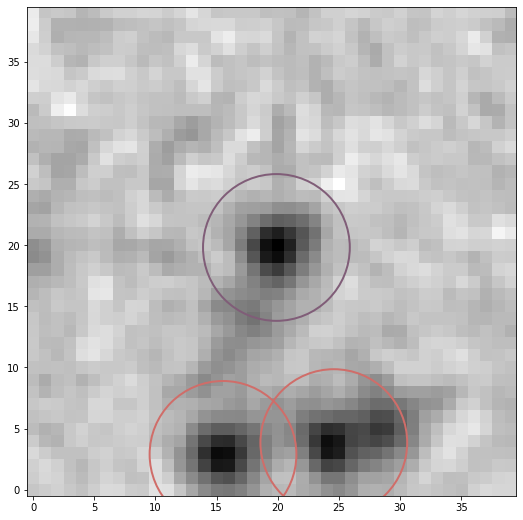

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05155899999954272s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.529851 2.8852351 4907.8212   1 ...  3888.027 149.42427             1
24.588324 3.8501471 6495.5983   2 ... 4029.7415 151.86088             1
19.895612  19.80354 5290.4631   3 ...  4546.161 96.792641             1
28.991484 5.2863925 2094.5302   4 ...  2008.288 91.399826             2


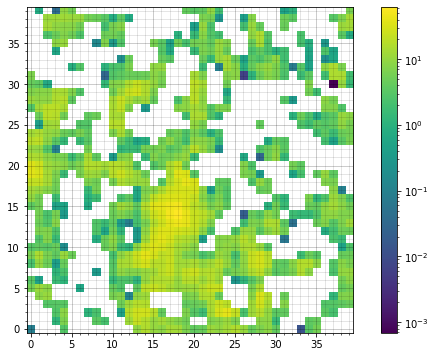

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.529851 2.8852351    16.585697 0.051128195
  2        1             1 24.588324 3.8501471    16.546827  0.05046856
  3        2             1 19.895612  19.80354    16.415908 0.037514391
  4        1             2 28.991484 5.2863925    17.302955 0.057572822
 id  xcenter   ycenter    mag_e2     err_e2   id_master
--- --------- --------- --------- ----------- ---------
  1 15.529851 2.8852351 16.585697 0.051128195         0
  2 24.588324 3.8501471 16.546827  0.05046856         1
  3 19.895612  19.80354 16.415908 0.037514391         2
  4 28.991484 5.2863925 17.302955 0.057572822         3
id_master    x_0       y_0        RA    ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049904437 16.585697 0.05112819

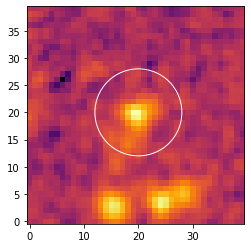

Mean: 43.298133850097656
Median: 38.060081481933594
Std dev: 21.694374084472656
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.324348926937843 ...  2.740425138283709  -1.094544856766432
  2 24.356835138718903 ...  2.714869883759798 -1.0843725497115577
  3  19.62447740837231 ... 3.2168555396751186 -1.2685788958587219
Number of PSF stars: 3


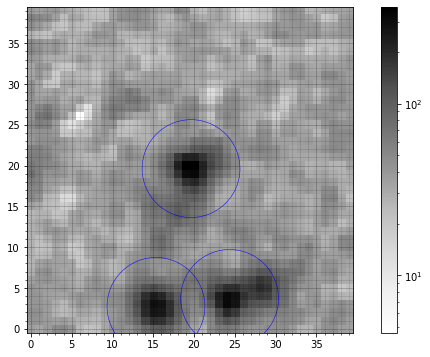

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.324349 2.7371235  0.5340575 ... 289.66589 2.7404251 -1.0945449        1
  2 24.356835 3.7104366 0.65278165 ... 315.94113 2.7148699 -1.0843725        1
  3 19.624477  19.63687  0.6275326 ... 355.89859 3.2168555 -1.2685789        2


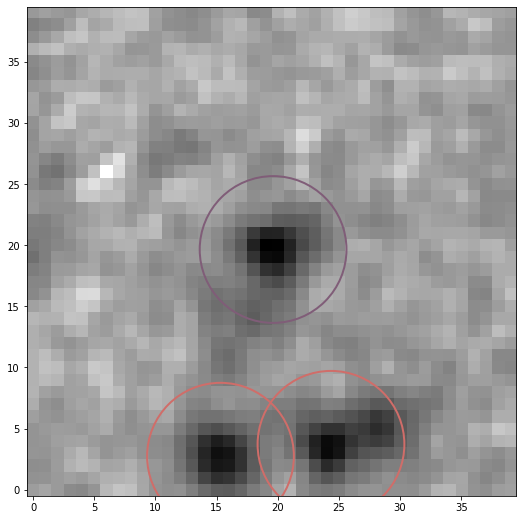

Time taken to fit PSF model: 0.05036079999990761s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.324349 2.7371235 4992.7411   1 ... 4055.7058 150.07603             1
24.356835 3.7104366  6316.759   2 ... 4313.4969 150.60356             1
19.624477  19.63687 5878.2963   3 ... 4946.7007 89.934214             1
28.912678 5.2484861 2236.2822   4 ... 2001.7659 81.189482             2


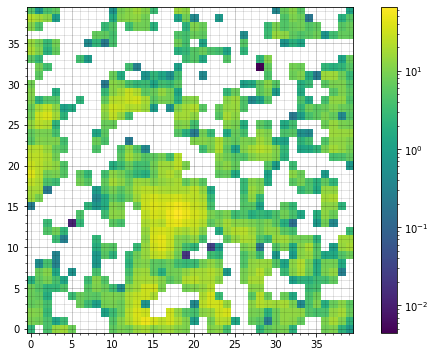

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.324349 2.7371235    16.540501 0.049870705
  2        1             1 24.356835 3.7104366    16.473594 0.048062134
  3        2             1 19.624477  19.63687    16.324878 0.035533096
  4        1             2 28.912678 5.2484861    17.307134 0.053029737
 id  xcenter   ycenter    mag_e3     err_e3   id_master
--- --------- --------- --------- ----------- ---------
  1 15.324349 2.7371235 16.540501 0.049870705         0
  2 24.356835 3.7104366 16.473594 0.048062134         1
  3 19.624477  19.63687 16.324878 0.035533096         2
  4 28.912678 5.2484861 17.307134 0.053029737         3
id_master    x_0       y_0        RA    ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.051128195 16.540501 0.04987070

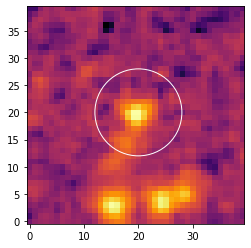

Mean: 41.48185729980469
Median: 36.60084533691406
Std dev: 21.256439208984375
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.402103064215103 ...  2.940967477508381 -1.1712255547930523
  2 24.441040130497164 ... 2.5445886987166184 -1.0140439850382048
  3 19.584984056330125 ...  3.317834368858013 -1.3021367540351565
Number of PSF stars: 3


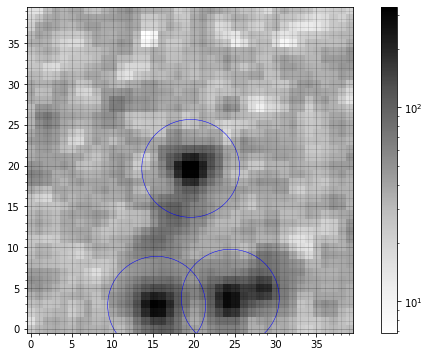

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.402103 2.8725598 0.62275623 ... 325.81424 2.9409675 -1.1712256        1
  2  24.44104 3.7414083 0.61550877 ... 291.70139 2.5445887  -1.014044        1
  3 19.584984 19.661793 0.57186691 ... 331.10718 3.3178344 -1.3021368        2


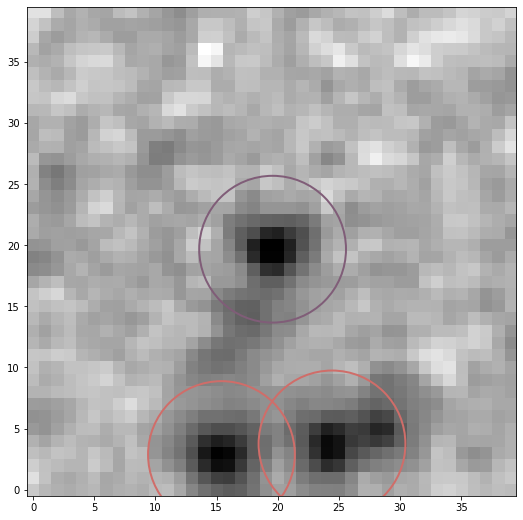

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13611569999920903s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.402103 2.8725598 5329.7702   1 ... 4051.8584 141.20479             1
 24.44104 3.7414083 6082.0895   2 ... 4012.1419 146.73186             1
19.584984 19.661793 5237.4321   3 ... 4606.1036 84.637918             1
28.863052 5.1782517 1945.5198   4 ... 1840.7738  83.87635             2


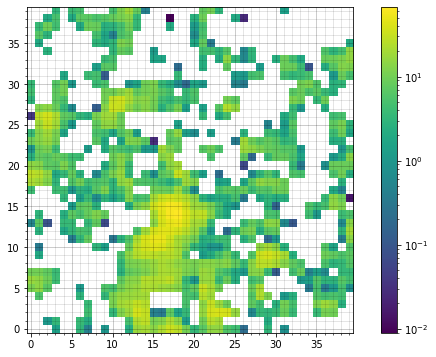

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.402103 2.8725598    16.541081 0.048006401
  2        1             1  24.44104 3.7414083    16.551776 0.049493862
  3        2             1 19.584984 19.661793    16.401882 0.035650853
  4        1             2 28.863052 5.1782517    17.397715 0.057623613
 id  xcenter   ycenter    mag_e4     err_e4   id_master
--- --------- --------- --------- ----------- ---------
  1 15.402103 2.8725598 16.541081 0.048006401         0
  2  24.44104 3.7414083 16.551776 0.049493862         1
  3 19.584984 19.661793 16.401882 0.035650853         2
  4 28.863052 5.1782517 17.397715 0.057623613         3
id_master    x_0       y_0        RA    ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049870705 16.541081 0.04800640

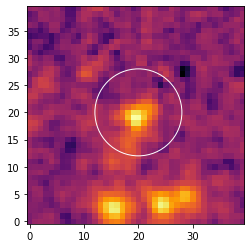

Mean: 41.5771484375
Median: 36.40973663330078
Std dev: 20.748353958129883
 id     xcentroid     ...        flux               mag         
--- ----------------- ... ----------------- --------------------
  1 15.41594560840494 ... 3.177380045210075  -1.2551729093265562
  2 24.46245075408594 ... 2.722809928717321   -1.087543313972069
  3 28.03162586417031 ... 1.344736198500567 -0.32159273915026876
  4 19.64046228737398 ... 3.441693502329084  -1.3419304797856226
Number of PSF stars: 4


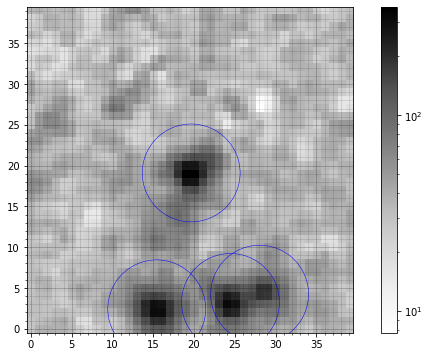

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.415946 2.4431413 0.54827609 ...  302.9071   3.17738  -1.2551729        1
  2 24.462451 3.2251417 0.69369881 ... 313.86978 2.7228099  -1.0875433        1
  3 28.031626 4.2359861 0.67056078 ... 186.96165 1.3447362 -0.32159274        1
  4 19.640462 19.105593  0.6297486 ... 353.34238 3.4416935  -1.3419305        2


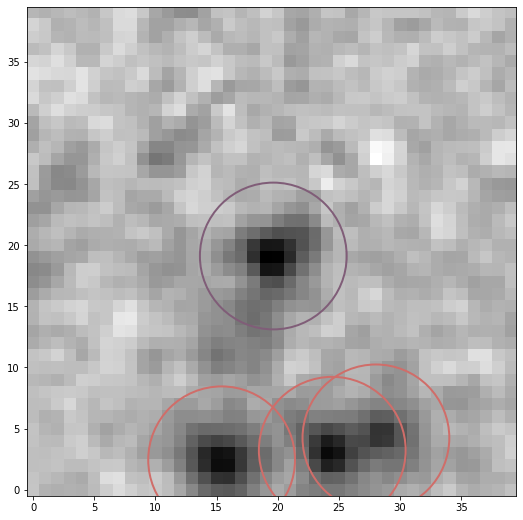

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04051690000051167s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.415946 2.4431413 5087.0391   1 ... 4361.4582 93.197894             1
24.462451 3.2251417 6117.9363   2 ... 3480.1308 89.643748             1
28.031626 4.2359861 5933.2528   3 ... 1937.2708 95.931724             1
19.640462 19.105593 5364.6779   4 ... 4337.1694 89.390413             1


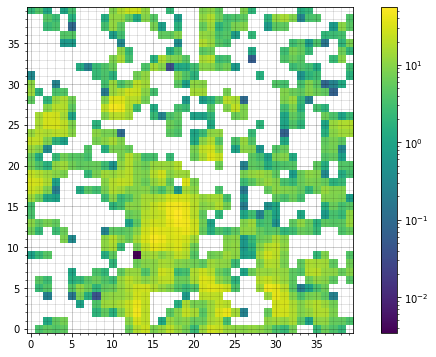

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.415946 2.4431413    16.461172 0.037566263
  2        1             1 24.462451 3.2251417    16.706262 0.040683178
  3        1             1 28.031626 4.2359861    17.342275 0.061348083
  4        2             1 19.640462 19.105593    16.467235 0.037063511
 id  xcenter   ycenter    mag_e5     err_e5   id_master
--- --------- --------- --------- ----------- ---------
  1 15.415946 2.4431413 16.461172 0.037566263         0
  2 24.462451 3.2251417 16.706262 0.040683178         1
  3 28.031626 4.2359861 17.342275 0.061348083         2
  4 19.640462 19.105593 16.467235 0.037063511         3
id_master    x_0       y_0        RA    ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.048006401 16.461172 0.03756626

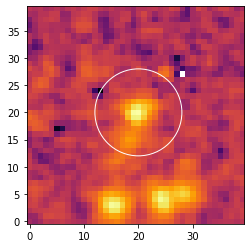

Mean: 34.465213775634766
Median: 28.9788818359375
Std dev: 21.482254028320312
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.434755562019973 ...  2.738553859224638 -1.0938032165799807
  2 24.534598456523725 ... 2.4849501718563496 -0.9882942117430025
  3  19.74102929173598 ... 3.1529990801217895 -1.2468096101094626
Number of PSF stars: 3


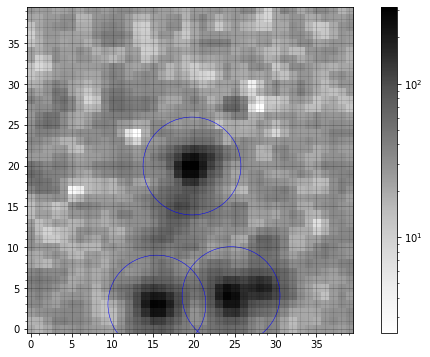

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.434756 3.0174515 0.61955722 ... 295.59125 2.7385539  -1.0938032        1
  2 24.534598 4.0607341 0.64556602 ... 289.43369 2.4849502 -0.98829421        1
  3 19.741029 19.956366 0.59445665 ... 317.62701 3.1529991  -1.2468096        2


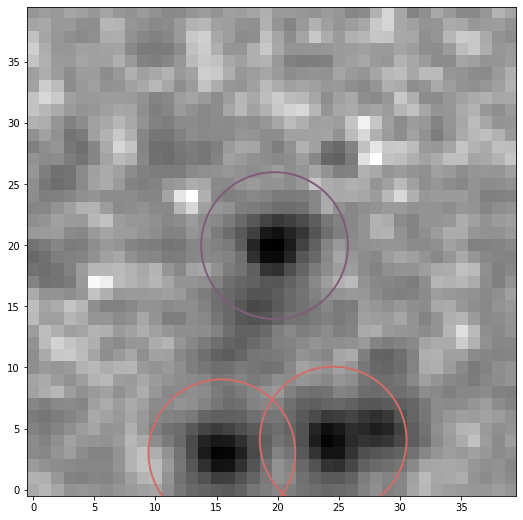

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.053249399999913294s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.434756 3.0174515 4753.6891   1 ... 3652.2488 138.09474             1
24.534598 4.0607341 6293.5869   2 ... 3843.2674 138.94848             1
19.741029 19.956366 5310.5515   3 ... 4089.3208 104.98822             1
28.973933 5.1364362 2135.1223   4 ...  1802.625 89.064865             2


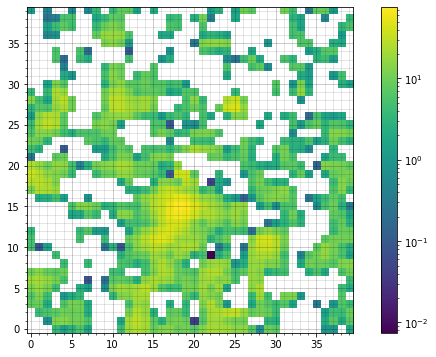

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.434756 3.0174515    16.653923 0.050579411
  2        1             1 24.534598 4.0607341    16.598573 0.049130323
  3        2             1 19.741029 19.956366    16.531196  0.04061981
  4        1             2 28.973933 5.1364362    17.420561 0.061242892
 id  xcenter   ycenter    mag_e6     err_e6   id_master
--- --------- --------- --------- ----------- ---------
  1 15.434756 3.0174515 16.653923 0.050579411         0
  2 24.534598 4.0607341 16.598573 0.049130323         1
  3 19.741029 19.956366 16.531196  0.04061981         2
  4 28.973933 5.1364362 17.420561 0.061242892         3
id_master    x_0       y_0        RA    ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.037566263 16.653923 0.05057941

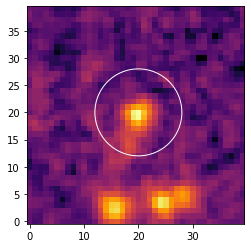

Mean: 44.564720153808594
Median: 39.59773254394531
Std dev: 20.280550003051758
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.564749020605866 ... 2.9685813322824215 -1.1813723802308034
  2 24.521924645846568 ...  2.701261719771453 -1.0789166603446532
  3    19.834005774293 ...  3.475327996429202 -1.3524894973636068
Number of PSF stars: 3


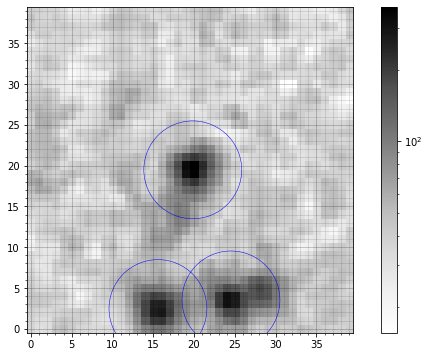

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.564749 2.4744354  0.5221548 ... 280.71216 2.9685813 -1.1813724        1
  2 24.521925 3.5346052 0.66508775 ... 305.35577 2.7012617 -1.0789167        1
  3 19.834006 19.485999 0.67392894 ... 367.90244  3.475328 -1.3524895        2


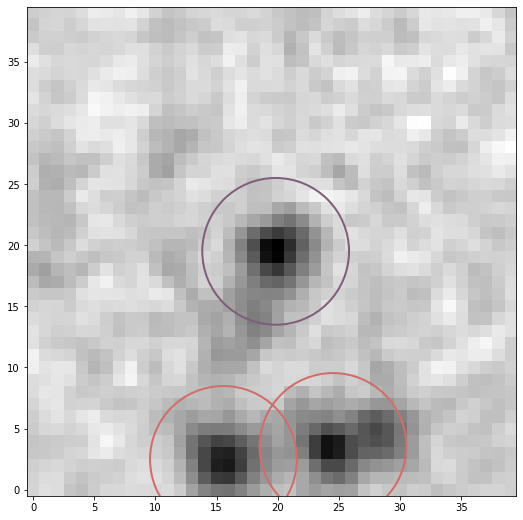

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.11658429999806685s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.564749 2.4744354 4970.8549   1 ... 4167.3416 152.34688             1
24.521925 3.5346052 6218.9892   2 ... 4314.5054 151.11573             1
19.834006 19.485999 5261.3001   3 ... 4973.3311  114.0385             1
28.882514  4.655196 1819.9378   4 ... 1733.0658 75.841961             2


KeyboardInterrupt: 

In [145]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
    
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')

        print_table_nicely(master_table)

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi=1.)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                    
                print(sources_PSF)
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                for i, group in enumerate(star_groups.groups):
                    pos_group = np.transpose([group['x_0'], group['y_0']])
                    ap_group = CircularAperture(pos_group, r_ap)
                    ap_group.plot(color=cmap.colors[i], lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                match_table['id_master'] = master_table['id_master']

                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###


            # This approach relies on the same stars being detected in the same order in each epoch, which isn't ideal:
            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)


            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close() 


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###